# Analyse croisee -- Memoire SF / Osteopathie / Syndrome de Lacomme

**Problematique** : En quoi la representation de l'osteopathie par les sages-femmes influence-t-elle la collaboration interprofessionnelle et la place qu'elles leur accordent dans la prise en charge du syndrome de Lacomme ?

## Methodologie statistique

| Croisement | Test | Justification |
|---|---|---|
| Ordinale x Ordinale (echelles 1-5) | **Spearman** | Correlation monotone entre rangs |
| Nominale x Nominale | **Chi-deux** + V de Cramer | Independance entre categories |
| Nominale (2 grp) x Ordinale | **Mann-Whitney U** | Comparaison de 2 distributions |
| Nominale (3+ grp) x Ordinale | **Kruskal-Wallis H** | Comparaison de k distributions |

Seuil : alpha = 0.05

In [1]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, mannwhitneyu, kruskal, spearmanr
from IPython.display import display, Markdown
import textwrap, warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", font_scale=0.9)
plt.rcParams.update({'figure.dpi': 120, 'font.family': 'DejaVu Sans'})
COLORS = ['#1976D2','#FF8F00','#388E3C','#D32F2F','#7B1FA2','#00838F','#E64A19','#455A64']
print("OK")

OK


## 1. Chargement et preparation des donnees

In [2]:
df_raw = pd.read_excel('GRAPHIQUE_ACTUEL.xlsx', sheet_name='Feuil1', header=0)
print(f"Dimensions : {df_raw.shape[0]} repondants, {df_raw.shape[1]} variables")

Dimensions : 151 repondants, 36 variables


In [3]:
# Renommage simplifie
rn = {}
for i, name in enumerate(['Q1','Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q9','Q10','Q11','Q12',
                           'Q13','Q14','Q15_1','Q15_2','Q15_3','Q15_4','Q15_5','Q15_6',
                           'Q16','Q17','Q18','Q19','Q20','Q21','Q22','Q23','Q24','Q25',
                           'Q26','Q26_texte','Q27','Q27_texte','Q28','Q28_texte']):
    if i < len(df_raw.columns):
        rn[df_raw.columns[i]] = name
df = df_raw.rename(columns=rn)

# Nettoyage
for col in ['Q2','Q3','Q9','Q12','Q14','Q17','Q22']:
    if col in df.columns:
        df[col] = df[col].replace(0, np.nan).replace('0', np.nan)

# Collaboration binaire
df['Q8_bin'] = df['Q8'].apply(lambda x: 'Non' if x == 'Non' else ('Oui' if pd.notna(x) else np.nan))

# Collaboration ordonnee
def map_collab(val):
    s = str(val).lower()
    if val == 'Non' or s == 'non': return 0
    if 'rarement' in s: return 1
    if 'occasionnellement' in s: return 2
    if 'guli' in s: return 3
    return np.nan
df['Q8_ord'] = df['Q8'].apply(map_collab)

# Rang osteopathie dans Q15
def get_osteo_rank(row):
    for i in range(1, 7):
        c = f'Q15_{i}'
        if c in row.index and pd.notna(row[c]) and 'ost' in str(row[c]).lower():
            return i
    return np.nan
df['Q15_osteo_rank'] = df.apply(get_osteo_rank, axis=1)

print("Nettoyage OK. Colonnes :", list(df.columns[:25]))

Nettoyage OK. Colonnes : ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15_1', 'Q15_2', 'Q15_3', 'Q15_4', 'Q15_5', 'Q15_6', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20']


## 2. Classification des variables

In [4]:
ORDINALES = {'Q4','Q5','Q6','Q10','Q16','Q18','Q8_ord','Q15_osteo_rank'}
NOMINALES = {'Q1','Q3','Q7','Q13','Q17','Q22','Q23','Q24','Q8_bin'}
NOM_ORD = {'Q2','Q8','Q12'}

LABELS = {
    'Q1':'Statut','Q2':'Anciennete','Q3':'Lieu exercice',
    'Q4':'Connaissances osteo (1-5)','Q5':'Utilite osteo (1-5)',
    'Q6':'Sentiment info (1-5)','Q7':'Acces reseau','Q8':'Collaboration (detail)',
    'Q8_bin':'Collaboration (Oui/Non)','Q8_ord':'Freq. collaboration (0-3)',
    'Q10':'Connaissances SdL (1-5)','Q12':'Frequence SdL',
    'Q13':'Retard diagnostic','Q15_osteo_rank':'Rang osteo (1-6)',
    'Q16':'Favorabilite (1-5)','Q17':'Moment orientation',
    'Q18':'Info patientes (1-5)','Q22':'Influence reco officielles',
    'Q23':'Amelioration PEC','Q24':'Integration pluridisciplinaire',
}

info = []
for k in sorted(LABELS.keys()):
    t = 'Ordinale' if k in ORDINALES else 'Nominale' if k in NOMINALES else 'Nominale ordonnee'
    info.append({'Variable':k, 'Label':LABELS[k], 'Type':t})
display(pd.DataFrame(info))

Variable                           Label               Type
0               Q1                          Statut           Nominale
1              Q10         Connaissances SdL (1-5)           Ordinale
2              Q12                   Frequence SdL  Nominale ordonnee
3              Q13               Retard diagnostic           Nominale
4   Q15_osteo_rank                Rang osteo (1-6)           Ordinale
5              Q16              Favorabilite (1-5)           Ordinale
6              Q17              Moment orientation           Nominale
7              Q18            Info patientes (1-5)           Ordinale
8               Q2                      Anciennete  Nominale ordonnee
9              Q22      Influence reco officielles           Nominale
10             Q23                Amelioration PEC           Nominale
11             Q24  Integration pluridisciplinaire           Nominale
12              Q3                   Lieu exercice           Nominale
13              Q4       Connaissances osteo (1-5)           Ordinale
14              Q5             Utilite osteo (1-5)           Ordinale
15              Q6            Sentiment info (1-5)           Ordinale
16              Q7                    Acces reseau           Nominale
17              Q8          Collaboration (detail)  Nominale ordonnee
18          Q8_bin         Collaboration (Oui/Non)           Nominale
19          Q8_ord       Freq. collaboration (0-3)           Ordinale

## 3. Description de l'echantillon

In [5]:
print(f"n = {len(df)}")
print()
for col, lab in [('Q1','Statut'),('Q3','Lieu exercice'),('Q7','Acces reseau'),
                  ('Q13','Retard diagnostic'),('Q23','Amelioration PEC'),('Q24','Integration')]:
    print(f"--- {lab} ({col}) ---")
    vc = df[col].value_counts()
    for val, cnt in vc.items():
        print(f"  {val} : {cnt} ({cnt/len(df)*100:.1f}%)")
    print()

print("--- Variables ordinales (1-5) ---")
rows = []
for col, lab in [('Q4','Conn. osteo'),('Q5','Utilite'),('Q6','Info SF'),
                  ('Q10','Conn. SdL'),('Q16','Favorabilite'),('Q18','Info patientes')]:
    s = df[col].describe()
    rows.append({'Variable':lab,'n':int(s['count']),'Moy':f"{s['mean']:.2f}",
                 'ET':f"{s['std']:.2f}",'Med':f"{s['50%']:.0f}"})
display(pd.DataFrame(rows).set_index('Variable'))

n = 151

--- Statut (Q1) ---
  Sage-femme diplômé(e) : 90 (59.6%)
  Étudiant(e) sage-femme en 5e année : 61 (40.4%)

--- Lieu exercice (Q3) ---
  Hospitalier : 57 (37.7%)
  Libéral : 30 (19.9%)
  Mixte : 3 (2.0%)

--- Acces reseau (Q7) ---
  Non : 75 (49.7%)
  Oui : 55 (36.4%)
  Sans avis : 21 (13.9%)

--- Retard diagnostic (Q13) ---
  Oui : 75 (49.7%)
  Sans avis : 43 (28.5%)
  Non : 33 (21.9%)

--- Amelioration PEC (Q23) ---
  Oui : 139 (92.1%)
  Sans avis : 7 (4.6%)
  Non : 5 (3.3%)

--- Integration (Q24) ---
  Oui : 136 (90.1%)
  Sans avis : 8 (5.3%)
  Non : 7 (4.6%)

--- Variables ordinales (1-5) ---


n   Moy    ET Med
Variable                           
Conn. osteo     151  2.58  1.02   3
Utilite         151  3.80  0.95   4
Info SF         151  2.72  1.15   3
Conn. SdL       151  3.19  0.97   3
Favorabilite    151  4.16  0.90   4
Info patientes  151  2.09  0.94   2

## 4. Fonctions d'analyse

**Logique de selection du test** : le test est determine par la nature des deux variables croisees.
Chaque analyse affiche systematiquement le tableau de contingence, le test statistique, et les graphiques detailles.

In [6]:
def get_type(v):
    if v in ORDINALES: return 'ord'
    if v in NOMINALES: return 'nom'
    if v in NOM_ORD: return 'nom_ord'
    return 'autre'

def select_test(v1, v2, data):
    t1, t2 = get_type(v1), get_type(v2)
    if t1 == 'ord' and t2 == 'ord':
        return 'spearman', f'{v1}(ord) x {v2}(ord) -> Spearman'
    if t1 in ('nom','nom_ord') and t2 in ('nom','nom_ord'):
        return 'chi2', f'{v1}(nom) x {v2}(nom) -> Chi-deux'
    # une nominale x une ordinale
    if t1 in ('nom','nom_ord') and t2 == 'ord':
        nom, ordn = v1, v2
    elif t2 in ('nom','nom_ord') and t1 == 'ord':
        nom, ordn = v2, v1
    else:
        return 'chi2', f'{v1}({t1}) x {v2}({t2}) -> Chi-deux (defaut)'
    ng = data[nom].nunique()
    if ng == 2:
        return 'mw', f'{nom}(nom,2grp) x {ordn}(ord) -> Mann-Whitney U'
    return 'kw', f'{nom}(nom,{ng}grp) x {ordn}(ord) -> Kruskal-Wallis H'

def interp_p(p):
    if p is None: return 'N/A'
    if p < 0.001: return '*** (p<0.001)'
    if p < 0.01: return '** (p<0.01)'
    if p < 0.05: return '* (p<0.05)'
    return f'NS (p={p:.3f})'

def interp_v(v):
    if v < 0.1: return 'negligeable'
    if v < 0.3: return 'faible'
    if v < 0.5: return 'modere'
    return 'fort'

def interp_rho(r):
    r = abs(r)
    if r < 0.1: return 'negligeable'
    if r < 0.3: return 'faible'
    if r < 0.5: return 'moderee'
    if r < 0.7: return 'forte'
    return 'tres forte'

def wl(labels, w=18):
    return ['\n'.join(textwrap.wrap(str(l), w)) for l in labels]

print("Fonctions OK")

Fonctions OK


In [7]:
def analyse(v1, v2, titre, question=""):
    data = df[[v1, v2]].copy().replace(0, np.nan).dropna()
    n = len(data)
    if n < 10:
        print(f"  Donnees insuffisantes (n={n})")
        return None
    l1, l2 = LABELS.get(v1, v1), LABELS.get(v2, v2)
    test, just = select_test(v1, v2, data)
    
    display(Markdown(f"### {titre}"))
    if question:
        display(Markdown(f"*{question}*"))
    display(Markdown(f"**{l1}** x **{l2}** | n = {n} | Test : {just}"))
    
    res = {'titre':titre,'var1':v1,'var2':v2,'l1':l1,'l2':l2,'n':n,'test':test}
    
    # ========== CHI-DEUX ==========
    if test == 'chi2':
        ct = pd.crosstab(data[v1], data[v2])
        ct_m = pd.crosstab(data[v1], data[v2], margins=True, margins_name='Total')
        ct_pctc = pd.crosstab(data[v1], data[v2], normalize='columns') * 100
        ct_pctr = pd.crosstab(data[v1], data[v2], normalize='index') * 100
        
        if ct.shape[0] < 2 or ct.shape[1] < 2:
            print("  Tableau trop petit")
            return None
        
        chi2, p, dof, exp = chi2_contingency(ct)
        N = ct.sum().sum()
        V = np.sqrt(chi2 / (N * (min(ct.shape)-1)))
        exp_df = pd.DataFrame(exp, index=ct.index, columns=ct.columns).round(1)
        pct_low = (exp < 5).sum() / exp.size * 100
        residus = (ct.values - exp) / np.sqrt(exp)
        res_df = pd.DataFrame(residus, index=ct.index, columns=ct.columns).round(2)
        
        display(Markdown("**Effectifs observes :**"))
        display(ct_m)
        display(Markdown("**Pourcentages en colonne (%) :**"))
        display(ct_pctc.round(1))
        display(Markdown("**Pourcentages en ligne (%) :**"))
        display(ct_pctr.round(1))
        display(Markdown("**Effectifs theoriques :**"))
        display(exp_df)
        if pct_low > 20:
            display(Markdown(f"**Attention : {pct_low:.0f}% des effectifs theoriques < 5.**"))
        display(Markdown("**Residus standardises (contributions au Chi2) :**"))
        display(res_df)
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))
        fig.suptitle(titre + f'  (n={n})', fontsize=12, fontweight='bold', y=1.02)
        
        sns.heatmap(ct, annot=True, fmt='d', cmap='Blues', ax=axes[0], linewidths=0.8)
        axes[0].set_title('Effectifs observes', fontweight='bold')
        axes[0].set_xticklabels(wl(ct.columns,14), rotation=45, ha='right', fontsize=7)
        axes[0].set_yticklabels(wl(ct.index,18), rotation=0, fontsize=7)
        
        ct_pctc_plot = ct.div(ct.sum(axis=0), axis=1) * 100
        ct_pctc_plot.T.plot(kind='bar', stacked=True, ax=axes[1],
                           color=COLORS[:len(ct.index)], edgecolor='white', linewidth=0.5)
        axes[1].set_title('% en colonne (empile)', fontweight='bold')
        axes[1].set_xticklabels(wl(ct.columns,14), rotation=45, ha='right', fontsize=7)
        axes[1].legend(title='', bbox_to_anchor=(1.02,1), loc='upper left', fontsize=6)
        axes[1].set_ylim(0,110)
        axes[1].set_ylabel('%')
        
        sns.heatmap(res_df, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=axes[2],
                   linewidths=0.8, vmin=-3, vmax=3)
        axes[2].set_title('Residus standardises', fontweight='bold')
        axes[2].set_xticklabels(wl(ct.columns,14), rotation=45, ha='right', fontsize=7)
        axes[2].set_yticklabels(wl(ct.index,18), rotation=0, fontsize=7)
        
        fig.text(0.5, -0.02,
                f'Chi2={chi2:.3f}  ddl={dof}  p={p:.4f} {interp_p(p)}  |  V de Cramer={V:.3f} ({interp_v(V)})',
                ha='center', fontsize=9, bbox=dict(facecolor='lightyellow',alpha=0.8,boxstyle='round'))
        plt.tight_layout()
        plt.show()
        
        res.update({'chi2':chi2,'p':p,'dof':dof,'V':V,'pct_low':pct_low})
    
    # ========== MANN-WHITNEY ==========
    elif test == 'mw':
        t1 = get_type(v1)
        if t1 in ('nom','nom_ord'): cat, ordn, clab, olab = v1, v2, l1, l2
        else: cat, ordn, clab, olab = v2, v1, l2, l1
        
        grps = {name: g[ordn].values for name, g in data.groupby(cat) if len(g) >= 3}
        gnames = list(grps.keys())
        if len(gnames) < 2:
            print("  Moins de 2 groupes")
            return None
        g1, g2 = grps[gnames[0]], grps[gnames[1]]
        
        ct_m = pd.crosstab(data[cat], data[ordn], margins=True, margins_name='Total')
        ct_pctr = pd.crosstab(data[cat], data[ordn], normalize='index') * 100
        display(Markdown("**Effectifs observes :**"))
        display(ct_m)
        display(Markdown("**Pourcentages en ligne (%) :**"))
        display(ct_pctr.round(1))
        display(Markdown("**Statistiques par groupe :**"))
        display(data.groupby(cat)[ordn].describe().round(2))
        
        U, p = mannwhitneyu(g1, g2, alternative='two-sided')
        n1, n2 = len(g1), len(g2)
        mu_U = n1*n2/2
        sig_U = np.sqrt(n1*n2*(n1+n2+1)/12)
        Z = (U - mu_U) / sig_U
        r_eff = abs(Z) / np.sqrt(n1+n2)
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))
        fig.suptitle(titre + f'  (n={n})', fontsize=12, fontweight='bold', y=1.02)
        
        order = sorted(data[cat].unique(), key=str)
        sns.boxplot(data=data, x=cat, y=ordn, ax=axes[0], palette=COLORS, order=order, width=0.5)
        sns.stripplot(data=data, x=cat, y=ordn, ax=axes[0], color='black', alpha=0.3, size=3, jitter=True, order=order)
        meds = data.groupby(cat)[ordn].median()
        mns = data.groupby(cat)[ordn].mean()
        for i, c in enumerate(order):
            if c in meds.index:
                axes[0].text(i, meds[c]+0.15, f'Md={meds[c]:.1f}\nM={mns[c]:.2f}',
                           ha='center', fontsize=7, fontweight='bold', color='darkred')
        axes[0].set_title('Boxplot + points individuels', fontweight='bold')
        axes[0].set_xticklabels(wl(order,18), fontsize=7)
        
        sns.violinplot(data=data, x=cat, y=ordn, ax=axes[1], palette=COLORS, order=order, inner='quartile')
        axes[1].set_title('Violinplot (distribution)', fontweight='bold')
        axes[1].set_xticklabels(wl(order,18), fontsize=7)
        
        ct_no = pd.crosstab(data[ordn], data[cat])
        ct_no_pct = ct_no.div(ct_no.sum(axis=0), axis=1) * 100
        ct_no_pct.plot(kind='bar', ax=axes[2], color=COLORS[:len(order)], edgecolor='white')
        axes[2].set_title('Distribution des scores par groupe (%)', fontweight='bold')
        axes[2].set_xlabel(olab)
        axes[2].set_ylabel('%')
        axes[2].legend(title=clab, fontsize=7)
        
        r_int = 'negligeable' if r_eff<0.1 else 'faible' if r_eff<0.3 else 'modere' if r_eff<0.5 else 'fort'
        fig.text(0.5, -0.02,
                f'U={U:.1f}  Z={Z:.3f}  p={p:.4f} {interp_p(p)}  |  r={r_eff:.3f} ({r_int})',
                ha='center', fontsize=9, bbox=dict(facecolor='lightyellow',alpha=0.8,boxstyle='round'))
        plt.tight_layout()
        plt.show()
        
        res.update({'U':U,'p':p,'Z':Z,'r':r_eff})
    
    # ========== KRUSKAL-WALLIS ==========
    elif test == 'kw':
        t1 = get_type(v1)
        if t1 in ('nom','nom_ord'): cat, ordn, clab, olab = v1, v2, l1, l2
        else: cat, ordn, clab, olab = v2, v1, l2, l1
        
        grps = {name: g[ordn].values for name, g in data.groupby(cat) if len(g) >= 3}
        gnames = list(grps.keys())
        if len(gnames) < 2:
            print("  Moins de 2 groupes")
            return None
        
        ct_m = pd.crosstab(data[cat], data[ordn], margins=True, margins_name='Total')
        ct_pctr = pd.crosstab(data[cat], data[ordn], normalize='index') * 100
        display(Markdown("**Effectifs observes :**"))
        display(ct_m)
        display(Markdown("**Pourcentages en ligne (%) :**"))
        display(ct_pctr.round(1))
        display(Markdown("**Statistiques par groupe :**"))
        display(data.groupby(cat)[ordn].describe().round(2))
        
        arrays = [grps[k] for k in gnames]
        H, p = kruskal(*arrays)
        N = sum(len(a) for a in arrays)
        k_g = len(arrays)
        eta2 = (H - k_g + 1) / (N - k_g) if N > k_g else 0
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))
        fig.suptitle(titre + f'  (n={n})', fontsize=12, fontweight='bold', y=1.02)
        
        order = sorted(data[cat].dropna().unique(), key=str)
        sns.boxplot(data=data, x=cat, y=ordn, ax=axes[0], palette=COLORS, order=order, width=0.5)
        sns.stripplot(data=data, x=cat, y=ordn, ax=axes[0], color='black', alpha=0.3, size=3, jitter=True, order=order)
        meds = data.groupby(cat)[ordn].median()
        mns = data.groupby(cat)[ordn].mean()
        for i, c in enumerate(order):
            if c in meds.index:
                axes[0].text(i, meds[c]+0.15, f'Md={meds[c]:.1f}\nM={mns[c]:.2f}',
                           ha='center', fontsize=6, fontweight='bold', color='darkred')
        axes[0].set_title('Boxplot + points individuels', fontweight='bold')
        axes[0].set_xticklabels(wl(order,14), rotation=45, ha='right', fontsize=7)
        
        # Moyennes + IC95
        ms = data.groupby(cat)[ordn].agg(['mean','std','count']).reindex(order)
        ms['se'] = ms['std'] / np.sqrt(ms['count'])
        ms['ci'] = ms['se'] * 1.96
        axes[1].bar(range(len(ms)), ms['mean'], yerr=ms['ci'], capsize=4,
                   color=COLORS[:len(ms)], edgecolor='white')
        axes[1].set_xticks(range(len(ms)))
        axes[1].set_xticklabels(wl(order,14), rotation=45, ha='right', fontsize=7)
        axes[1].set_title('Moyenne +/- IC 95%', fontweight='bold')
        axes[1].set_ylabel(olab)
        for i, (idx, row) in enumerate(ms.iterrows()):
            axes[1].text(i, row['mean']+row['ci']+0.05, f'{row["mean"]:.2f}\n(n={int(row["count"])})',
                        ha='center', fontsize=7)
        
        ct_heat = pd.crosstab(data[cat], data[ordn], normalize='index') * 100
        sns.heatmap(ct_heat, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[2], linewidths=0.5)
        axes[2].set_title('Repartition (% en ligne)', fontweight='bold')
        axes[2].set_yticklabels(wl(ct_heat.index,14), rotation=0, fontsize=7)
        
        eta_int = 'negligeable' if eta2<0.01 else 'faible' if eta2<0.06 else 'modere' if eta2<0.14 else 'fort'
        fig.text(0.5, -0.02,
                f'H={H:.3f}  ddl={k_g-1}  p={p:.4f} {interp_p(p)}  |  eta2={eta2:.3f} ({eta_int})',
                ha='center', fontsize=9, bbox=dict(facecolor='lightyellow',alpha=0.8,boxstyle='round'))
        plt.tight_layout()
        plt.show()
        
        # Post-hoc si significatif
        if p < 0.05 and k_g > 2:
            display(Markdown("**Comparaisons post-hoc (Bonferroni) :**"))
            ph = []
            nc = k_g*(k_g-1)/2
            for i in range(len(gnames)):
                for j in range(i+1, len(gnames)):
                    u_ph, p_ph = mannwhitneyu(grps[gnames[i]], grps[gnames[j]], alternative='two-sided')
                    p_corr = min(p_ph * nc, 1.0)
                    ph.append({'Comp':f'{gnames[i]} vs {gnames[j]}', 'U':f'{u_ph:.1f}',
                              'p brut':f'{p_ph:.4f}', 'p Bonf.':f'{p_corr:.4f}',
                              'Sig.':'Oui' if p_corr<0.05 else 'Non'})
            display(pd.DataFrame(ph))
        
        res.update({'H':H,'p':p,'eta2':eta2,'k':k_g})
    
    # ========== SPEARMAN ==========
    elif test == 'spearman':
        ct = pd.crosstab(data[v1], data[v2])
        ct_m = pd.crosstab(data[v1], data[v2], margins=True, margins_name='Total')
        ct_pct = pd.crosstab(data[v1], data[v2], normalize='all') * 100
        
        display(Markdown("**Effectifs croises :**"))
        display(ct_m)
        display(Markdown("**Pourcentages du total (%) :**"))
        display(ct_pct.round(1))
        
        rho, p = spearmanr(data[v1], data[v2])
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))
        fig.suptitle(titre + f'  (n={n})', fontsize=12, fontweight='bold', y=1.02)
        
        jit1 = data[v1].astype(float) + np.random.normal(0, 0.12, n)
        jit2 = data[v2].astype(float) + np.random.normal(0, 0.12, n)
        axes[0].scatter(jit1, jit2, alpha=0.4, color=COLORS[0], edgecolors='white', s=30)
        z = np.polyfit(data[v1].astype(float), data[v2].astype(float), 1)
        xr = np.linspace(data[v1].min(), data[v1].max(), 100)
        axes[0].plot(xr, np.poly1d(z)(xr), 'r--', lw=2, label=f'rho={rho:.3f}')
        axes[0].set_xlabel(l1); axes[0].set_ylabel(l2)
        axes[0].set_title('Nuage de points + tendance', fontweight='bold')
        axes[0].legend(fontsize=8)
        
        sns.heatmap(ct, annot=True, fmt='d', cmap='Blues', ax=axes[1], linewidths=0.5)
        axes[1].set_title('Effectifs croises', fontweight='bold')
        
        mv = data.groupby(v1)[v2].agg(['mean','std','count'])
        axes[2].bar(mv.index.astype(int), mv['mean'], yerr=mv['std'], capsize=4,
                   color=COLORS[0], edgecolor='white', alpha=0.8)
        axes[2].set_xlabel(l1)
        axes[2].set_ylabel(f'Moyenne {l2}')
        axes[2].set_title(f'Moyenne de {l2} par niveau de {l1}', fontweight='bold')
        for x, row in mv.iterrows():
            axes[2].text(x, row['mean']+row['std']+0.05, f'{row["mean"]:.2f}\n(n={int(row["count"])})',
                        ha='center', fontsize=7)
        
        fig.text(0.5, -0.02,
                f'Spearman rho={rho:.3f}  p={p:.4f} {interp_p(p)}  |  Force : {interp_rho(rho)}',
                ha='center', fontsize=9, bbox=dict(facecolor='lightyellow',alpha=0.8,boxstyle='round'))
        plt.tight_layout()
        plt.show()
        
        res.update({'rho':rho,'p':p})
    
    print("---")
    return res

print("Fonction analyse() prete.")


Fonction analyse() prete.


---
## AXE 1 : REPRESENTATIONS DE L'OSTEOPATHIE
### 1.1 Connaissances comme fondement

In [8]:
results = []

### Axe 1.1 -- Connaissances osteo selon statut

*Les connaissances different-elles entre etudiants et diplomes ?*

**Connaissances osteo (1-5)** x **Statut** | n = 151 | Test : Q1(nom,2grp) x Q4(ord) -> Mann-Whitney U

**Effectifs observes :**

Q4                                   1   2   3   4  5  Total
Q1                                                          
Sage-femme diplômé(e)               10  23  31  23  3     90
Étudiant(e) sage-femme en 5e année  12  30  14   5  0     61
Total                               22  53  45  28  3    151

**Pourcentages en ligne (%) :**

Q4                                     1     2     3     4    5
Q1                                                             
Sage-femme diplômé(e)               11.1  25.6  34.4  25.6  3.3
Étudiant(e) sage-femme en 5e année  19.7  49.2  23.0   8.2  0.0

**Statistiques par groupe :**

count  mean   std  min  25%  50%  75%  max
Q1                                                                            
Sage-femme diplômé(e)                90.0  2.84  1.04  1.0  2.0  3.0  4.0  5.0
Étudiant(e) sage-femme en 5e année   61.0  2.20  0.85  1.0  2.0  2.0  3.0  4.0

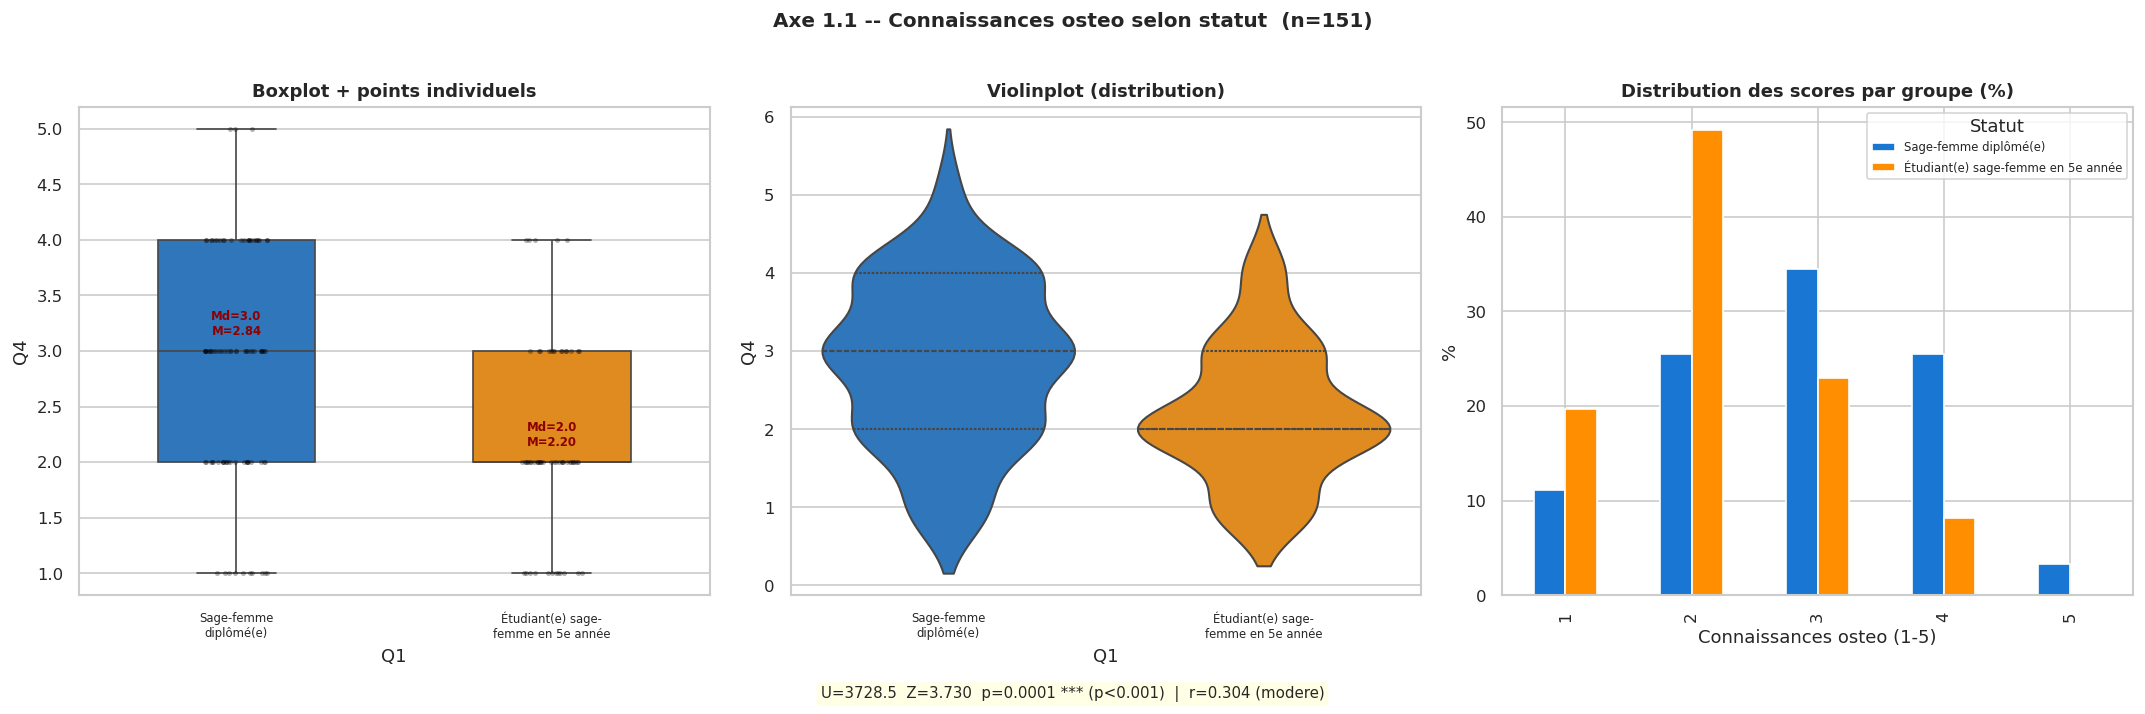

---


In [9]:
r = analyse('Q4','Q1', "Axe 1.1 -- Connaissances osteo selon statut", "Les connaissances different-elles entre etudiants et diplomes ?")
if r: results.append(r)

### Axe 1.1 -- Connaissances osteo selon anciennete

*Les SF experimentees connaissent-elles mieux l'osteopathie ?*

**Connaissances osteo (1-5)** x **Anciennete** | n = 90 | Test : Q2(nom,4grp) x Q4(ord) -> Kruskal-Wallis H

**Effectifs observes :**

Q4               1   2   3   4  5  Total
Q2                                      
2 à 5 ans        0   2   3   2  0      7
5 à 10 ans       3   4   5   3  0     15
Moins de 2 ans   2   2   3   2  0      9
Plus de 10 ans   5  15  20  16  3     59
Total           10  23  31  23  3     90

**Pourcentages en ligne (%) :**

Q4                 1     2     3     4    5
Q2                                         
2 à 5 ans        0.0  28.6  42.9  28.6  0.0
5 à 10 ans      20.0  26.7  33.3  20.0  0.0
Moins de 2 ans  22.2  22.2  33.3  22.2  0.0
Plus de 10 ans   8.5  25.4  33.9  27.1  5.1

**Statistiques par groupe :**

count  mean   std  min  25%  50%  75%  max
Q2                                                        
2 à 5 ans         7.0  3.00  0.82  2.0  2.5  3.0  3.5  4.0
5 à 10 ans       15.0  2.53  1.06  1.0  2.0  3.0  3.0  4.0
Moins de 2 ans    9.0  2.56  1.13  1.0  2.0  3.0  3.0  4.0
Plus de 10 ans   59.0  2.95  1.04  1.0  2.0  3.0  4.0  5.0

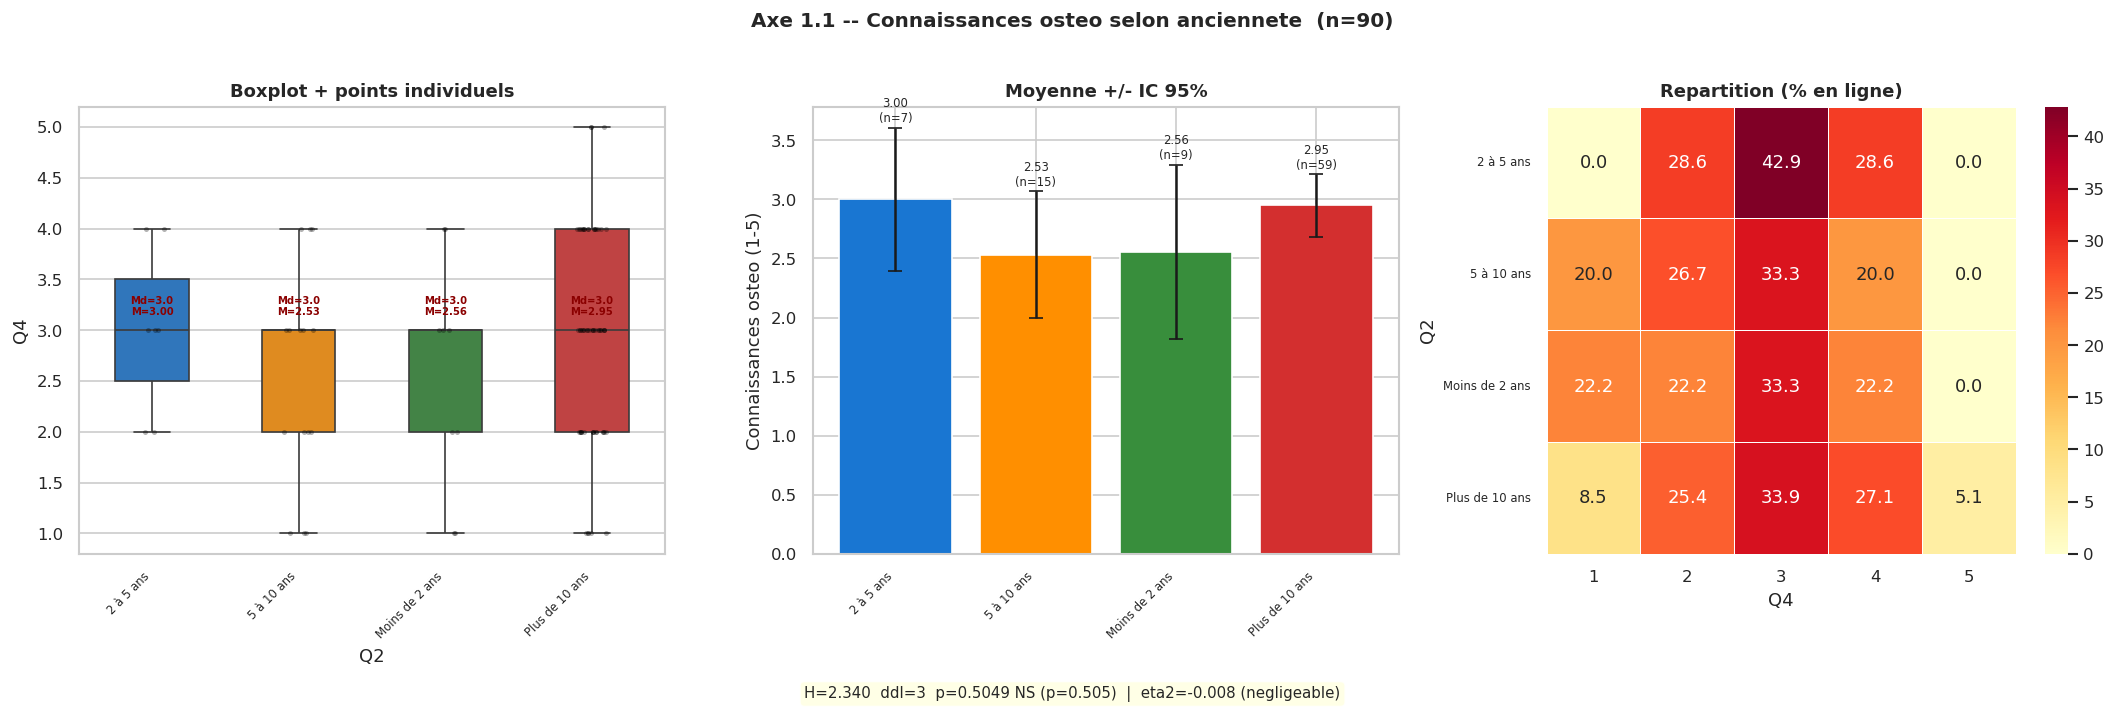

---


In [10]:
r = analyse('Q4','Q2', "Axe 1.1 -- Connaissances osteo selon anciennete", "Les SF experimentees connaissent-elles mieux l'osteopathie ?")
if r: results.append(r)

### Axe 1.1 -- Coherence sentiment info / connaissances

*Coherence entre connaissance objective et subjective ?*

**Sentiment info (1-5)** x **Connaissances osteo (1-5)** | n = 151 | Test : Q6(ord) x Q4(ord) -> Spearman

**Effectifs croises :**

Q4      1   2   3   4  5  Total
Q6                             
1      10  15   0   1  0     26
2       9  24   9   0  0     42
3       3   9  17   8  0     37
4       0   5  18  17  0     40
5       0   0   1   2  3      6
Total  22  53  45  28  3    151

**Pourcentages du total (%) :**

Q4    1     2     3     4    5
Q6                            
1   6.6   9.9   0.0   0.7  0.0
2   6.0  15.9   6.0   0.0  0.0
3   2.0   6.0  11.3   5.3  0.0
4   0.0   3.3  11.9  11.3  0.0
5   0.0   0.0   0.7   1.3  2.0

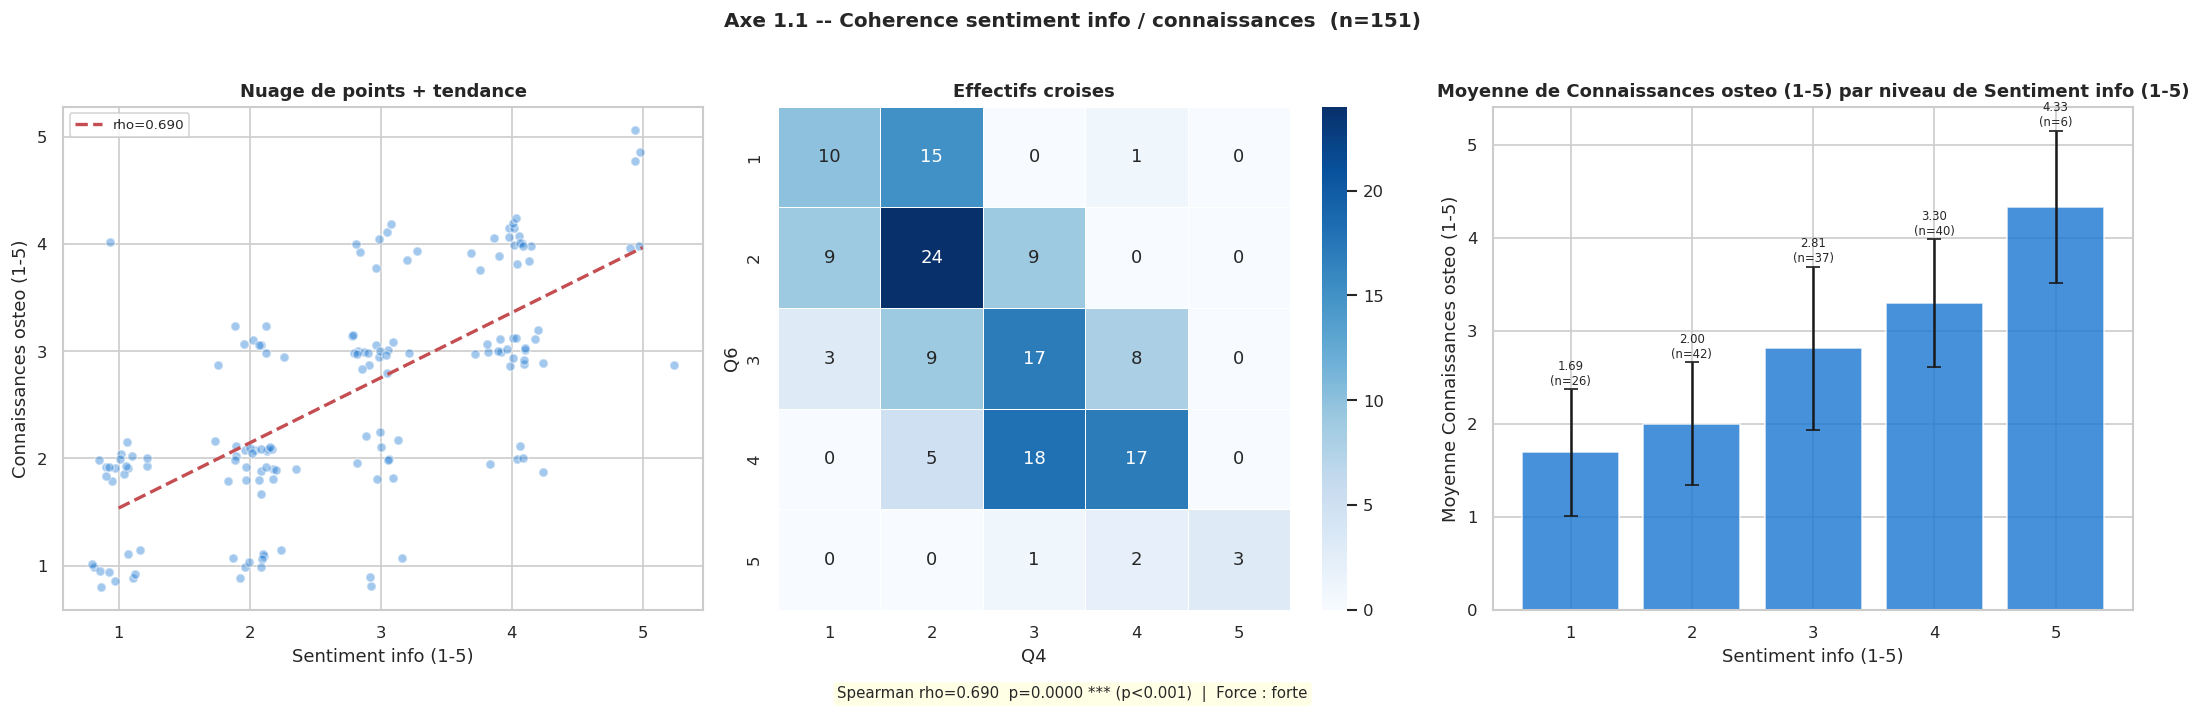

---


In [11]:
r = analyse('Q6','Q4', "Axe 1.1 -- Coherence sentiment info / connaissances", "Coherence entre connaissance objective et subjective ?")
if r: results.append(r)

### 1.2 Perception utilite et efficacite

### Axe 1.2 -- Utilite percue selon connaissances

*Plus on connait, plus on percoit l'utilite ?*

**Utilite osteo (1-5)** x **Connaissances osteo (1-5)** | n = 151 | Test : Q5(ord) x Q4(ord) -> Spearman

**Effectifs croises :**

Q4      1   2   3   4  5  Total
Q5                             
1       2   0   0   1  0      3
2       4   4   1   0  0      9
3       8  21   8   4  0     41
4       6  24  18  12  0     60
5       2   4  18  11  3     38
Total  22  53  45  28  3    151

**Pourcentages du total (%) :**

Q4    1     2     3    4    5
Q5                           
1   1.3   0.0   0.0  0.7  0.0
2   2.6   2.6   0.7  0.0  0.0
3   5.3  13.9   5.3  2.6  0.0
4   4.0  15.9  11.9  7.9  0.0
5   1.3   2.6  11.9  7.3  2.0

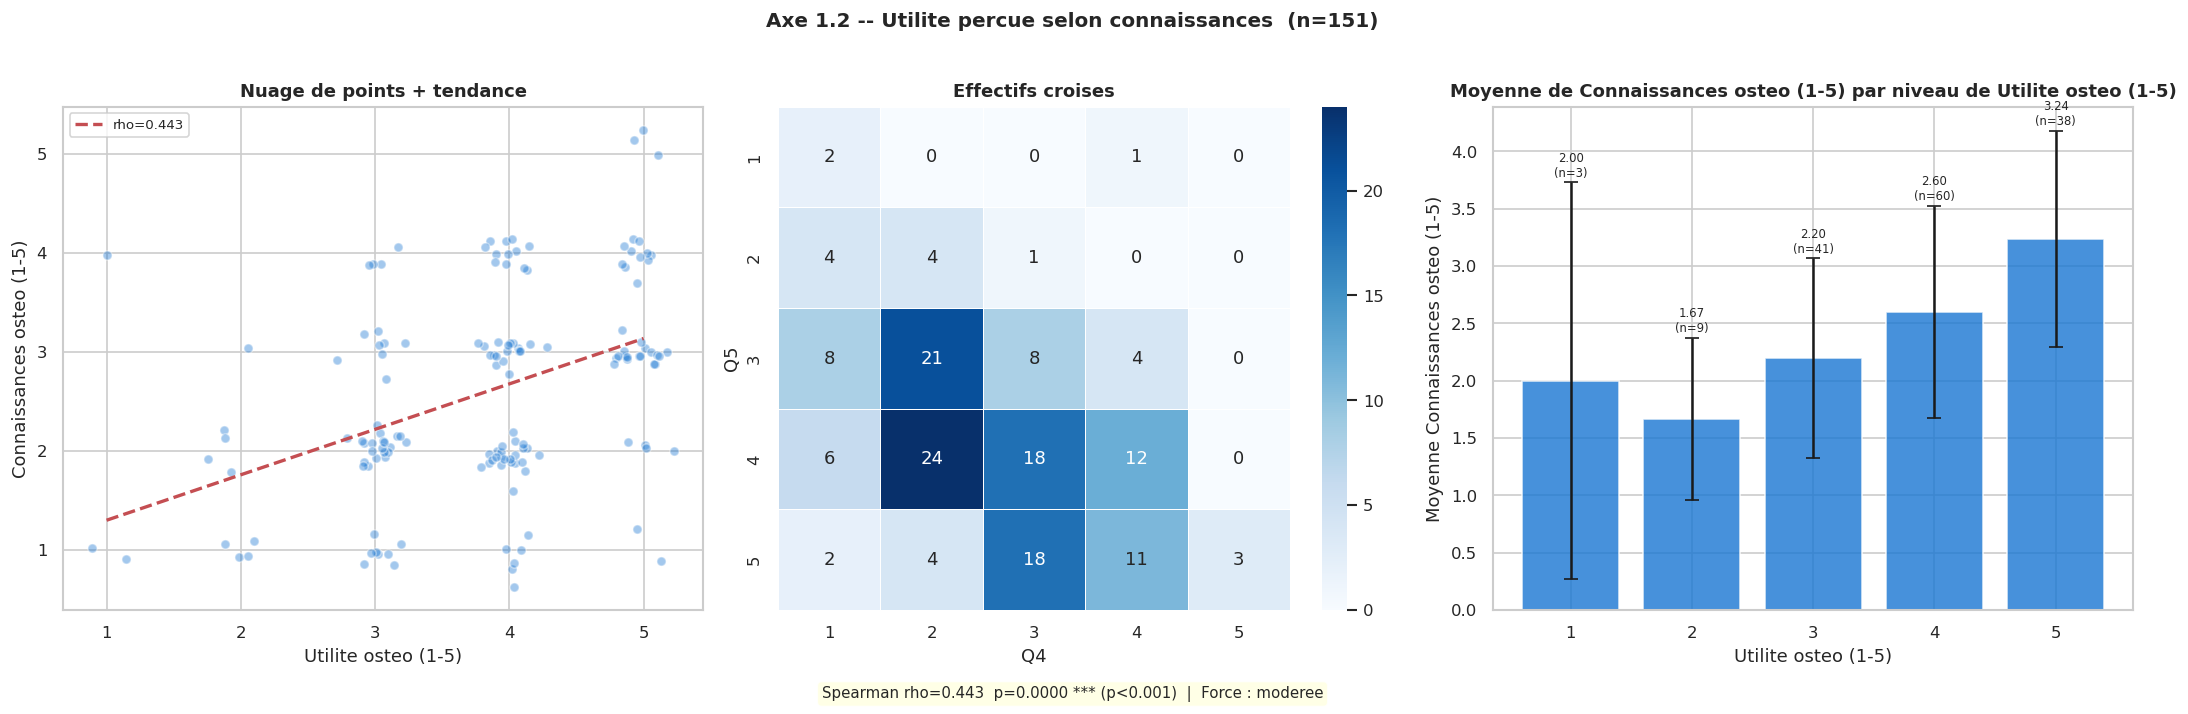

---


In [12]:
r = analyse('Q5','Q4', "Axe 1.2 -- Utilite percue selon connaissances", "Plus on connait, plus on percoit l'utilite ?")
if r: results.append(r)

### Axe 1.2 -- Coherence utilite / favorabilite

*Utilite et favorabilite sont-elles coherentes ?*

**Utilite osteo (1-5)** x **Favorabilite (1-5)** | n = 151 | Test : Q5(ord) x Q16(ord) -> Spearman

**Effectifs croises :**

Q16    1  2   3   4   5  Total
Q5                            
1      2  1   0   0   0      3
2      1  2   2   3   1      9
3      0  0  10  25   6     41
4      0  2   4  24  30     60
5      0  0   2  12  24     38
Total  3  5  18  64  61    151

**Pourcentages du total (%) :**

Q16    1    2    3     4     5
Q5                            
1    1.3  0.7  0.0   0.0   0.0
2    0.7  1.3  1.3   2.0   0.7
3    0.0  0.0  6.6  16.6   4.0
4    0.0  1.3  2.6  15.9  19.9
5    0.0  0.0  1.3   7.9  15.9

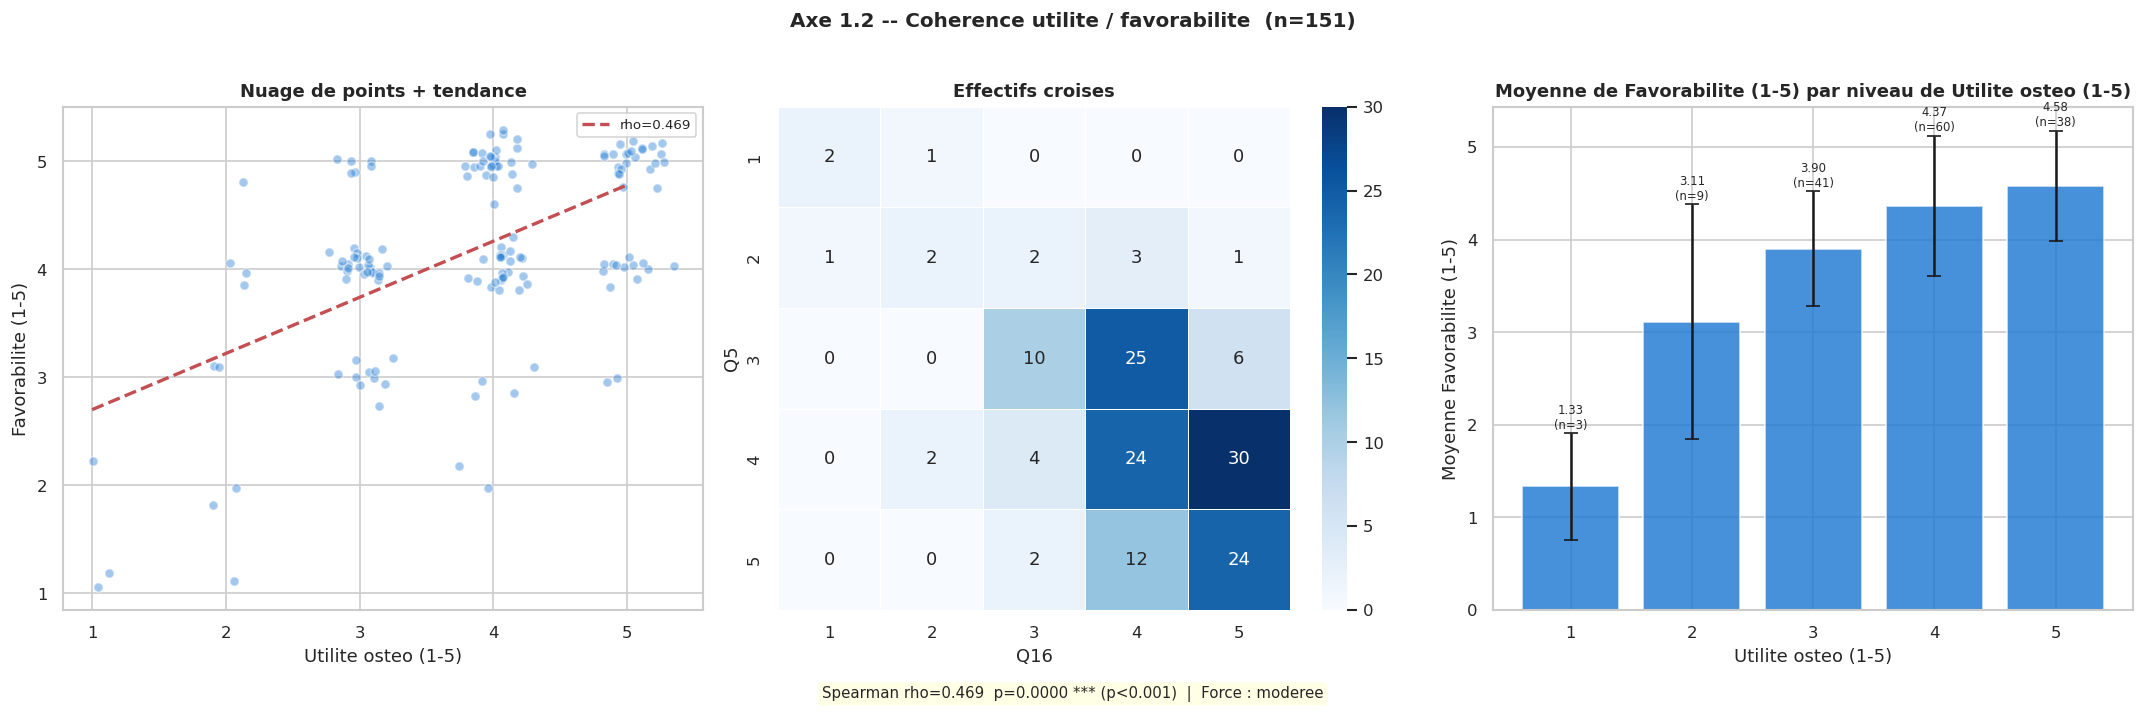

---


In [13]:
r = analyse('Q5','Q16', "Axe 1.2 -- Coherence utilite / favorabilite", "Utilite et favorabilite sont-elles coherentes ?")
if r: results.append(r)

### Axe 1.2 -- Favorabilite selon statut

*Le statut influence-t-il la favorabilite ?*

**Favorabilite (1-5)** x **Statut** | n = 151 | Test : Q1(nom,2grp) x Q16(ord) -> Mann-Whitney U

**Effectifs observes :**

Q16                                 1  2   3   4   5  Total
Q1                                                         
Sage-femme diplômé(e)               1  4  11  33  41     90
Étudiant(e) sage-femme en 5e année  2  1   7  31  20     61
Total                               3  5  18  64  61    151

**Pourcentages en ligne (%) :**

Q16                                   1    2     3     4     5
Q1                                                            
Sage-femme diplômé(e)               1.1  4.4  12.2  36.7  45.6
Étudiant(e) sage-femme en 5e année  3.3  1.6  11.5  50.8  32.8

**Statistiques par groupe :**

count  mean   std  min  25%  50%  75%  max
Q1                                                                            
Sage-femme diplômé(e)                90.0  4.21  0.91  1.0  4.0  4.0  5.0  5.0
Étudiant(e) sage-femme en 5e année   61.0  4.08  0.90  1.0  4.0  4.0  5.0  5.0

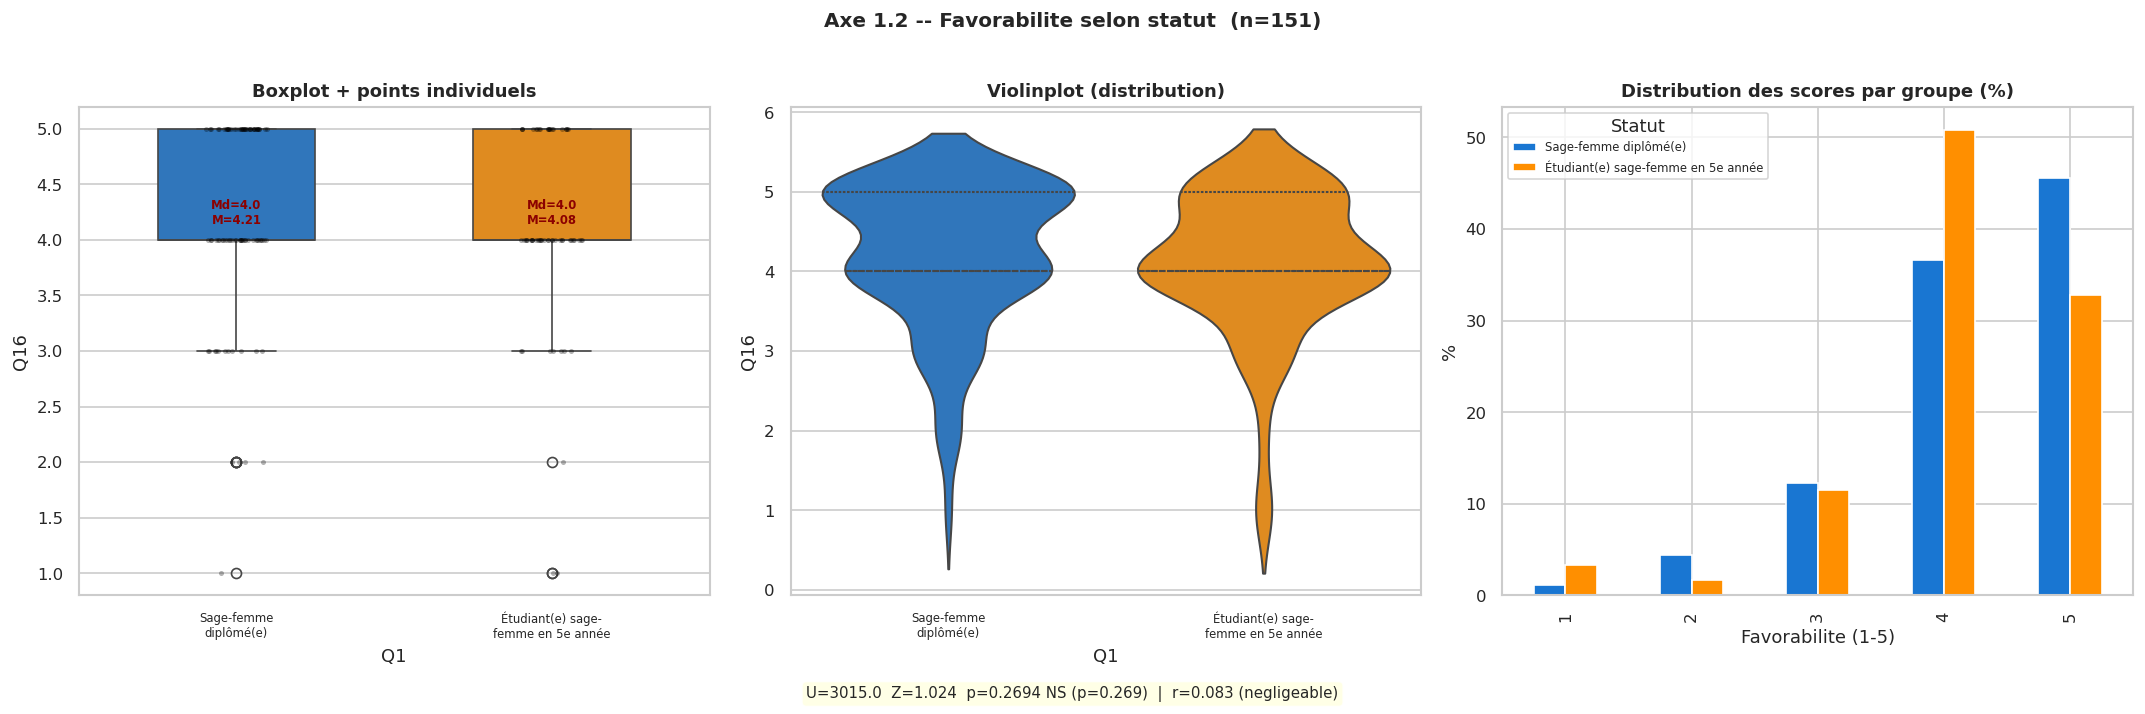

---


In [14]:
r = analyse('Q16','Q1', "Axe 1.2 -- Favorabilite selon statut", "Le statut influence-t-il la favorabilite ?")
if r: results.append(r)

### Axe 1.2 -- Moment orientation selon favorabilite

*Les plus favorables orientent-elles plus tot ?*

**Moment orientation** x **Favorabilite (1-5)** | n = 144 | Test : Q17(nom,5grp) x Q16(ord) -> Kruskal-Wallis H

**Effectifs observes :**

Q16                                                 1  2   3   4   5  Total
Q17                                                                        
Dès les premiers symptômes                          1  1   5  40  50     97
En cas d’absence de réussite d’autres prises en...  0  3  10  16   7     36
En fin de grossesse                                 0  0   1   5   3      9
En post-partum                                      0  0   0   1   0      1
Prise en charge prénatale et post-partum            0  0   0   0   1      1
Total                                               1  4  16  62  61    144

**Pourcentages en ligne (%) :**

Q16                                                   1    2     3      4  \
Q17                                                                         
Dès les premiers symptômes                          1.0  1.0   5.2   41.2   
En cas d’absence de réussite d’autres prises en...  0.0  8.3  27.8   44.4   
En fin de grossesse                                 0.0  0.0  11.1   55.6   
En post-partum                                      0.0  0.0   0.0  100.0   
Prise en charge prénatale et post-partum            0.0  0.0   0.0    0.0   

Q16                                                     5  
Q17                                                        
Dès les premiers symptômes                           51.5  
En cas d’absence de réussite d’autres prises en...   19.4  
En fin de grossesse                                  33.3  
En post-partum                                        0.0  
Prise en charge prénatale et post-partum            100.0

**Statistiques par groupe :**

count  mean   std  min  \
Q17                                                                          
Dès les premiers symptômes                           97.0  4.41  0.73  1.0   
En cas d’absence de réussite d’autres prises en...   36.0  3.75  0.87  2.0   
En fin de grossesse                                   9.0  4.22  0.67  3.0   
En post-partum                                        1.0  4.00   NaN  4.0   
Prise en charge prénatale et post-partum              1.0  5.00   NaN  5.0   

                                                    25%  50%  75%  max  
Q17                                                                     
Dès les premiers symptômes                          4.0  5.0  5.0  5.0  
En cas d’absence de réussite d’autres prises en...  3.0  4.0  4.0  5.0  
En fin de grossesse                                 4.0  4.0  5.0  5.0  
En post-partum                                      4.0  4.0  4.0  4.0  
Prise en charge prénatale et post-partum            5.0  5.0  5.0  5.0

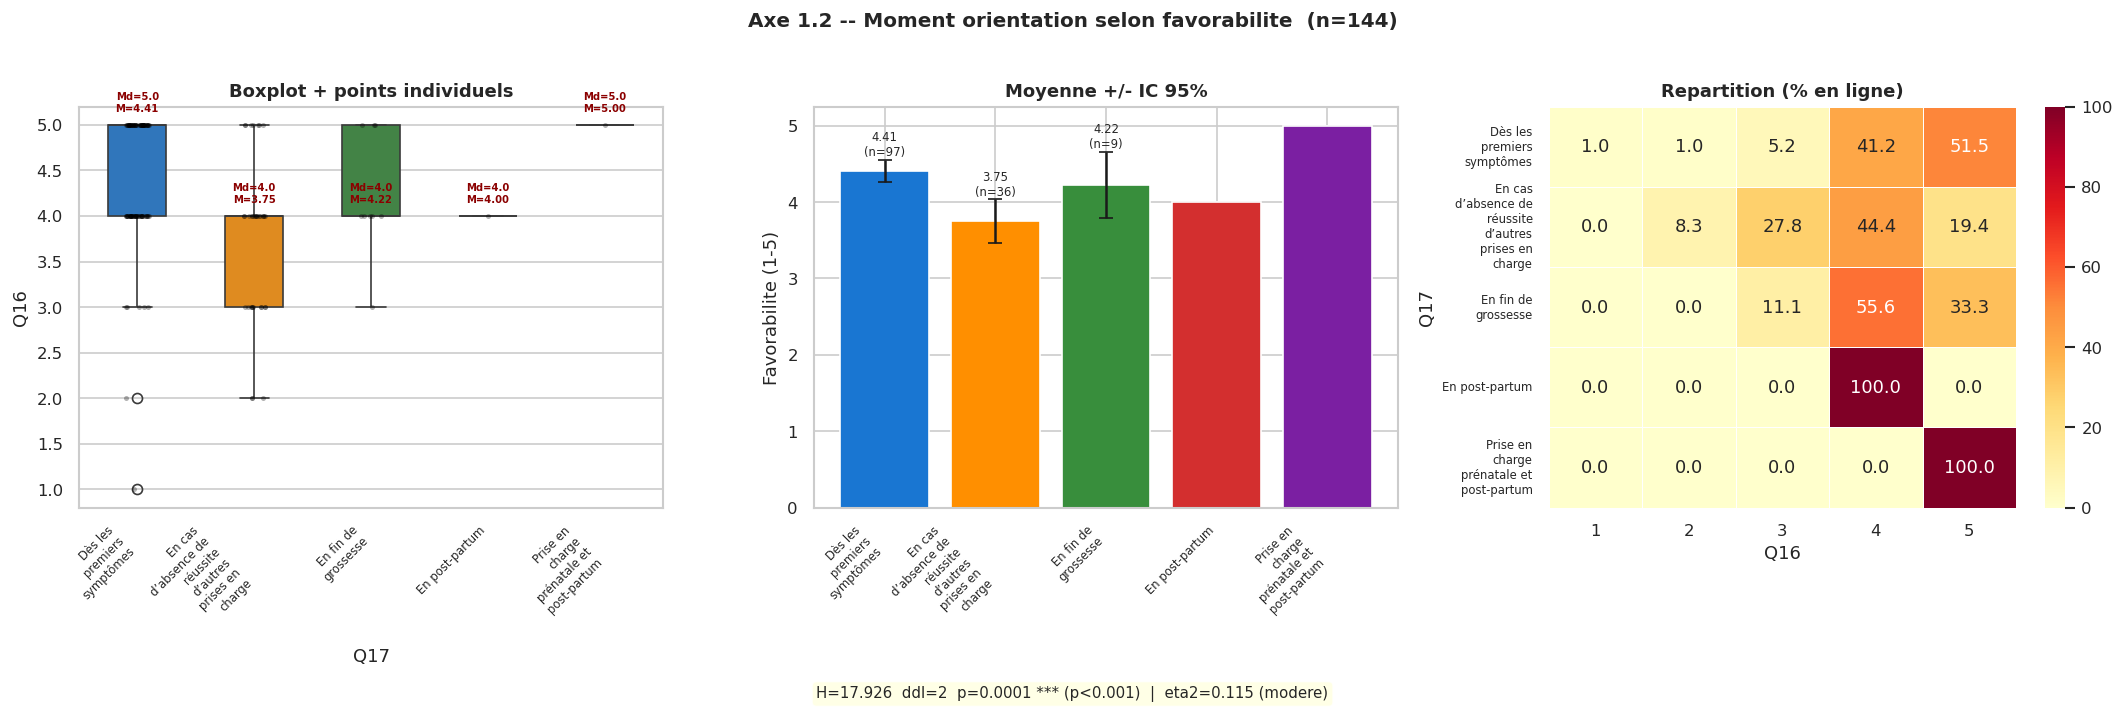

**Comparaisons post-hoc (Bonferroni) :**

Comp       U  p brut p Bonf.  \
0  Dès les premiers symptômes vs En cas d’absence...  2506.5  0.0000  0.0001   
1  Dès les premiers symptômes vs En fin de grossesse   517.5  0.3072  0.9216   
2  En cas d’absence de réussite d’autres prises e...   113.5  0.1449  0.4347   

  Sig.  
0  Oui  
1  Non  
2  Non

---


In [15]:
r = analyse('Q17','Q16', "Axe 1.2 -- Moment orientation selon favorabilite", "Les plus favorables orientent-elles plus tot ?")
if r: results.append(r)

### Axe 1.2 -- Classement osteo selon lieu exercice

*Priorites differentes liberal/hopital ?*

**Rang osteo (1-6)** x **Lieu exercice** | n = 87 | Test : Q3(nom,3grp) x Q15_osteo_rank(ord) -> Kruskal-Wallis H

**Effectifs observes :**

Q15_osteo_rank  1.0  2.0  3.0  4.0  Total
Q3                                       
Hospitalier      24   21    9    2     56
Libéral          20    7    1    0     28
Mixte             2    0    1    0      3
Total            46   28   11    2     87

**Pourcentages en ligne (%) :**

Q15_osteo_rank   1.0   2.0   3.0  4.0
Q3                                   
Hospitalier     42.9  37.5  16.1  3.6
Libéral         71.4  25.0   3.6  0.0
Mixte           66.7   0.0  33.3  0.0

**Statistiques par groupe :**

count  mean   std  min  25%  50%  75%  max
Q3                                                     
Hospitalier   56.0  1.80  0.84  1.0  1.0  2.0  2.0  4.0
Libéral       28.0  1.32  0.55  1.0  1.0  1.0  2.0  3.0
Mixte          3.0  1.67  1.15  1.0  1.0  1.0  2.0  3.0

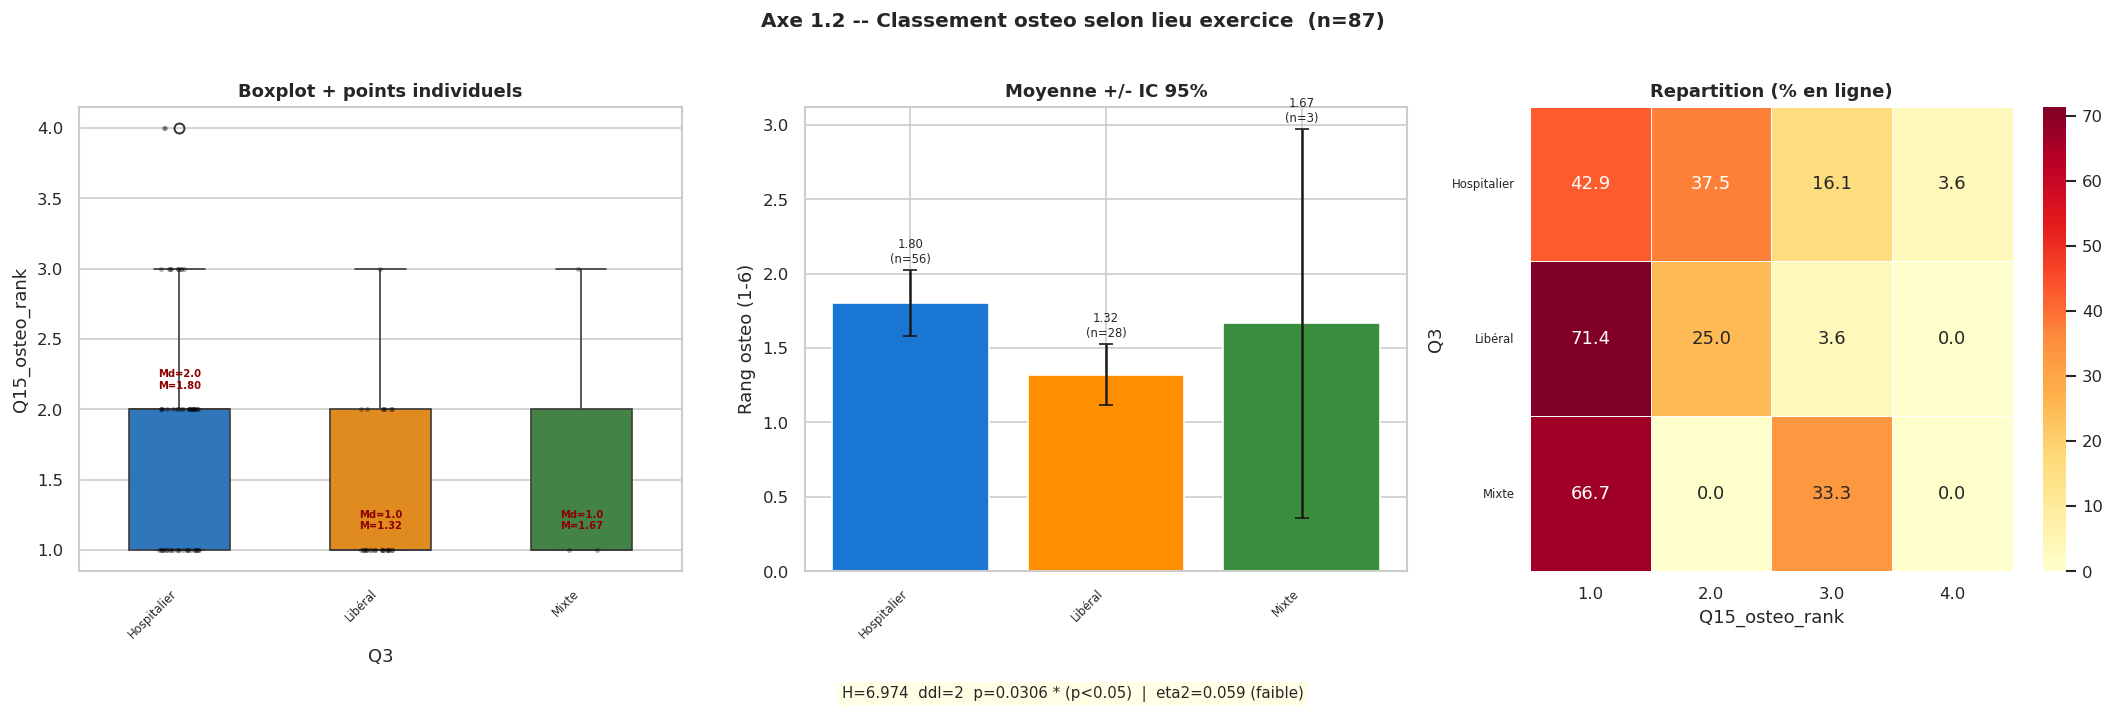

**Comparaisons post-hoc (Bonferroni) :**

Comp       U  p brut p Bonf. Sig.
0  Hospitalier vs Libéral  1037.0  0.0081  0.0242  Oui
1    Hospitalier vs Mixte    94.5  0.7106  1.0000  Non
2        Libéral vs Mixte    36.5  0.6742  1.0000  Non

---


In [16]:
r = analyse('Q15_osteo_rank','Q3', "Axe 1.2 -- Classement osteo selon lieu exercice", "Priorites differentes liberal/hopital ?")
if r: results.append(r)

### 1.3 Facteurs influencant les representations

### Axe 1.3 -- Favorabilite selon anciennete

*L'anciennete influence-t-elle la favorabilite ?*

**Favorabilite (1-5)** x **Anciennete** | n = 90 | Test : Q2(nom,4grp) x Q16(ord) -> Kruskal-Wallis H

**Effectifs observes :**

Q16             1  2   3   4   5  Total
Q2                                     
2 à 5 ans       0  0   1   3   3      7
5 à 10 ans      0  0   0   8   7     15
Moins de 2 ans  1  0   1   3   4      9
Plus de 10 ans  0  4   9  19  27     59
Total           1  4  11  33  41     90

**Pourcentages en ligne (%) :**

Q16                1    2     3     4     5
Q2                                         
2 à 5 ans        0.0  0.0  14.3  42.9  42.9
5 à 10 ans       0.0  0.0   0.0  53.3  46.7
Moins de 2 ans  11.1  0.0  11.1  33.3  44.4
Plus de 10 ans   0.0  6.8  15.3  32.2  45.8

**Statistiques par groupe :**

count  mean   std  min  25%  50%  75%  max
Q2                                                        
2 à 5 ans         7.0  4.29  0.76  3.0  4.0  4.0  5.0  5.0
5 à 10 ans       15.0  4.47  0.52  4.0  4.0  4.0  5.0  5.0
Moins de 2 ans    9.0  4.00  1.32  1.0  4.0  4.0  5.0  5.0
Plus de 10 ans   59.0  4.17  0.93  2.0  4.0  4.0  5.0  5.0

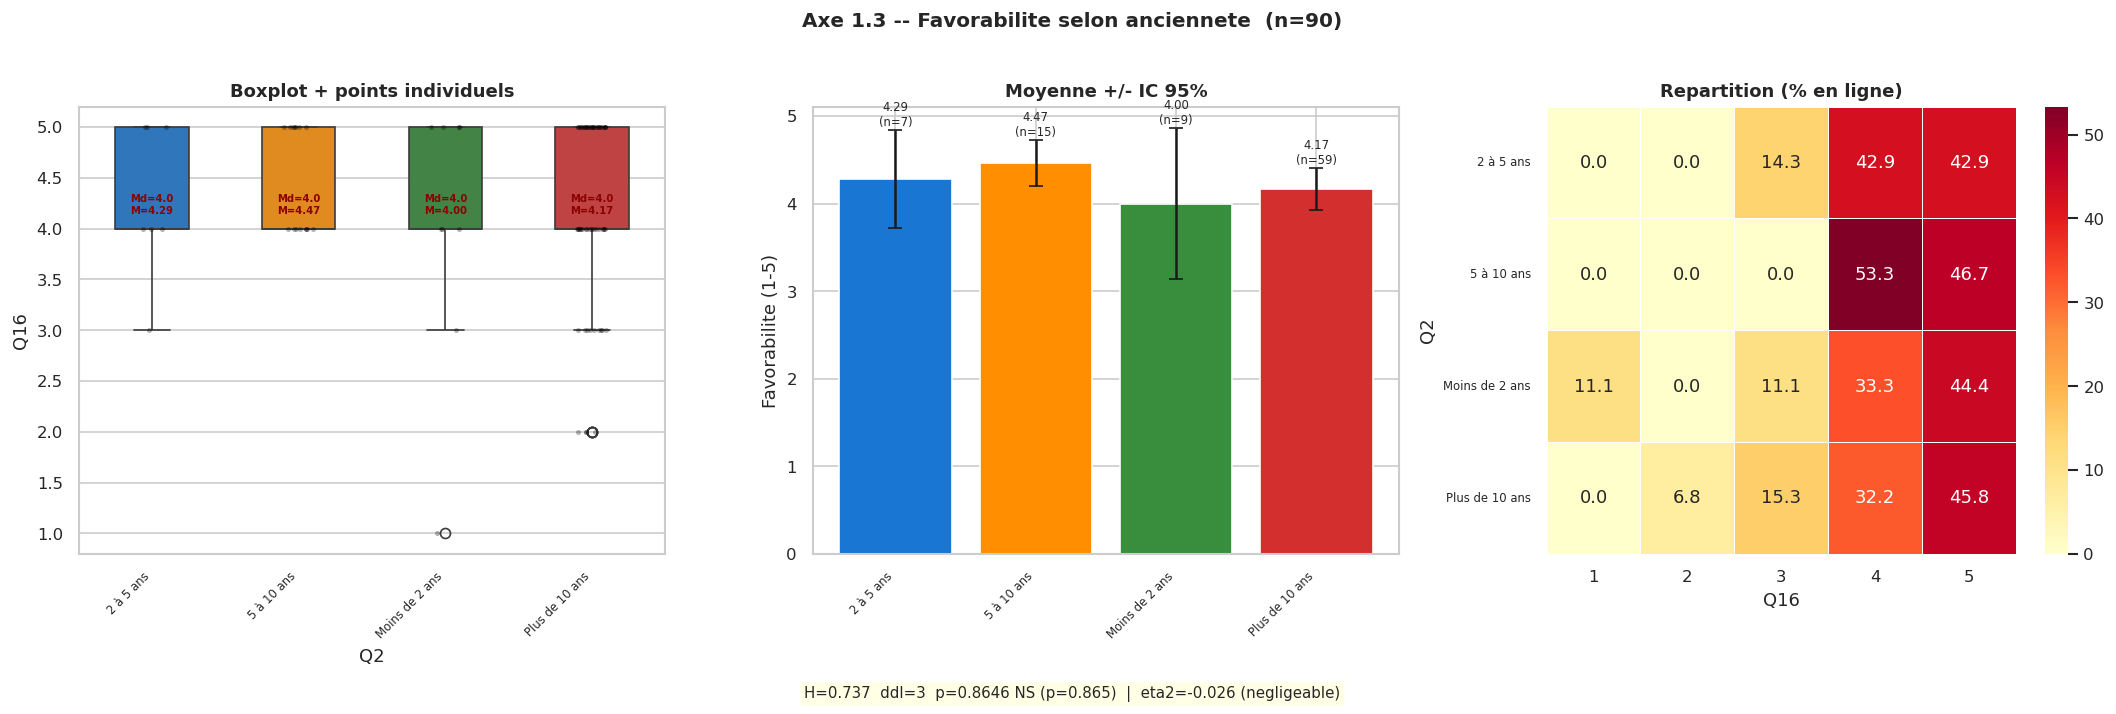

---


In [17]:
r = analyse('Q16','Q2', "Axe 1.3 -- Favorabilite selon anciennete", "L'anciennete influence-t-elle la favorabilite ?")
if r: results.append(r)

### Axe 1.3 -- Connaissances selon lieu exercice

*Le lieu influence-t-il les connaissances ?*

**Connaissances osteo (1-5)** x **Lieu exercice** | n = 90 | Test : Q3(nom,3grp) x Q4(ord) -> Kruskal-Wallis H

**Effectifs observes :**

Q4            1   2   3   4  5  Total
Q3                                   
Hospitalier   9  16  19  12  1     57
Libéral       1   7  11   9  2     30
Mixte         1   0   0   2  0      3
Total        11  23  30  23  3     90

**Pourcentages en ligne (%) :**

Q4              1     2     3     4    5
Q3                                      
Hospitalier  15.8  28.1  33.3  21.1  1.8
Libéral       3.3  23.3  36.7  30.0  6.7
Mixte        33.3   0.0   0.0  66.7  0.0

**Statistiques par groupe :**

count  mean   std  min   25%  50%  75%  max
Q3                                                      
Hospitalier   57.0  2.65  1.04  1.0  2.00  3.0  3.0  5.0
Libéral       30.0  3.13  0.97  1.0  2.25  3.0  4.0  5.0
Mixte          3.0  3.00  1.73  1.0  2.50  4.0  4.0  4.0

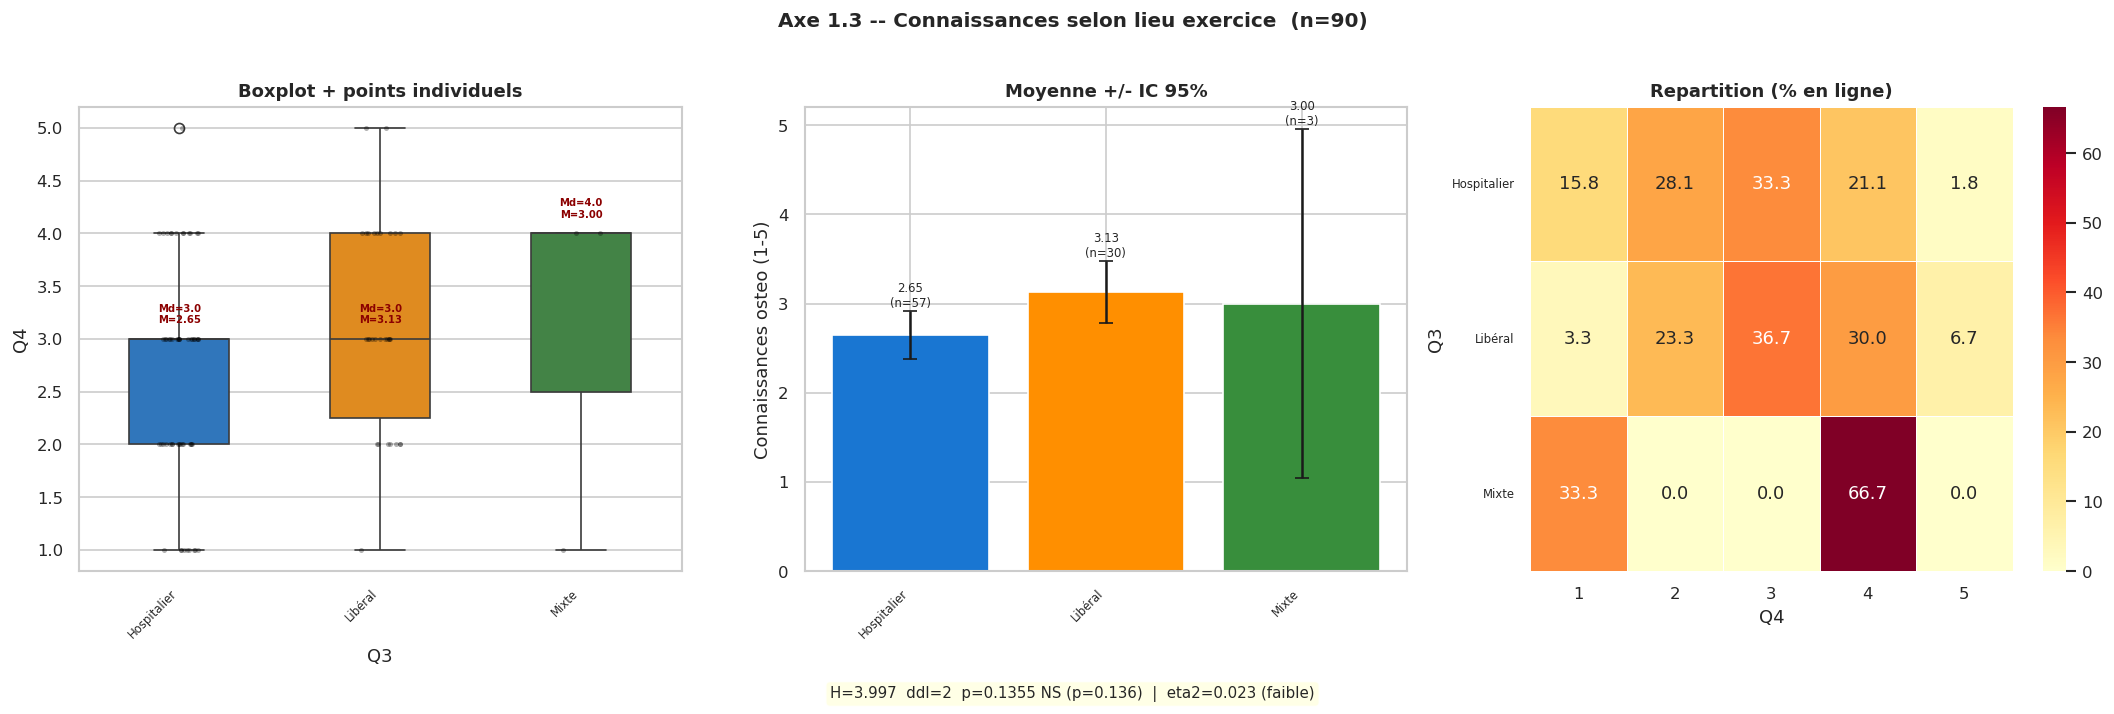

---


In [18]:
r = analyse('Q4','Q3', "Axe 1.3 -- Connaissances selon lieu exercice", "Le lieu influence-t-il les connaissances ?")
if r: results.append(r)

---
## AXE 2 : PLACE ACCORDEE A L'OSTEOPATHIE
### 2.1 Place dans la PEC du SdL

### Axe 2.1 -- Orientation selon frequence SdL

*Plus on voit le SdL, mieux on oriente ?*

**Moment orientation** x **Frequence SdL** | n = 142 | Test : Q17(nom) x Q12(nom) -> Chi-deux

**Effectifs observes :**

Q12                                                 A chaque suivi  \
Q17                                                                  
Dès les premiers symptômes                                       1   
En cas d’absence de réussite d’autres prises en...               0   
En fin de grossesse                                              0   
En post-partum                                                   0   
Prise en charge prénatale et post-partum                         0   
Total                                                            1   

Q12                                                 Fréquemment (> ou = à 1 fois par semaine)  \
Q17                                                                                             
Dès les premiers symptômes                                                                 40   
En cas d’absence de réussite d’autres prises en...                                         17   
En fin de grossesse                                                                         8   
En post-partum                                                                              0   
Prise en charge prénatale et post-partum                                                    0   
Total                                                                                      65   

Q12                                                 Jamais  \
Q17                                                          
Dès les premiers symptômes                               1   
En cas d’absence de réussite d’autres prises en...       2   
En fin de grossesse                                      0   
En post-partum                                           0   
Prise en charge prénatale et post-partum                 0   
Total                                                    3   

Q12                                                 Occasionnellement (> ou = à 1 fois par mois)  \
Q17                                                                                                
Dès les premiers symptômes                                                                    39   
En cas d’absence de réussite d’autres prises en...                                            10   
En fin de grossesse                                                                            1   
En post-partum                                                                                 0   
Prise en charge prénatale et post-partum                                                       0   
Total                                                                                         50   

Q12                                                 Rarement (> ou = à 1 fois tous les 3 mois)  \
Q17                                                                                              
Dès les premiers symptômes                                                                  14   
En cas d’absence de réussite d’autres prises en...                                           7   
En fin de grossesse                                                                          0   
En post-partum                                                                               1   
Prise en charge prénatale et post-partum                                                     1   
Total                                                                                       23   

Q12                                                 Total  
Q17                                                        
Dès les premiers symptômes                             95  
En cas d’absence de réussite d’autres prises en...     36  
En fin de grossesse                                     9  
En post-partum                                          1  
Prise en charge prénatale et post-partum                1  
Total                                                 142

**Pourcentages en colonne (%) :**

Q12                                                 A chaque suivi  \
Q17                                                                  
Dès les premiers symptômes                                   100.0   
En cas d’absence de réussite d’autres prises en...             0.0   
En fin de grossesse                                            0.0   
En post-partum                                                 0.0   
Prise en charge prénatale et post-partum                       0.0   

Q12                                                 Fréquemment (> ou = à 1 fois par semaine)  \
Q17                                                                                             
Dès les premiers symptômes                                                               61.5   
En cas d’absence de réussite d’autres prises en...                                       26.2   
En fin de grossesse                                                                      12.3   
En post-partum                                                                            0.0   
Prise en charge prénatale et post-partum                                                  0.0   

Q12                                                 Jamais  \
Q17                                                          
Dès les premiers symptômes                            33.3   
En cas d’absence de réussite d’autres prises en...    66.7   
En fin de grossesse                                    0.0   
En post-partum                                         0.0   
Prise en charge prénatale et post-partum               0.0   

Q12                                                 Occasionnellement (> ou = à 1 fois par mois)  \
Q17                                                                                                
Dès les premiers symptômes                                                                  78.0   
En cas d’absence de réussite d’autres prises en...                                          20.0   
En fin de grossesse                                                                          2.0   
En post-partum                                                                               0.0   
Prise en charge prénatale et post-partum                                                     0.0   

Q12                                                 Rarement (> ou = à 1 fois tous les 3 mois)  
Q17                                                                                             
Dès les premiers symptômes                                                                60.9  
En cas d’absence de réussite d’autres prises en...                                        30.4  
En fin de grossesse                                                                        0.0  
En post-partum                                                                             4.3  
Prise en charge prénatale et post-partum                                                   4.3

**Pourcentages en ligne (%) :**

Q12                                                 A chaque suivi  \
Q17                                                                  
Dès les premiers symptômes                                     1.1   
En cas d’absence de réussite d’autres prises en...             0.0   
En fin de grossesse                                            0.0   
En post-partum                                                 0.0   
Prise en charge prénatale et post-partum                       0.0   

Q12                                                 Fréquemment (> ou = à 1 fois par semaine)  \
Q17                                                                                             
Dès les premiers symptômes                                                               42.1   
En cas d’absence de réussite d’autres prises en...                                       47.2   
En fin de grossesse                                                                      88.9   
En post-partum                                                                            0.0   
Prise en charge prénatale et post-partum                                                  0.0   

Q12                                                 Jamais  \
Q17                                                          
Dès les premiers symptômes                             1.1   
En cas d’absence de réussite d’autres prises en...     5.6   
En fin de grossesse                                    0.0   
En post-partum                                         0.0   
Prise en charge prénatale et post-partum               0.0   

Q12                                                 Occasionnellement (> ou = à 1 fois par mois)  \
Q17                                                                                                
Dès les premiers symptômes                                                                  41.1   
En cas d’absence de réussite d’autres prises en...                                          27.8   
En fin de grossesse                                                                         11.1   
En post-partum                                                                               0.0   
Prise en charge prénatale et post-partum                                                     0.0   

Q12                                                 Rarement (> ou = à 1 fois tous les 3 mois)  
Q17                                                                                             
Dès les premiers symptômes                                                                14.7  
En cas d’absence de réussite d’autres prises en...                                        19.4  
En fin de grossesse                                                                        0.0  
En post-partum                                                                           100.0  
Prise en charge prénatale et post-partum                                                 100.0

**Effectifs theoriques :**

Q12                                                 A chaque suivi  \
Q17                                                                  
Dès les premiers symptômes                                     0.7   
En cas d’absence de réussite d’autres prises en...             0.3   
En fin de grossesse                                            0.1   
En post-partum                                                 0.0   
Prise en charge prénatale et post-partum                       0.0   

Q12                                                 Fréquemment (> ou = à 1 fois par semaine)  \
Q17                                                                                             
Dès les premiers symptômes                                                               43.5   
En cas d’absence de réussite d’autres prises en...                                       16.5   
En fin de grossesse                                                                       4.1   
En post-partum                                                                            0.5   
Prise en charge prénatale et post-partum                                                  0.5   

Q12                                                 Jamais  \
Q17                                                          
Dès les premiers symptômes                             2.0   
En cas d’absence de réussite d’autres prises en...     0.8   
En fin de grossesse                                    0.2   
En post-partum                                         0.0   
Prise en charge prénatale et post-partum               0.0   

Q12                                                 Occasionnellement (> ou = à 1 fois par mois)  \
Q17                                                                                                
Dès les premiers symptômes                                                                  33.5   
En cas d’absence de réussite d’autres prises en...                                          12.7   
En fin de grossesse                                                                          3.2   
En post-partum                                                                               0.4   
Prise en charge prénatale et post-partum                                                     0.4   

Q12                                                 Rarement (> ou = à 1 fois tous les 3 mois)  
Q17                                                                                             
Dès les premiers symptômes                                                                15.4  
En cas d’absence de réussite d’autres prises en...                                         5.8  
En fin de grossesse                                                                        1.5  
En post-partum                                                                             0.2  
Prise en charge prénatale et post-partum                                                   0.2

**Attention : 76% des effectifs theoriques < 5.**

**Residus standardises (contributions au Chi2) :**

Q12                                                 A chaque suivi  \
Q17                                                                  
Dès les premiers symptômes                                    0.40   
En cas d’absence de réussite d’autres prises en...           -0.50   
En fin de grossesse                                          -0.25   
En post-partum                                               -0.08   
Prise en charge prénatale et post-partum                     -0.08   

Q12                                                 Fréquemment (> ou = à 1 fois par semaine)  \
Q17                                                                                             
Dès les premiers symptômes                                                              -0.53   
En cas d’absence de réussite d’autres prises en...                                       0.13   
En fin de grossesse                                                                      1.91   
En post-partum                                                                          -0.68   
Prise en charge prénatale et post-partum                                                -0.68   

Q12                                                 Jamais  \
Q17                                                          
Dès les premiers symptômes                           -0.71   
En cas d’absence de réussite d’autres prises en...    1.42   
En fin de grossesse                                  -0.44   
En post-partum                                       -0.15   
Prise en charge prénatale et post-partum             -0.15   

Q12                                                 Occasionnellement (> ou = à 1 fois par mois)  \
Q17                                                                                                
Dès les premiers symptômes                                                                  0.96   
En cas d’absence de réussite d’autres prises en...                                         -0.75   
En fin de grossesse                                                                        -1.22   
En post-partum                                                                             -0.59   
Prise en charge prénatale et post-partum                                                   -0.59   

Q12                                                 Rarement (> ou = à 1 fois tous les 3 mois)  
Q17                                                                                             
Dès les premiers symptômes                                                               -0.35  
En cas d’absence de réussite d’autres prises en...                                        0.48  
En fin de grossesse                                                                      -1.21  
En post-partum                                                                            2.08  
Prise en charge prénatale et post-partum                                                  2.08

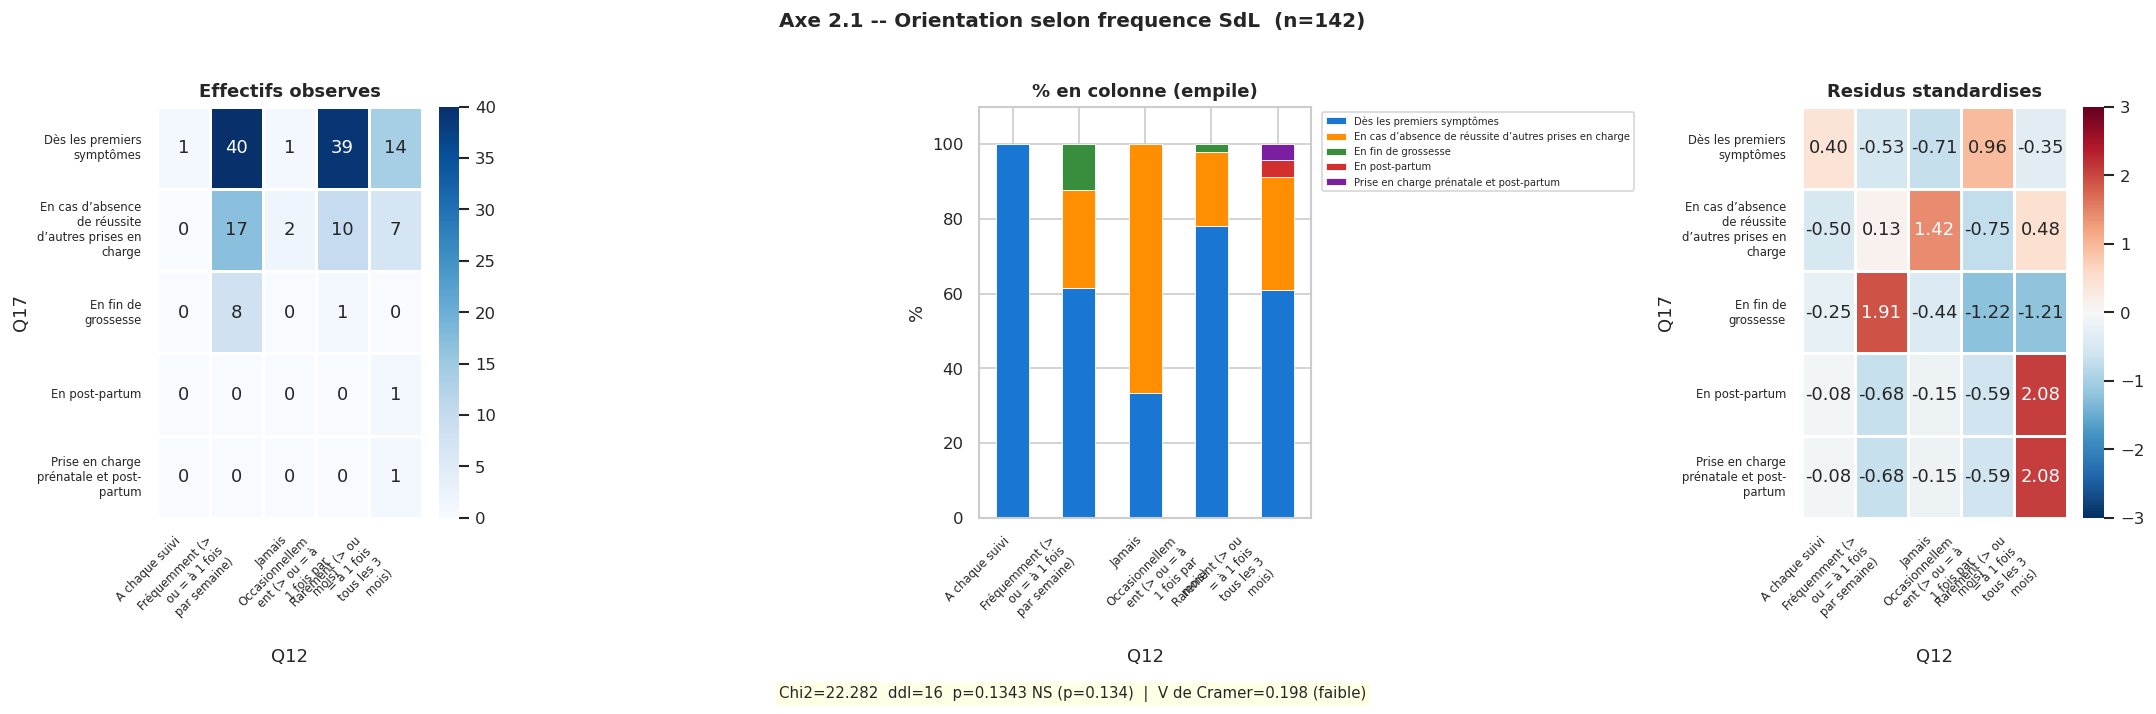

---


In [19]:
r = analyse('Q17','Q12', "Axe 2.1 -- Orientation selon frequence SdL", "Plus on voit le SdL, mieux on oriente ?")
if r: results.append(r)

### Axe 2.1 -- Orientation selon collaboration

*La collaboration favorise-t-elle orientation precoce ?*

**Moment orientation** x **Collaboration (Oui/Non)** | n = 144 | Test : Q17(nom) x Q8_bin(nom) -> Chi-deux

**Effectifs observes :**

Q8_bin                                              Non  Oui  Total
Q17                                                                
Dès les premiers symptômes                           27   70     97
En cas d’absence de réussite d’autres prises en...   12   24     36
En fin de grossesse                                   2    7      9
En post-partum                                        1    0      1
Prise en charge prénatale et post-partum              0    1      1
Total                                                42  102    144

**Pourcentages en colonne (%) :**

Q8_bin                                               Non   Oui
Q17                                                           
Dès les premiers symptômes                          64.3  68.6
En cas d’absence de réussite d’autres prises en...  28.6  23.5
En fin de grossesse                                  4.8   6.9
En post-partum                                       2.4   0.0
Prise en charge prénatale et post-partum             0.0   1.0

**Pourcentages en ligne (%) :**

Q8_bin                                                Non    Oui
Q17                                                             
Dès les premiers symptômes                           27.8   72.2
En cas d’absence de réussite d’autres prises en...   33.3   66.7
En fin de grossesse                                  22.2   77.8
En post-partum                                      100.0    0.0
Prise en charge prénatale et post-partum              0.0  100.0

**Effectifs theoriques :**

Q8_bin                                               Non   Oui
Q17                                                           
Dès les premiers symptômes                          28.3  68.7
En cas d’absence de réussite d’autres prises en...  10.5  25.5
En fin de grossesse                                  2.6   6.4
En post-partum                                       0.3   0.7
Prise en charge prénatale et post-partum             0.3   0.7

**Attention : 50% des effectifs theoriques < 5.**

**Residus standardises (contributions au Chi2) :**

Q8_bin                                               Non   Oui
Q17                                                           
Dès les premiers symptômes                         -0.24  0.16
En cas d’absence de réussite d’autres prises en...  0.46 -0.30
En fin de grossesse                                -0.39  0.25
En post-partum                                      1.31 -0.84
Prise en charge prénatale et post-partum           -0.54  0.35

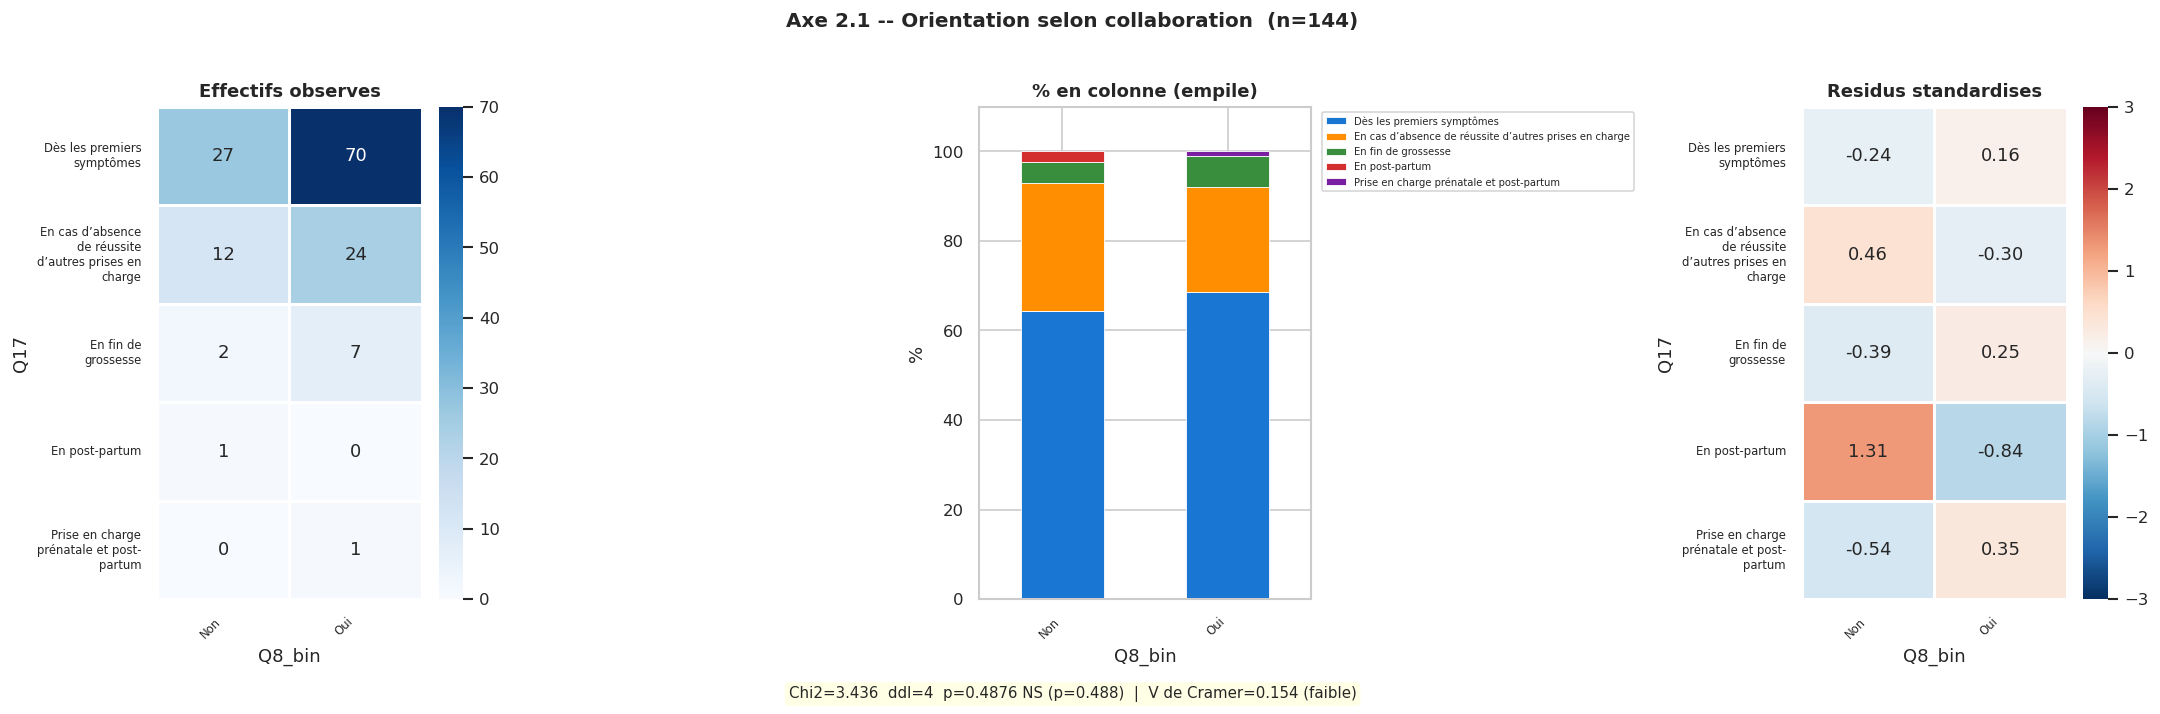

---


In [20]:
r = analyse('Q17','Q8_bin', "Axe 2.1 -- Orientation selon collaboration", "La collaboration favorise-t-elle orientation precoce ?")
if r: results.append(r)

### 2.2 Place dans la pratique globale

### Axe 2.2 -- Collaboration selon lieu exercice

*Qui collabore le plus ?*

**Collaboration (detail)** x **Lieu exercice** | n = 90 | Test : Q8(nom) x Q3(nom) -> Chi-deux

**Effectifs observes :**

Q3                                                 Hospitalier  Libéral  \
Q8                                                                        
Non                                                         25        0   
Oui, occasionnellement (> ou = à 1 fois par mois)           10        8   
Oui, rarement (< à 1 fois par mois)                         11        1   
Oui, régulièrement (> ou = à 1 fois par semaine)            11       21   
Total                                                       57       30   

Q3                                                 Mixte  Total  
Q8                                                               
Non                                                    1     26  
Oui, occasionnellement (> ou = à 1 fois par mois)      1     19  
Oui, rarement (< à 1 fois par mois)                    1     13  
Oui, régulièrement (> ou = à 1 fois par semaine)       0     32  
Total                                                  3     90

**Pourcentages en colonne (%) :**

Q3                                                 Hospitalier  Libéral  Mixte
Q8                                                                            
Non                                                       43.9      0.0   33.3
Oui, occasionnellement (> ou = à 1 fois par mois)         17.5     26.7   33.3
Oui, rarement (< à 1 fois par mois)                       19.3      3.3   33.3
Oui, régulièrement (> ou = à 1 fois par semaine)          19.3     70.0    0.0

**Pourcentages en ligne (%) :**

Q3                                                 Hospitalier  Libéral  Mixte
Q8                                                                            
Non                                                       96.2      0.0    3.8
Oui, occasionnellement (> ou = à 1 fois par mois)         52.6     42.1    5.3
Oui, rarement (< à 1 fois par mois)                       84.6      7.7    7.7
Oui, régulièrement (> ou = à 1 fois par semaine)          34.4     65.6    0.0

**Effectifs theoriques :**

Q3                                                 Hospitalier  Libéral  Mixte
Q8                                                                            
Non                                                       16.5      8.7    0.9
Oui, occasionnellement (> ou = à 1 fois par mois)         12.0      6.3    0.6
Oui, rarement (< à 1 fois par mois)                        8.2      4.3    0.4
Oui, régulièrement (> ou = à 1 fois par semaine)          20.3     10.7    1.1

**Attention : 42% des effectifs theoriques < 5.**

**Residus standardises (contributions au Chi2) :**

Q3                                                 Hospitalier  Libéral  Mixte
Q8                                                                            
Non                                                       2.10    -2.94   0.14
Oui, occasionnellement (> ou = à 1 fois par mois)        -0.59     0.66   0.46
Oui, rarement (< à 1 fois par mois)                       0.96    -1.60   0.86
Oui, régulièrement (> ou = à 1 fois par semaine)         -2.06     3.16  -1.03

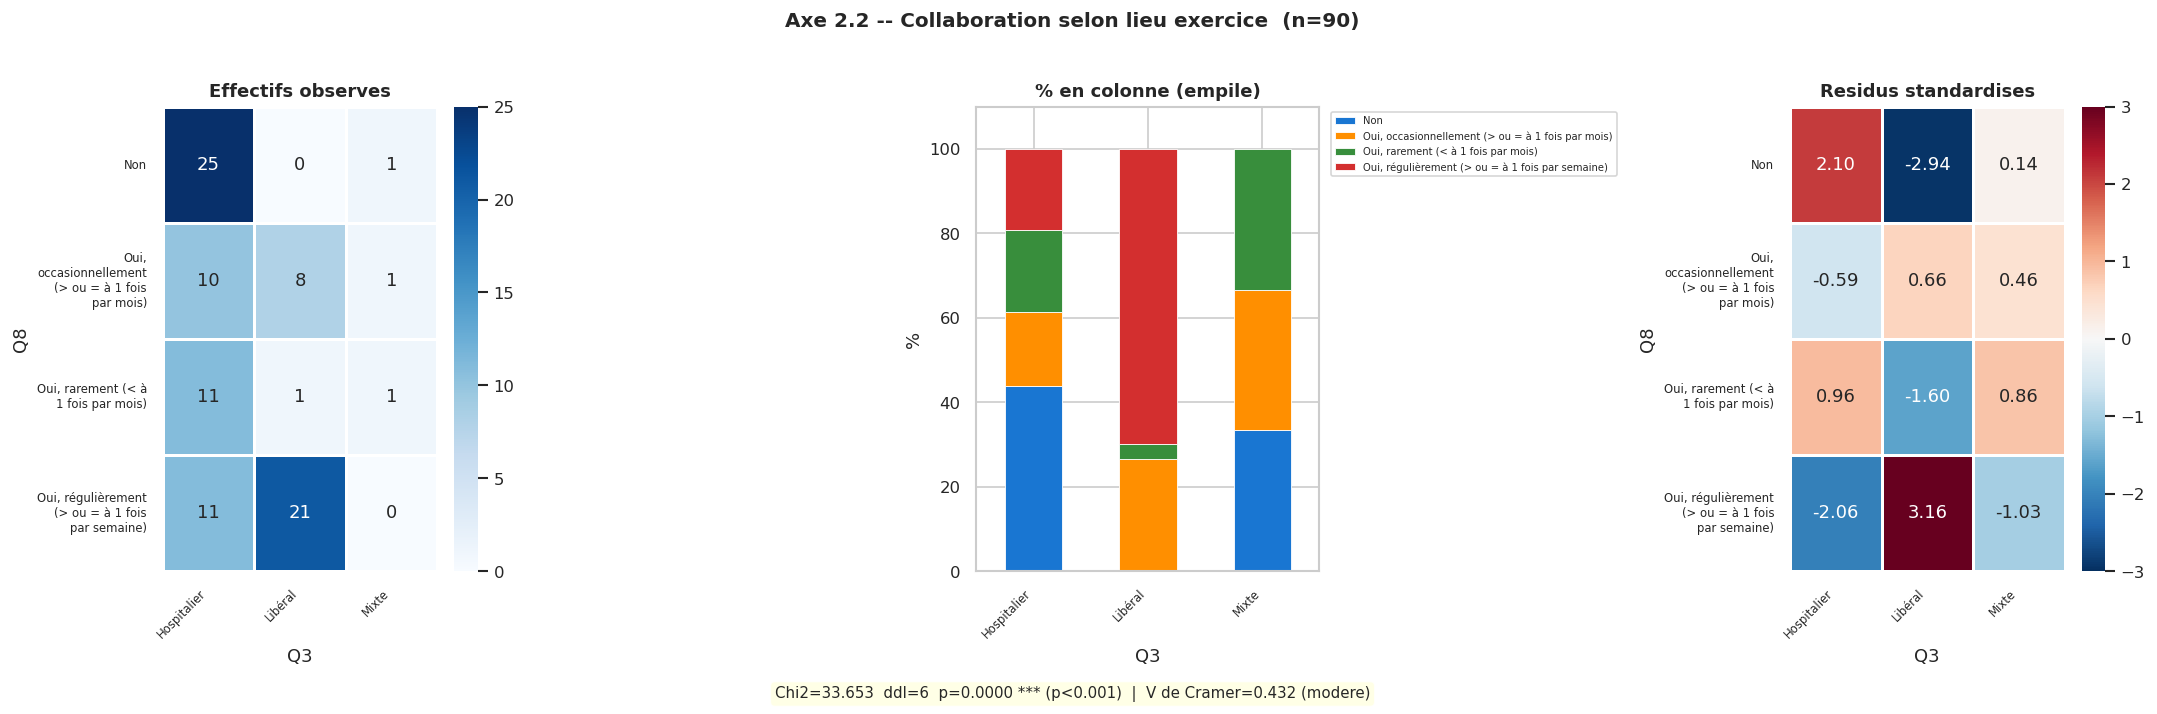

---


In [21]:
r = analyse('Q8','Q3', "Axe 2.2 -- Collaboration selon lieu exercice", "Qui collabore le plus ?")
if r: results.append(r)

### Axe 2.2 -- Freq. collaboration selon anciennete

*L'anciennete influence-t-elle la collaboration ?*

**Freq. collaboration (0-3)** x **Anciennete** | n = 64 | Test : Q2(nom,4grp) x Q8_ord(ord) -> Kruskal-Wallis H

**Effectifs observes :**

Q8_ord          1.0  2.0  3.0  Total
Q2                                  
2 à 5 ans         1    2    2      5
5 à 10 ans        2    2    6     10
Moins de 2 ans    0    4    1      5
Plus de 10 ans    9   11   24     44
Total            12   19   33     64

**Pourcentages en ligne (%) :**

Q8_ord           1.0   2.0   3.0
Q2                              
2 à 5 ans       20.0  40.0  40.0
5 à 10 ans      20.0  20.0  60.0
Moins de 2 ans   0.0  80.0  20.0
Plus de 10 ans  20.5  25.0  54.5

**Statistiques par groupe :**

count  mean   std  min  25%  50%  75%  max
Q2                                                        
2 à 5 ans         5.0  2.20  0.84  1.0  2.0  2.0  3.0  3.0
5 à 10 ans       10.0  2.40  0.84  1.0  2.0  3.0  3.0  3.0
Moins de 2 ans    5.0  2.20  0.45  2.0  2.0  2.0  2.0  3.0
Plus de 10 ans   44.0  2.34  0.81  1.0  2.0  3.0  3.0  3.0

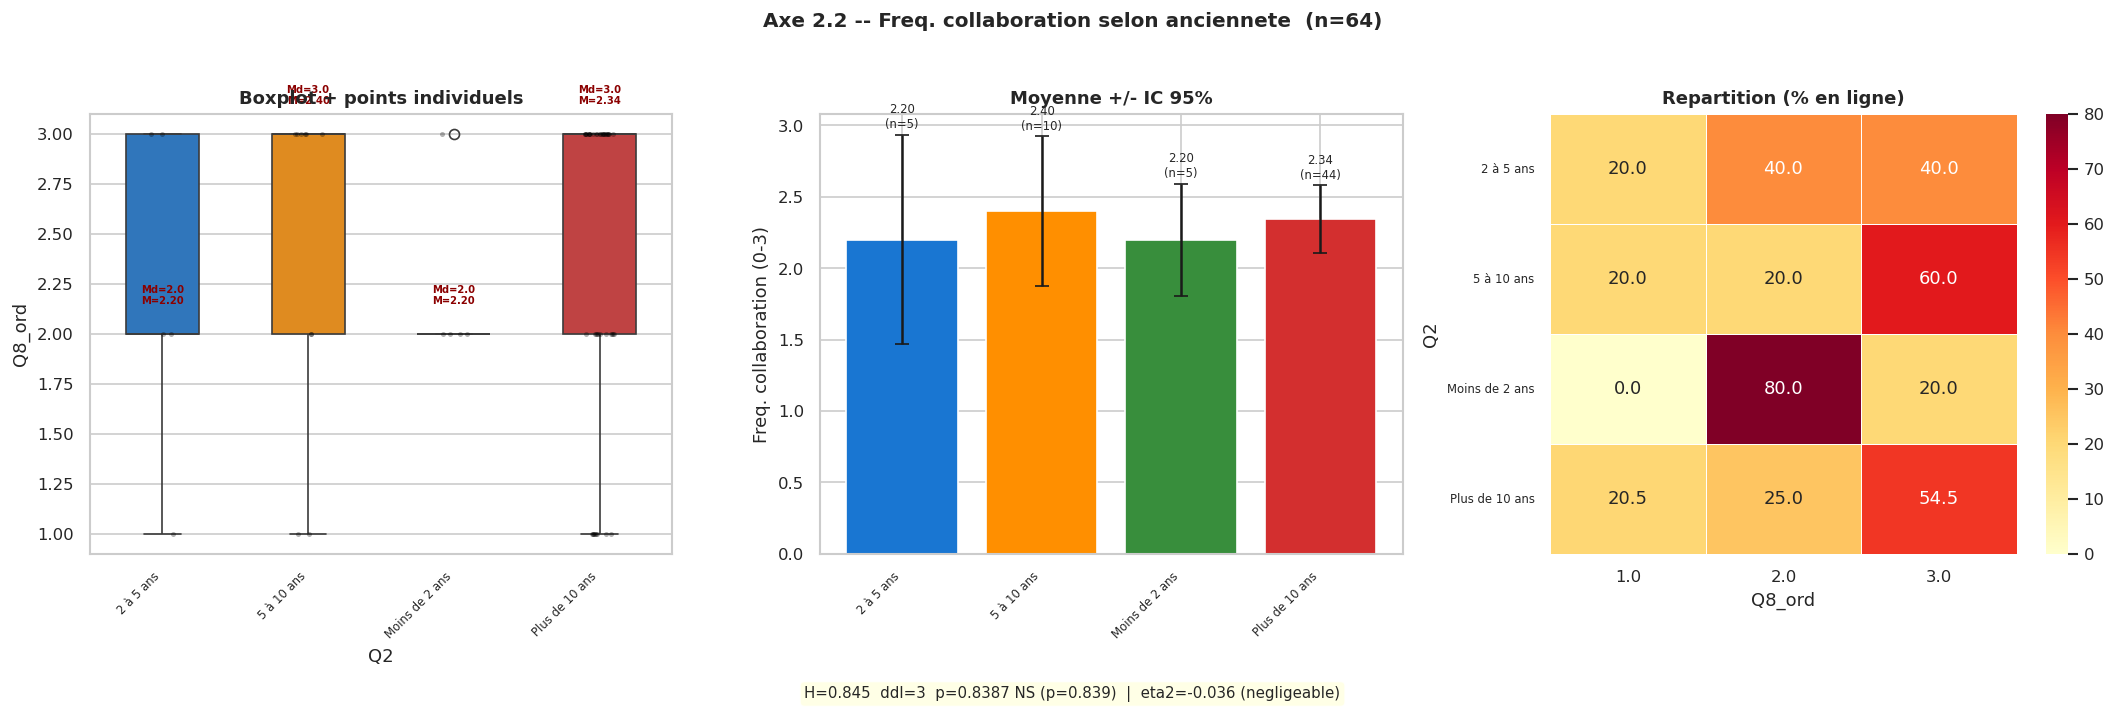

---


In [22]:
r = analyse('Q8_ord','Q2', "Axe 2.2 -- Freq. collaboration selon anciennete", "L'anciennete influence-t-elle la collaboration ?")
if r: results.append(r)

### 2.3 Freins limitant la place

### Axe 2.3 -- Reseau et collaboration

*L'absence de reseau est-elle LE frein ?*

**Acces reseau** x **Collaboration (Oui/Non)** | n = 151 | Test : Q7(nom) x Q8_bin(nom) -> Chi-deux

**Effectifs observes :**

Q8_bin     Non  Oui  Total
Q7                        
Non         31   44     75
Oui          4   51     55
Sans avis    9   12     21
Total       44  107    151

**Pourcentages en colonne (%) :**

Q8_bin      Non   Oui
Q7                   
Non        70.5  41.1
Oui         9.1  47.7
Sans avis  20.5  11.2

**Pourcentages en ligne (%) :**

Q8_bin      Non   Oui
Q7                   
Non        41.3  58.7
Oui         7.3  92.7
Sans avis  42.9  57.1

**Effectifs theoriques :**

Q8_bin      Non   Oui
Q7                   
Non        21.9  53.1
Oui        16.0  39.0
Sans avis   6.1  14.9

**Residus standardises (contributions au Chi2) :**

Q8_bin      Non   Oui
Q7                   
Non        1.96 -1.25
Oui       -3.00  1.93
Sans avis  1.16 -0.75

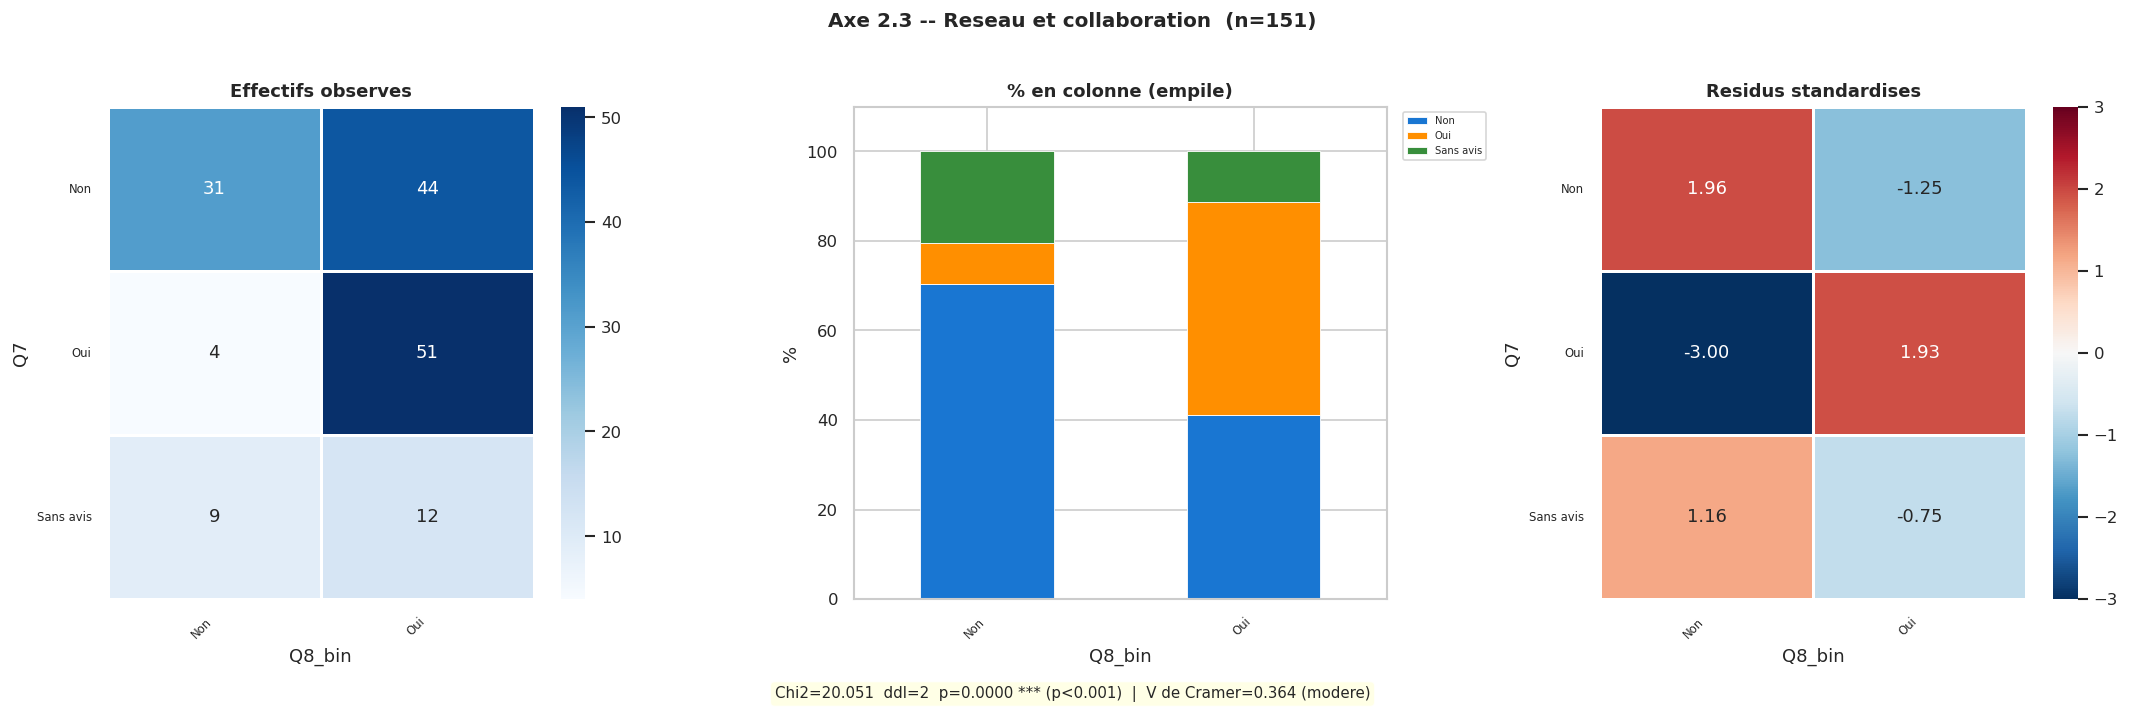

---


In [23]:
r = analyse('Q7','Q8_bin', "Axe 2.3 -- Reseau et collaboration", "L'absence de reseau est-elle LE frein ?")
if r: results.append(r)

### Axe 2.3 -- Info patientes vs info SF

*SF mal informees = patientes mal informees ?*

**Info patientes (1-5)** x **Sentiment info (1-5)** | n = 151 | Test : Q18(ord) x Q6(ord) -> Spearman

**Effectifs croises :**

Q6      1   2   3   4  5  Total
Q18                            
1      12  16   8   7  2     45
2       9  19  15  16  3     62
3       3   4  12  11  1     31
4       2   3   1   6  0     12
5       0   0   1   0  0      1
Total  26  42  37  40  6    151

**Pourcentages du total (%) :**

Q6     1     2    3     4    5
Q18                           
1    7.9  10.6  5.3   4.6  1.3
2    6.0  12.6  9.9  10.6  2.0
3    2.0   2.6  7.9   7.3  0.7
4    1.3   2.0  0.7   4.0  0.0
5    0.0   0.0  0.7   0.0  0.0

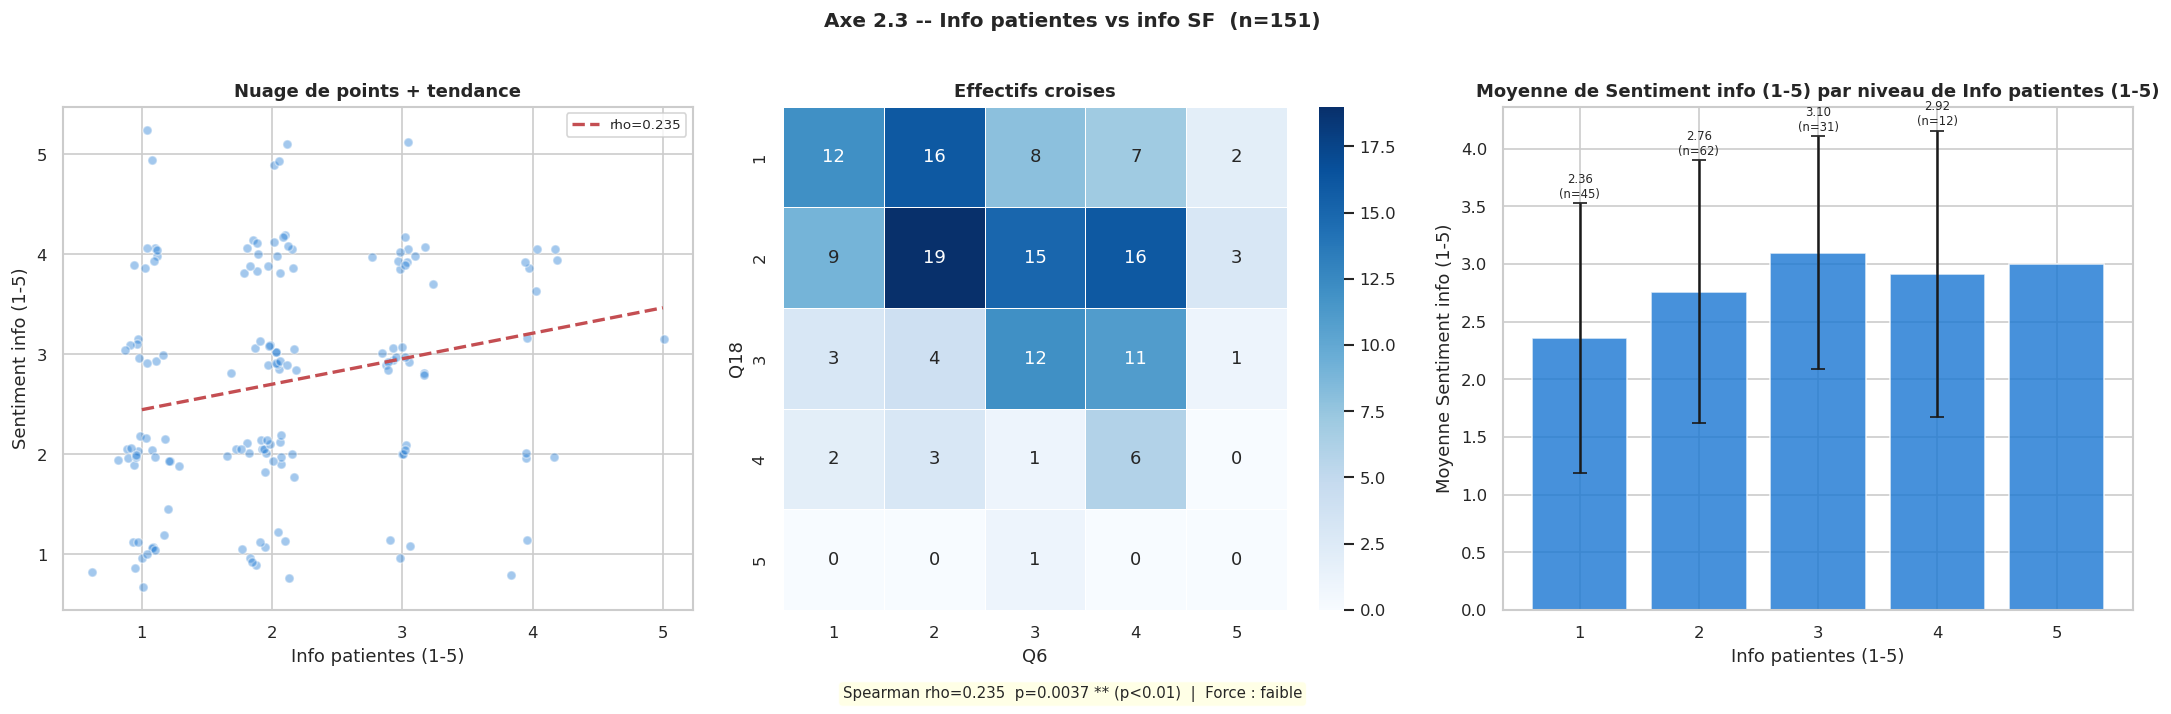

---


In [24]:
r = analyse('Q18','Q6', "Axe 2.3 -- Info patientes vs info SF", "SF mal informees = patientes mal informees ?")
if r: results.append(r)

### Axe 2.3 -- Retard diagnostic selon lieu

*Le retard est-il percu differemment ?*

**Retard diagnostic** x **Lieu exercice** | n = 90 | Test : Q13(nom) x Q3(nom) -> Chi-deux

**Effectifs observes :**

Q3         Hospitalier  Libéral  Mixte  Total
Q13                                          
Non                 20        5      1     26
Oui                 21       14      2     37
Sans avis           16       11      0     27
Total               57       30      3     90

**Pourcentages en colonne (%) :**

Q3         Hospitalier  Libéral  Mixte
Q13                                   
Non               35.1     16.7   33.3
Oui               36.8     46.7   66.7
Sans avis         28.1     36.7    0.0

**Pourcentages en ligne (%) :**

Q3         Hospitalier  Libéral  Mixte
Q13                                   
Non               76.9     19.2    3.8
Oui               56.8     37.8    5.4
Sans avis         59.3     40.7    0.0

**Effectifs theoriques :**

Q3         Hospitalier  Libéral  Mixte
Q13                                   
Non               16.5      8.7    0.9
Oui               23.4     12.3    1.2
Sans avis         17.1      9.0    0.9

**Attention : 33% des effectifs theoriques < 5.**

**Residus standardises (contributions au Chi2) :**

Q3         Hospitalier  Libéral  Mixte
Q13                                   
Non               0.87    -1.25   0.14
Oui              -0.50     0.47   0.69
Sans avis        -0.27     0.67  -0.95

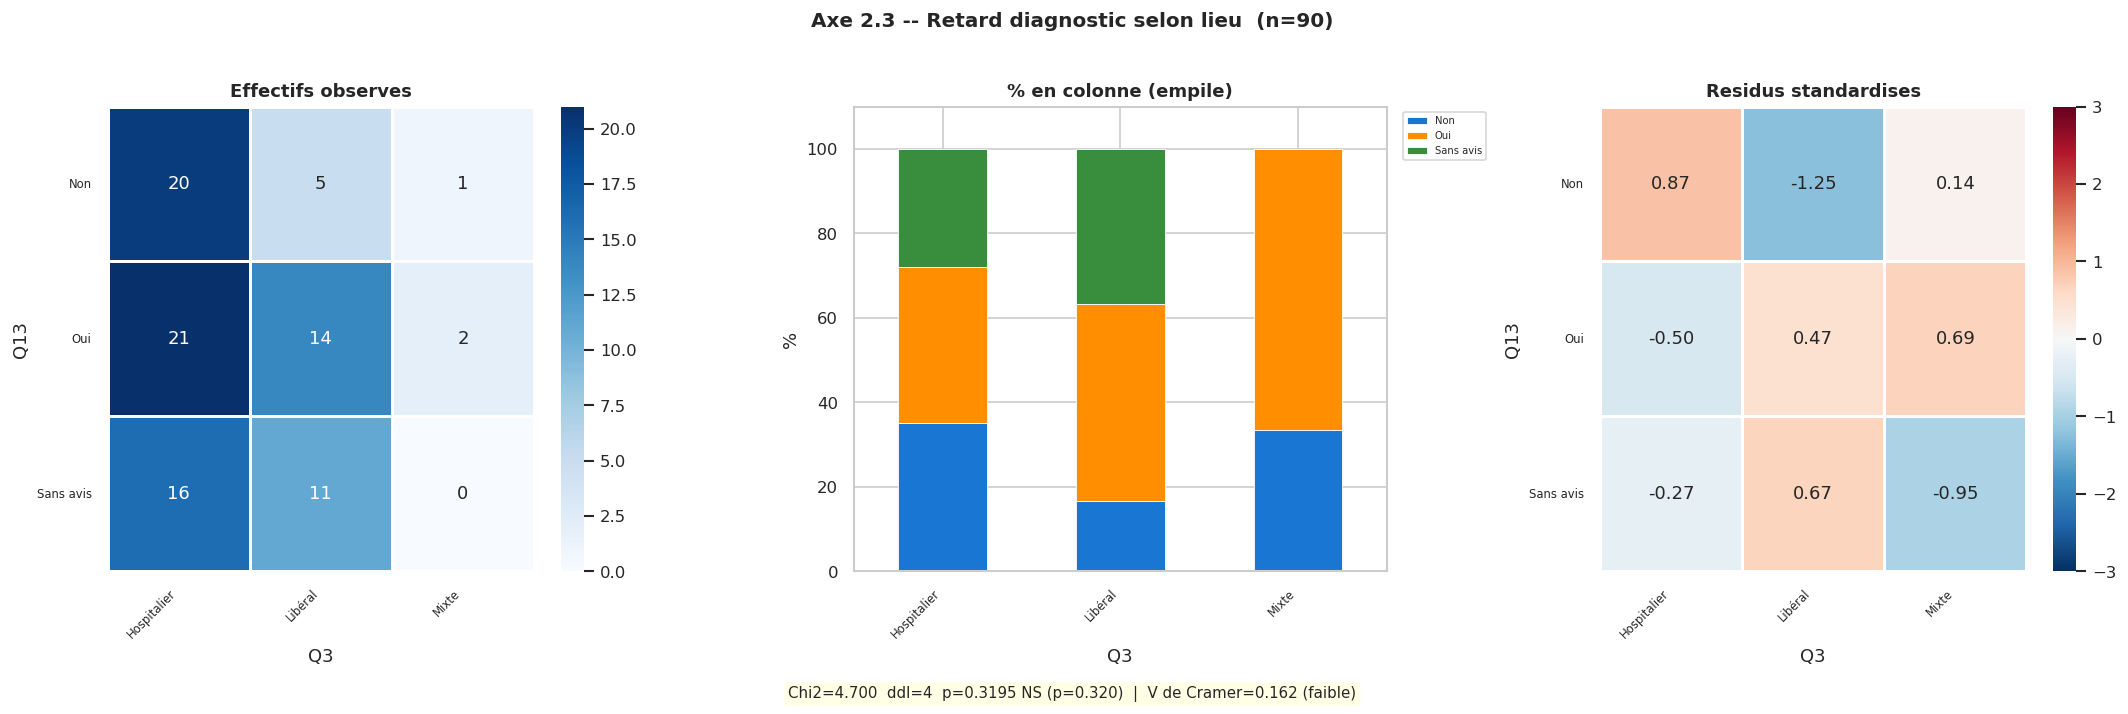

---


In [25]:
r = analyse('Q13','Q3', "Axe 2.3 -- Retard diagnostic selon lieu", "Le retard est-il percu differemment ?")
if r: results.append(r)

---
## AXE 3 : INFLUENCE SUR LA COLLABORATION
### 3.1 Etat de la collaboration

### Axe 3.1 -- Collaboration selon favorabilite

*Les favorables collaborent-elles plus ?*

**Collaboration (Oui/Non)** x **Favorabilite (1-5)** | n = 151 | Test : Q8_bin(nom,2grp) x Q16(ord) -> Mann-Whitney U

**Effectifs observes :**

Q16     1  2   3   4   5  Total
Q8_bin                         
Non     2  3   5  17  17     44
Oui     1  2  13  47  44    107
Total   3  5  18  64  61    151

**Pourcentages en ligne (%) :**

Q16       1    2     3     4     5
Q8_bin                            
Non     4.5  6.8  11.4  38.6  38.6
Oui     0.9  1.9  12.1  43.9  41.1

**Statistiques par groupe :**

count  mean  std  min  25%  50%  75%  max
Q8_bin                                           
Non      44.0  4.00  1.1  1.0  4.0  4.0  5.0  5.0
Oui     107.0  4.22  0.8  1.0  4.0  4.0  5.0  5.0

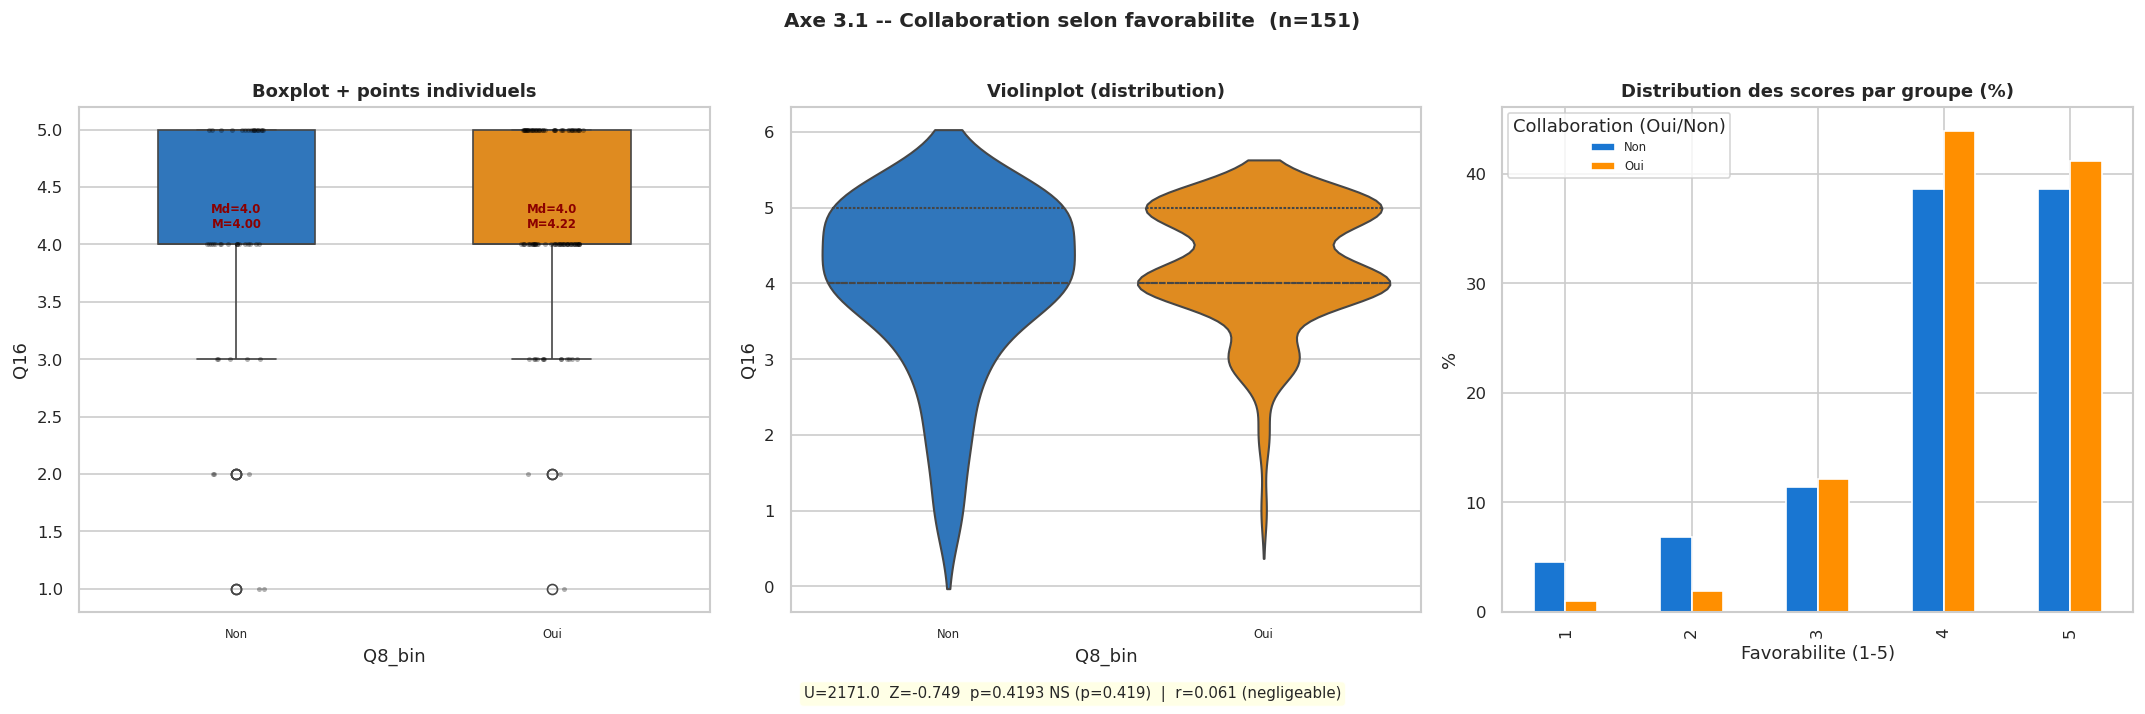

---


In [26]:
r = analyse('Q8_bin','Q16', "Axe 3.1 -- Collaboration selon favorabilite", "Les favorables collaborent-elles plus ?")
if r: results.append(r)

### Axe 3.1 -- Collaboration selon utilite percue

*Percevoir l'utilite -> collaboration ?*

**Collaboration (Oui/Non)** x **Utilite osteo (1-5)** | n = 151 | Test : Q8_bin(nom,2grp) x Q5(ord) -> Mann-Whitney U

**Effectifs observes :**

Q5      1  2   3   4   5  Total
Q8_bin                         
Non     3  5  13  16   7     44
Oui     0  4  28  44  31    107
Total   3  9  41  60  38    151

**Pourcentages en ligne (%) :**

Q5        1     2     3     4     5
Q8_bin                             
Non     6.8  11.4  29.5  36.4  15.9
Oui     0.0   3.7  26.2  41.1  29.0

**Statistiques par groupe :**

count  mean   std  min  25%  50%  75%  max
Q8_bin                                            
Non      44.0  3.43  1.11  1.0  3.0  4.0  4.0  5.0
Oui     107.0  3.95  0.84  2.0  3.0  4.0  5.0  5.0

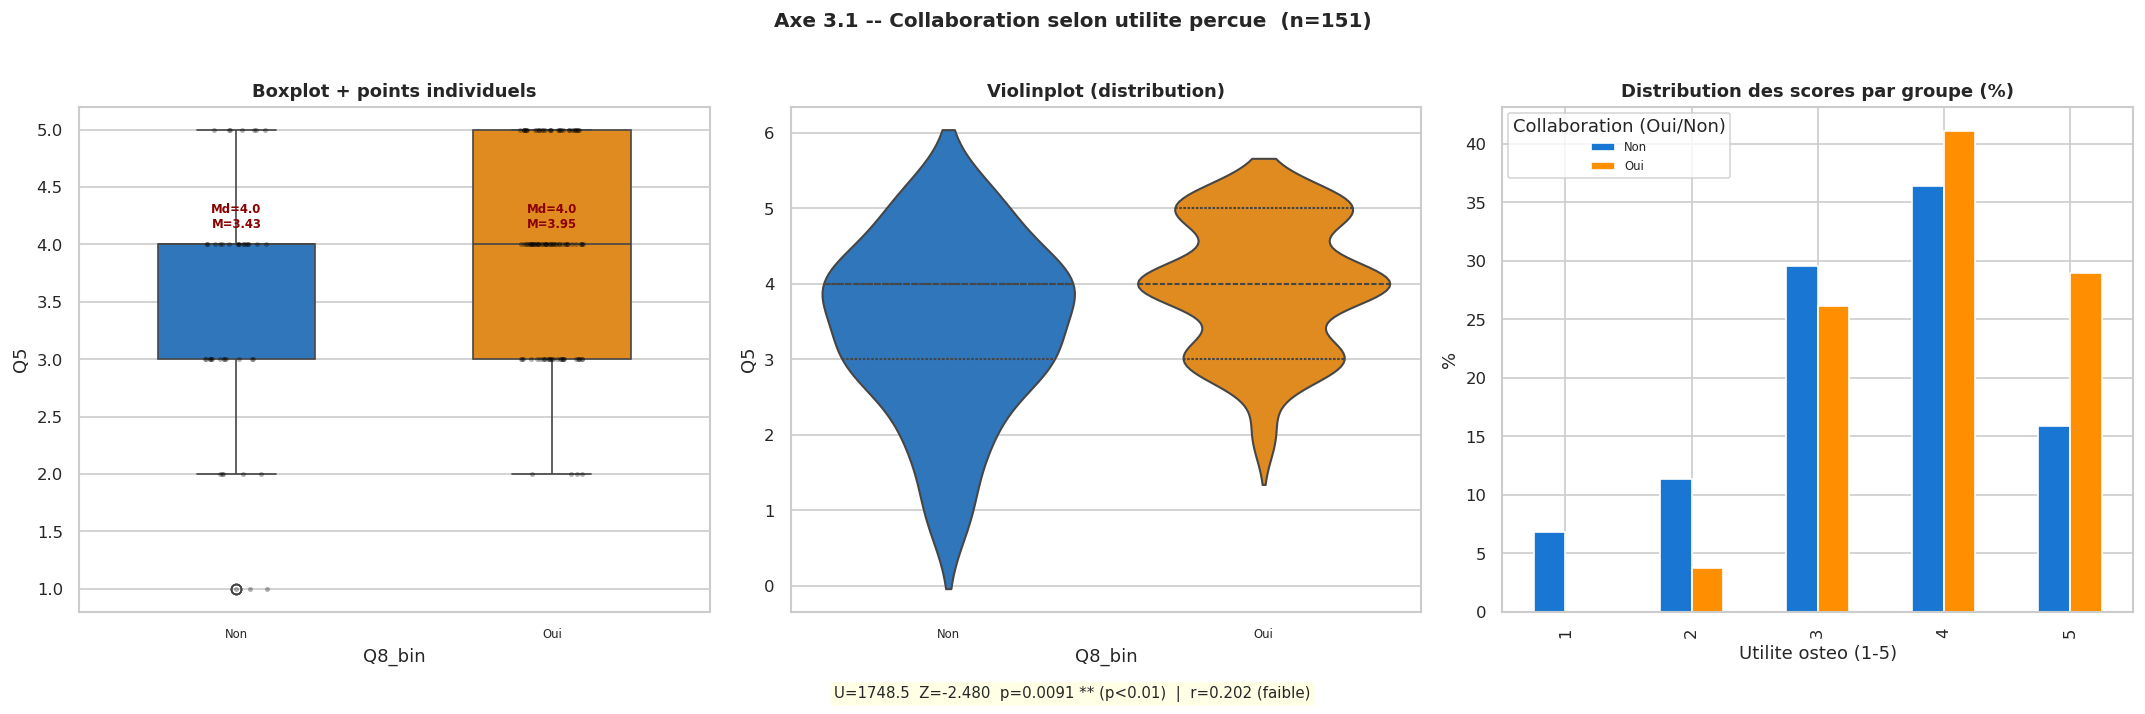

---


In [27]:
r = analyse('Q8_bin','Q5', "Axe 3.1 -- Collaboration selon utilite percue", "Percevoir l'utilite -> collaboration ?")
if r: results.append(r)

### Axe 3.1 -- Collaboration selon reseau

*Le reseau est-il determinant ?*

**Acces reseau** x **Collaboration (Oui/Non)** | n = 151 | Test : Q7(nom) x Q8_bin(nom) -> Chi-deux

**Effectifs observes :**

Q8_bin     Non  Oui  Total
Q7                        
Non         31   44     75
Oui          4   51     55
Sans avis    9   12     21
Total       44  107    151

**Pourcentages en colonne (%) :**

Q8_bin      Non   Oui
Q7                   
Non        70.5  41.1
Oui         9.1  47.7
Sans avis  20.5  11.2

**Pourcentages en ligne (%) :**

Q8_bin      Non   Oui
Q7                   
Non        41.3  58.7
Oui         7.3  92.7
Sans avis  42.9  57.1

**Effectifs theoriques :**

Q8_bin      Non   Oui
Q7                   
Non        21.9  53.1
Oui        16.0  39.0
Sans avis   6.1  14.9

**Residus standardises (contributions au Chi2) :**

Q8_bin      Non   Oui
Q7                   
Non        1.96 -1.25
Oui       -3.00  1.93
Sans avis  1.16 -0.75

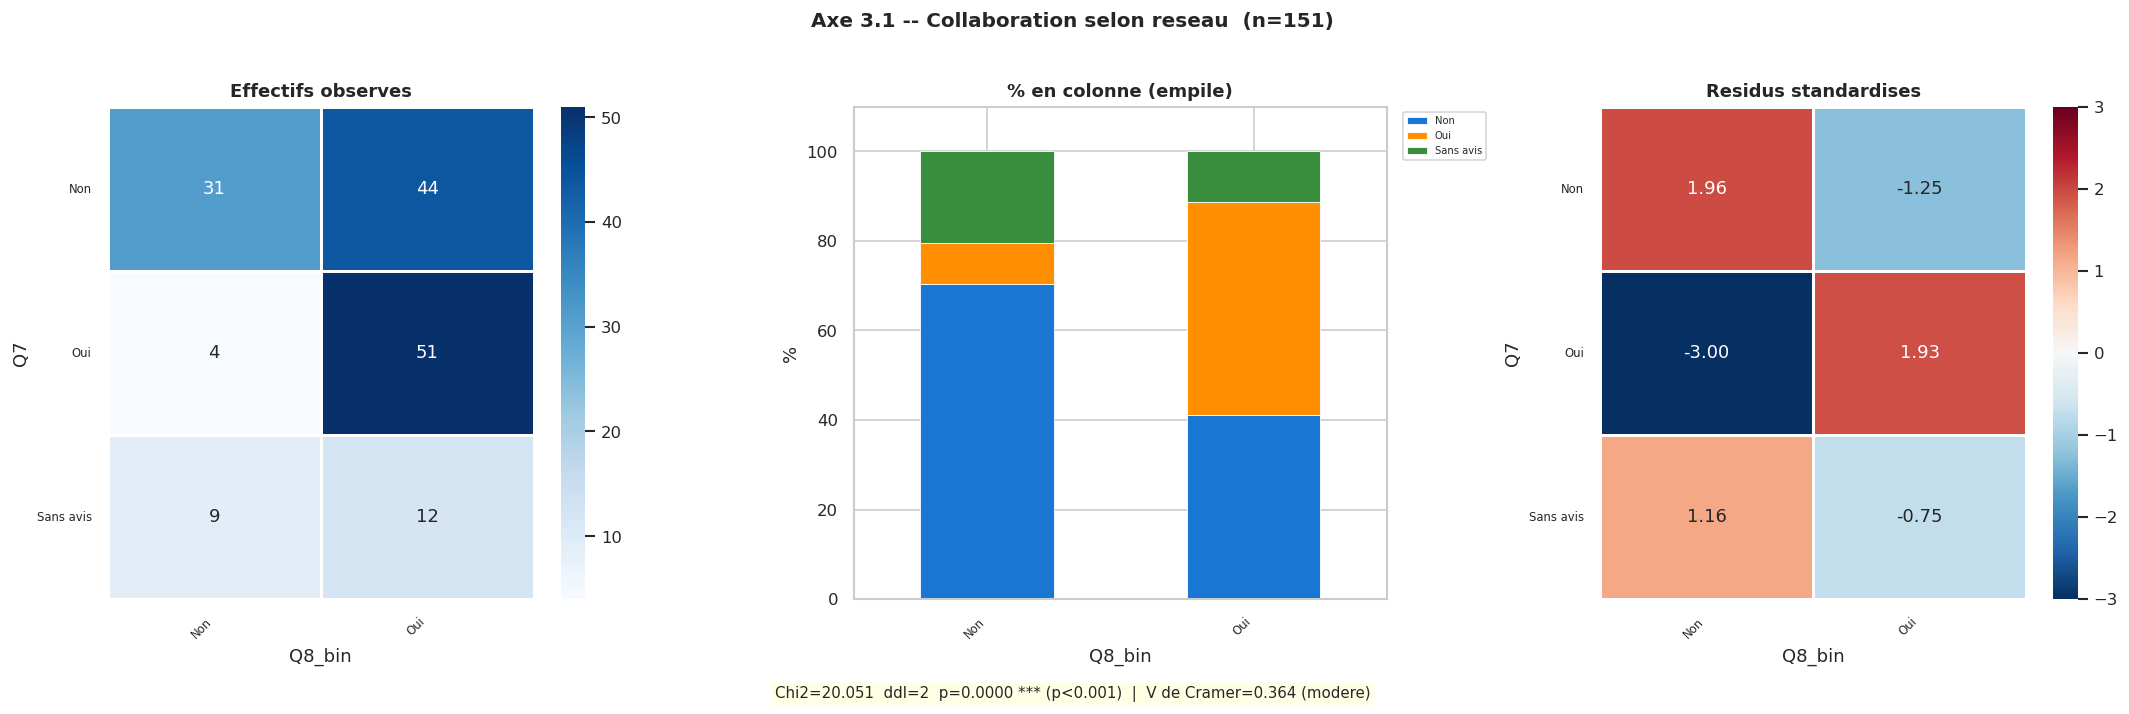

---


In [28]:
r = analyse('Q7','Q8_bin', "Axe 3.1 -- Collaboration selon reseau", "Le reseau est-il determinant ?")
if r: results.append(r)

### Axe 3.1 -- Collaboration selon connaissances

*Mieux connaitre -> plus collaborer ?*

**Collaboration (Oui/Non)** x **Connaissances osteo (1-5)** | n = 151 | Test : Q8_bin(nom,2grp) x Q4(ord) -> Mann-Whitney U

**Effectifs observes :**

Q4       1   2   3   4  5  Total
Q8_bin                          
Non     11  20   6   6  1     44
Oui     11  33  39  22  2    107
Total   22  53  45  28  3    151

**Pourcentages en ligne (%) :**

Q4         1     2     3     4    5
Q8_bin                             
Non     25.0  45.5  13.6  13.6  2.3
Oui     10.3  30.8  36.4  20.6  1.9

**Statistiques par groupe :**

count  mean   std  min   25%  50%  75%  max
Q8_bin                                             
Non      44.0  2.23  1.05  1.0  1.75  2.0  3.0  5.0
Oui     107.0  2.73  0.97  1.0  2.00  3.0  3.0  5.0

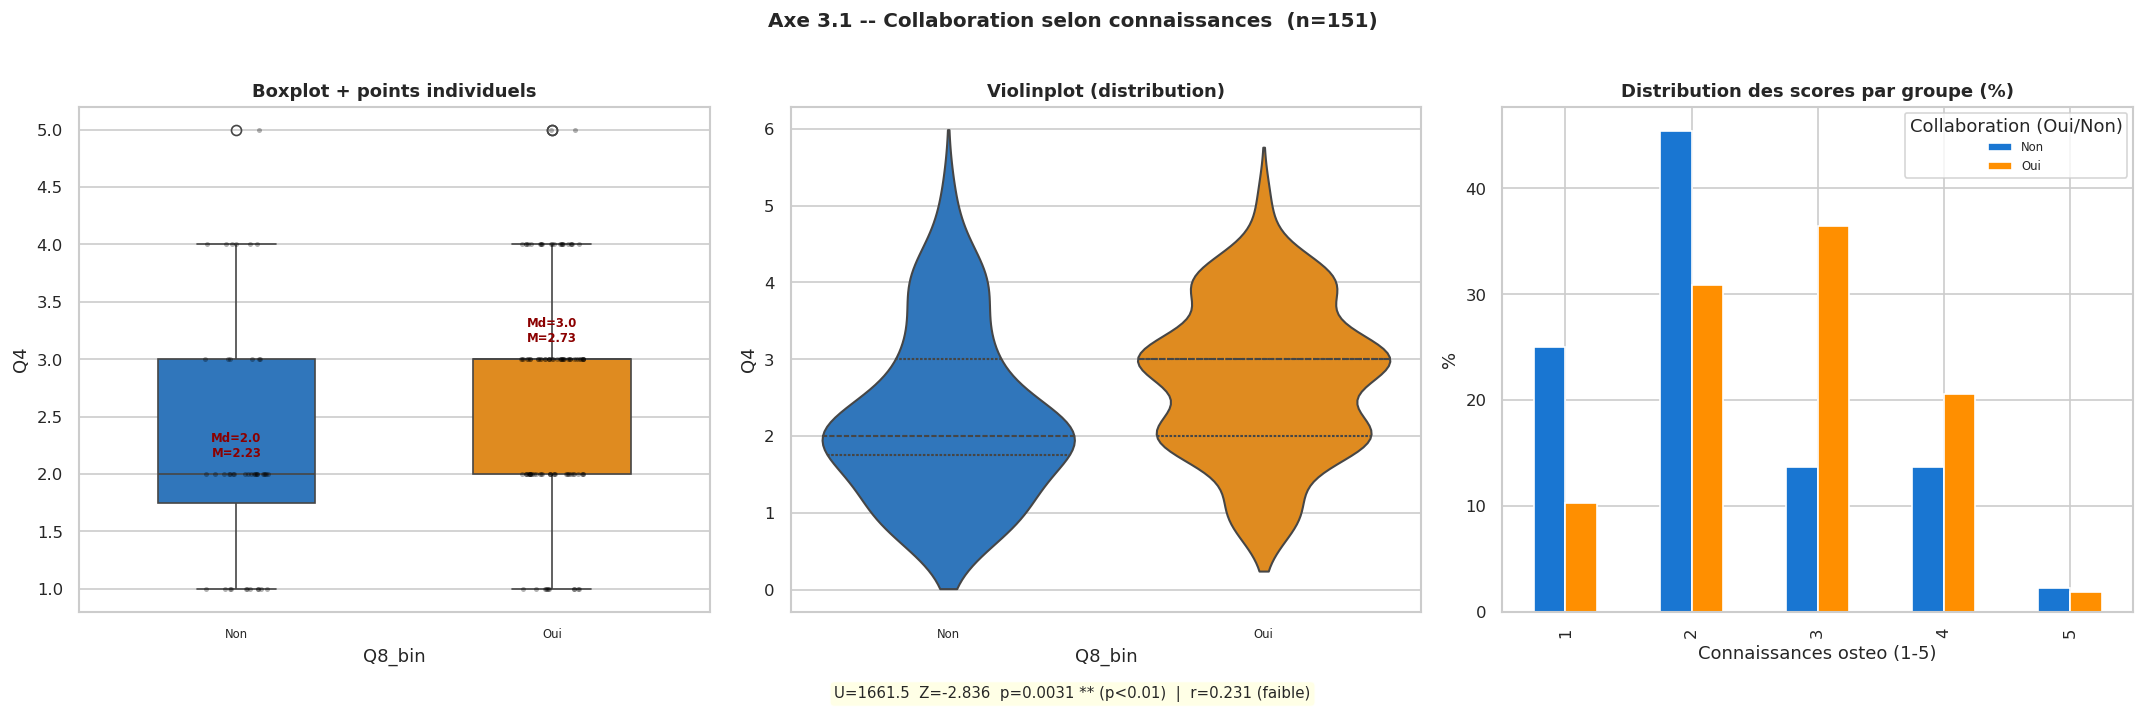

---


In [29]:
r = analyse('Q8_bin','Q4', "Axe 3.1 -- Collaboration selon connaissances", "Mieux connaitre -> plus collaborer ?")
if r: results.append(r)

### 3.2 Ecart intention/comportement

### Axe 3.2 -- Favorabilite vs freq. collaboration

*La favorabilite se traduit-elle en actes ?*

**Favorabilite (1-5)** x **Freq. collaboration (0-3)** | n = 107 | Test : Q16(ord) x Q8_ord(ord) -> Spearman

**Effectifs croises :**

Q8_ord  1.0  2.0  3.0  Total
Q16                         
1         1    0    0      1
2         0    0    2      2
3         6    5    2     13
4        13   21   13     47
5         7   18   19     44
Total    27   44   36    107

**Pourcentages du total (%) :**

Q8_ord   1.0   2.0   3.0
Q16                     
1        0.9   0.0   0.0
2        0.0   0.0   1.9
3        5.6   4.7   1.9
4       12.1  19.6  12.1
5        6.5  16.8  17.8

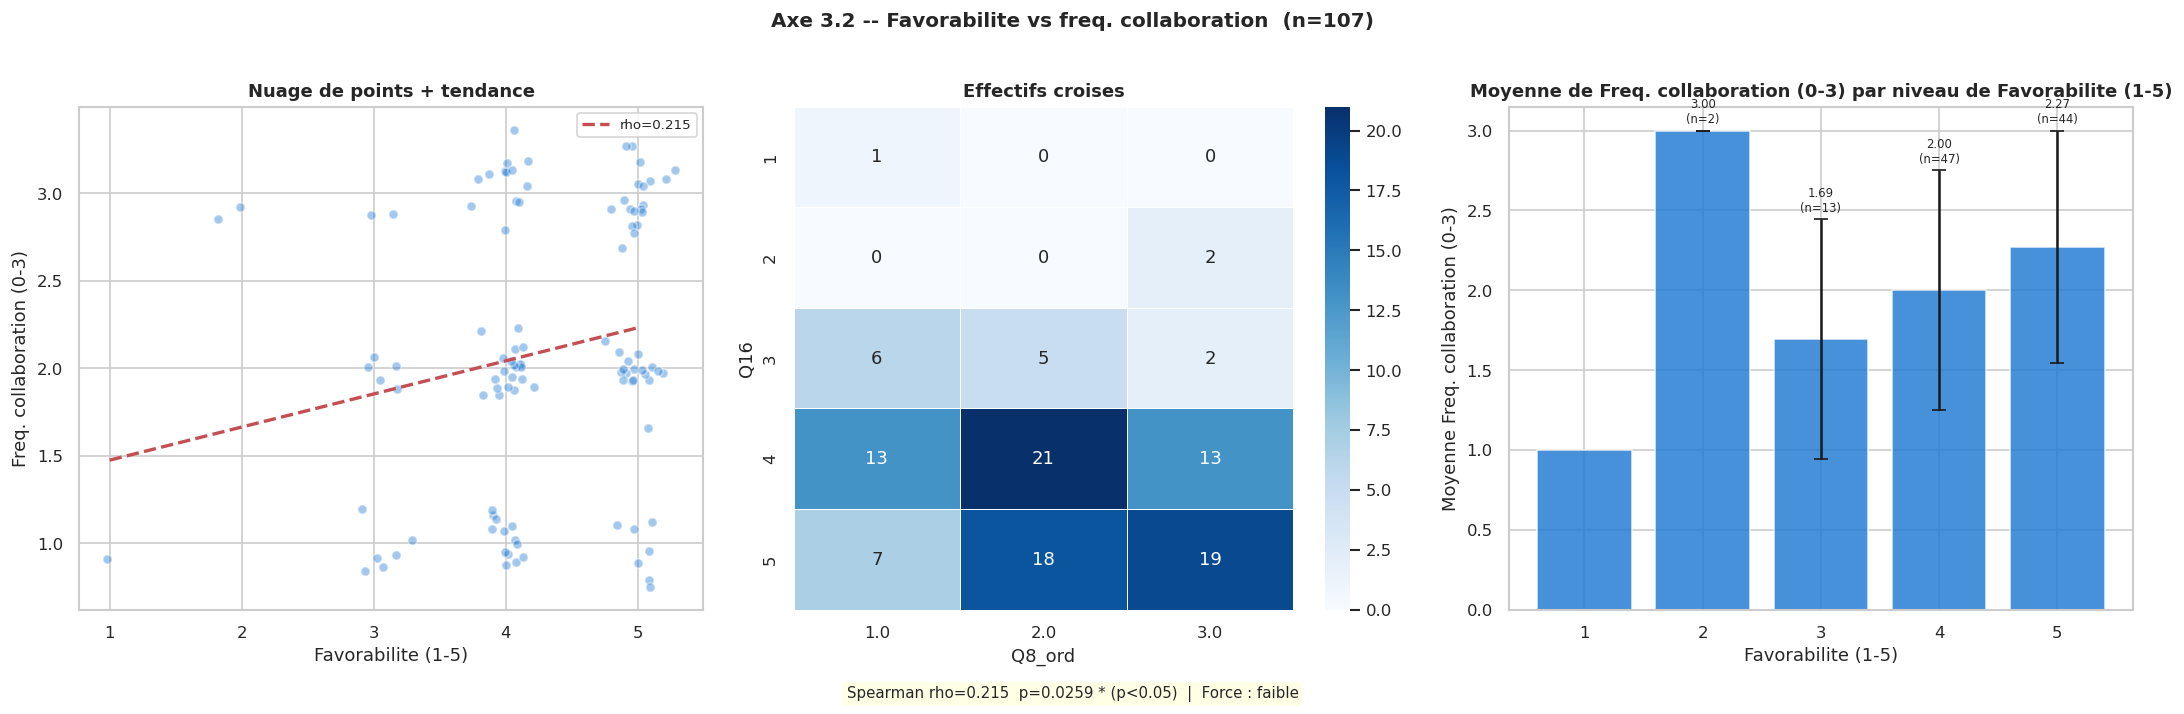

---


In [30]:
r = analyse('Q16','Q8_ord', "Axe 3.2 -- Favorabilite vs freq. collaboration", "La favorabilite se traduit-elle en actes ?")
if r: results.append(r)

### 3.3 Role du cadre institutionnel (H3)

### Axe 3.3 -- Reco officielles et collaboration

*Celles influencees collaborent-elles plus ?*

**Influence reco officielles** x **Collaboration (Oui/Non)** | n = 150 | Test : Q22(nom) x Q8_bin(nom) -> Chi-deux

**Effectifs observes :**

Q8_bin     Non  Oui  Total
Q22                       
Non         16   43     59
Oui         19   40     59
Sans avis    9   23     32
Total       44  106    150

**Pourcentages en colonne (%) :**

Q8_bin      Non   Oui
Q22                  
Non        36.4  40.6
Oui        43.2  37.7
Sans avis  20.5  21.7

**Pourcentages en ligne (%) :**

Q8_bin      Non   Oui
Q22                  
Non        27.1  72.9
Oui        32.2  67.8
Sans avis  28.1  71.9

**Effectifs theoriques :**

Q8_bin      Non   Oui
Q22                  
Non        17.3  41.7
Oui        17.3  41.7
Sans avis   9.4  22.6

**Residus standardises (contributions au Chi2) :**

Q8_bin      Non   Oui
Q22                  
Non       -0.31  0.20
Oui        0.41 -0.26
Sans avis -0.13  0.08

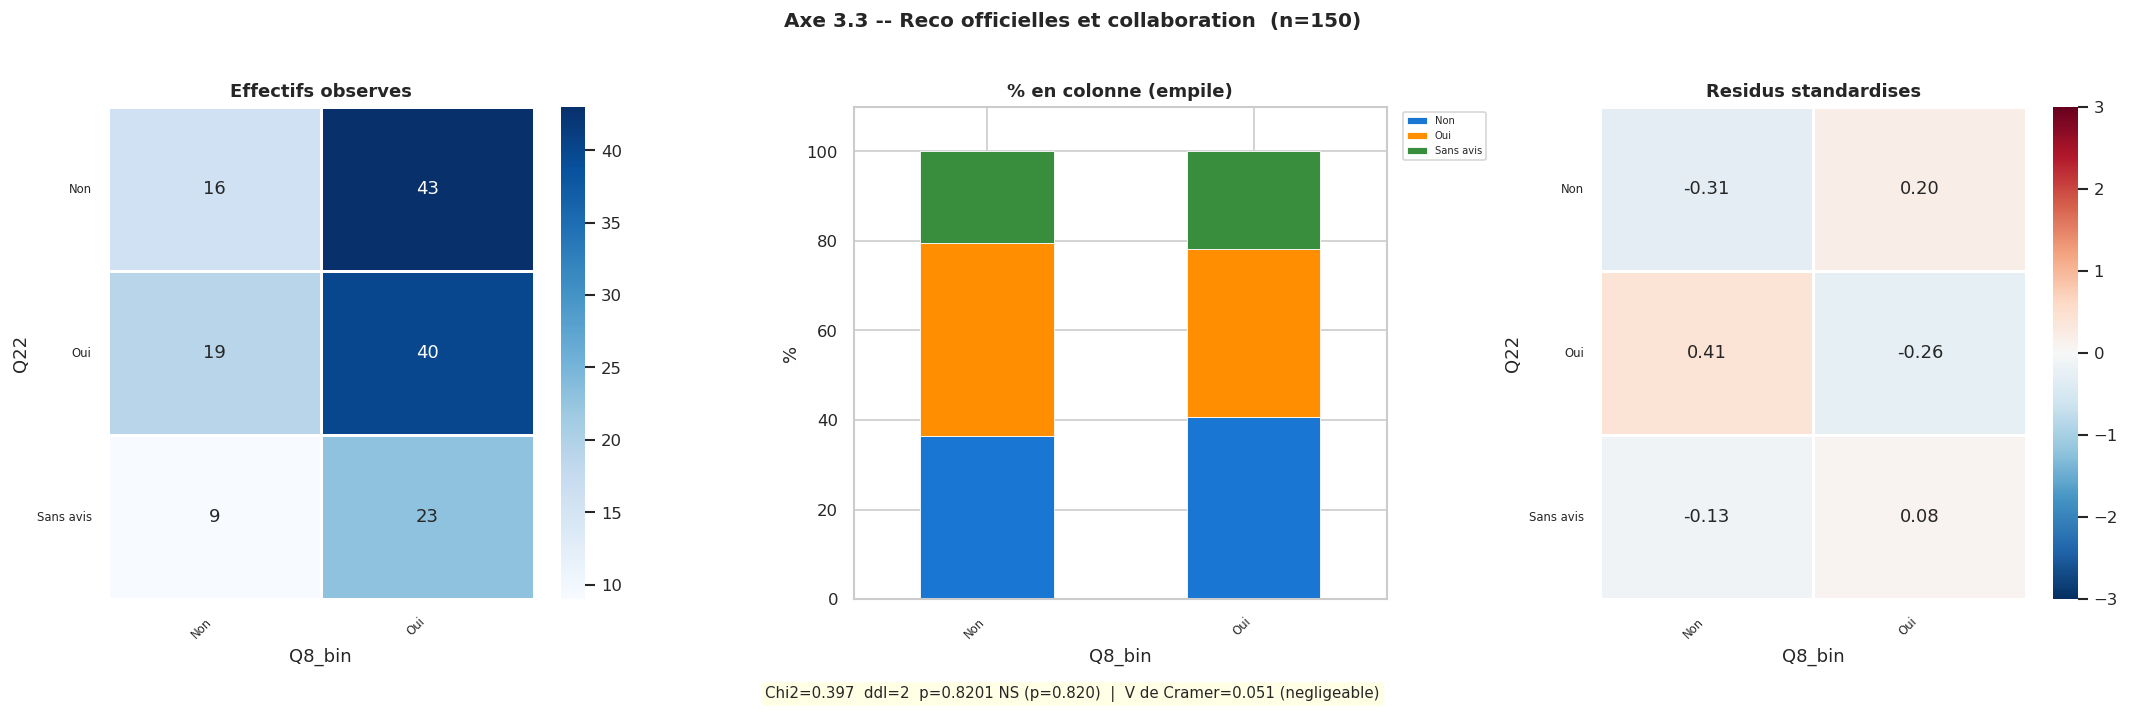

---


In [31]:
r = analyse('Q22','Q8_bin', "Axe 3.3 -- Reco officielles et collaboration", "Celles influencees collaborent-elles plus ?")
if r: results.append(r)

### Axe 3.3 -- Reco selon anciennete

*Jeunes diplomees plus sensibles aux reco ?*

**Influence reco officielles** x **Anciennete** | n = 90 | Test : Q22(nom) x Q2(nom) -> Chi-deux

**Effectifs observes :**

Q2         2 à 5 ans  5 à 10 ans  Moins de 2 ans  Plus de 10 ans  Total
Q22                                                                    
Non                4           8               2              35     49
Oui                2           3               1              13     19
Sans avis          1           4               6              11     22
Total              7          15               9              59     90

**Pourcentages en colonne (%) :**

Q2         2 à 5 ans  5 à 10 ans  Moins de 2 ans  Plus de 10 ans
Q22                                                             
Non             57.1        53.3            22.2            59.3
Oui             28.6        20.0            11.1            22.0
Sans avis       14.3        26.7            66.7            18.6

**Pourcentages en ligne (%) :**

Q2         2 à 5 ans  5 à 10 ans  Moins de 2 ans  Plus de 10 ans
Q22                                                             
Non              8.2        16.3             4.1            71.4
Oui             10.5        15.8             5.3            68.4
Sans avis        4.5        18.2            27.3            50.0

**Effectifs theoriques :**

Q2         2 à 5 ans  5 à 10 ans  Moins de 2 ans  Plus de 10 ans
Q22                                                             
Non              3.8         8.2             4.9            32.1
Oui              1.5         3.2             1.9            12.5
Sans avis        1.7         3.7             2.2            14.4

**Attention : 67% des effectifs theoriques < 5.**

**Residus standardises (contributions au Chi2) :**

Q2         2 à 5 ans  5 à 10 ans  Moins de 2 ans  Plus de 10 ans
Q22                                                             
Non             0.10       -0.06           -1.31            0.51
Oui             0.43       -0.09           -0.65            0.15
Sans avis      -0.54        0.17            2.56           -0.90

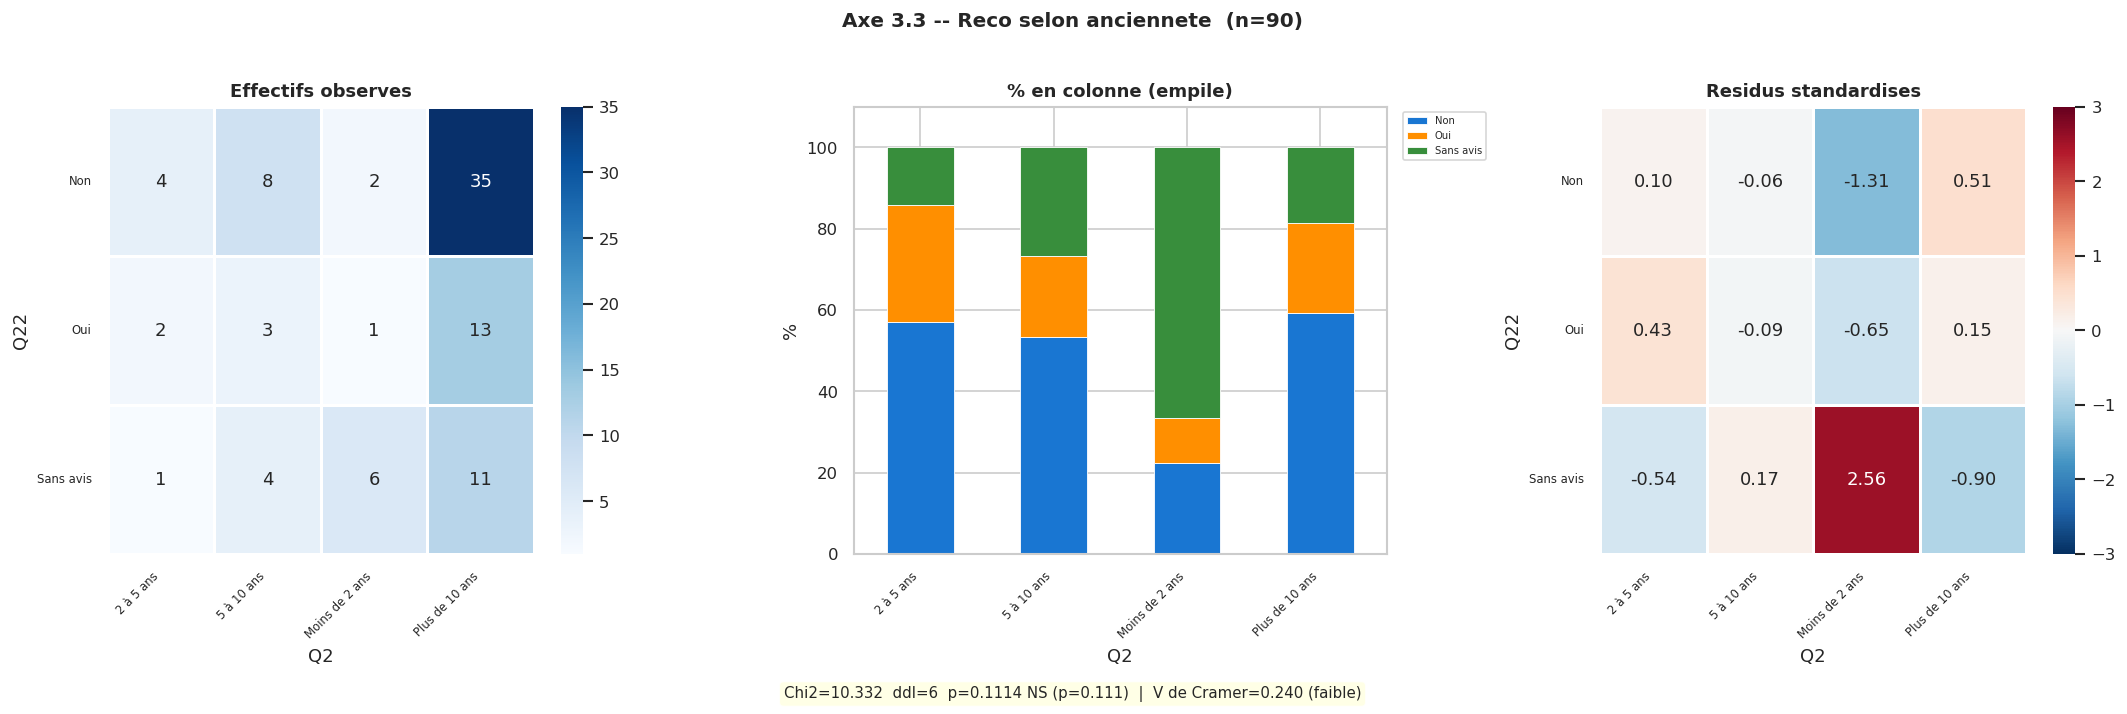

---


In [32]:
r = analyse('Q22','Q2', "Axe 3.3 -- Reco selon anciennete", "Jeunes diplomees plus sensibles aux reco ?")
if r: results.append(r)

### Axe 3.3 -- Reco selon statut

*Etudiantes vs diplomees face aux reco*

**Influence reco officielles** x **Statut** | n = 150 | Test : Q22(nom) x Q1(nom) -> Chi-deux

**Effectifs observes :**

Q1         Sage-femme diplômé(e)  Étudiant(e) sage-femme en 5e année  Total
Q22                                                                        
Non                           49                                  10     59
Oui                           19                                  40     59
Sans avis                     22                                  10     32
Total                         90                                  60    150

**Pourcentages en colonne (%) :**

Q1         Sage-femme diplômé(e)  Étudiant(e) sage-femme en 5e année
Q22                                                                 
Non                         54.4                                16.7
Oui                         21.1                                66.7
Sans avis                   24.4                                16.7

**Pourcentages en ligne (%) :**

Q1         Sage-femme diplômé(e)  Étudiant(e) sage-femme en 5e année
Q22                                                                 
Non                         83.1                                16.9
Oui                         32.2                                67.8
Sans avis                   68.8                                31.2

**Effectifs theoriques :**

Q1         Sage-femme diplômé(e)  Étudiant(e) sage-femme en 5e année
Q22                                                                 
Non                         35.4                                23.6
Oui                         35.4                                23.6
Sans avis                   19.2                                12.8

**Residus standardises (contributions au Chi2) :**

Q1         Sage-femme diplômé(e)  Étudiant(e) sage-femme en 5e année
Q22                                                                 
Non                         2.29                               -2.80
Oui                        -2.76                                3.38
Sans avis                   0.64                               -0.78

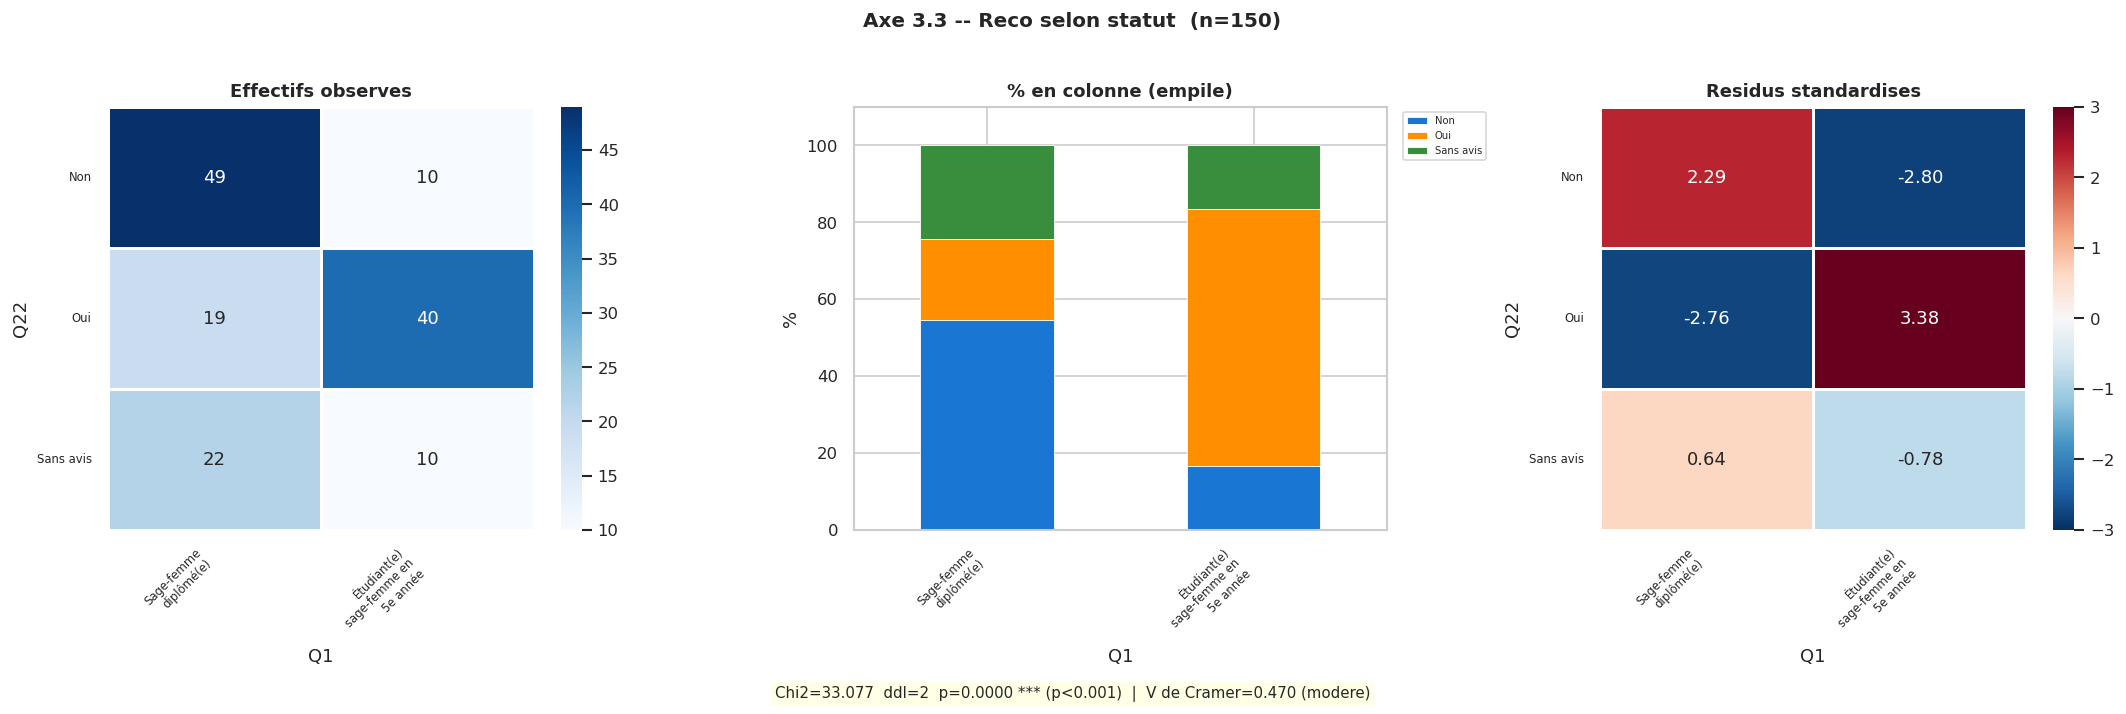

---


In [33]:
r = analyse('Q22','Q1', "Axe 3.3 -- Reco selon statut", "Etudiantes vs diplomees face aux reco")
if r: results.append(r)

### 3.4 Effet feedback

### Axe 3.4 -- Collaboration renforce utilite percue ?

*Cercle vertueux collaboration -> representations ?*

**Freq. collaboration (0-3)** x **Utilite osteo (1-5)** | n = 107 | Test : Q8_ord(ord) x Q5(ord) -> Spearman

**Effectifs croises :**

Q5      2   3   4   5  Total
Q8_ord                      
1.0     3  11   9   4     27
2.0     0  15  21   8     44
3.0     1   2  14  19     36
Total   4  28  44  31    107

**Pourcentages du total (%) :**

Q5        2     3     4     5
Q8_ord                       
1.0     2.8  10.3   8.4   3.7
2.0     0.0  14.0  19.6   7.5
3.0     0.9   1.9  13.1  17.8

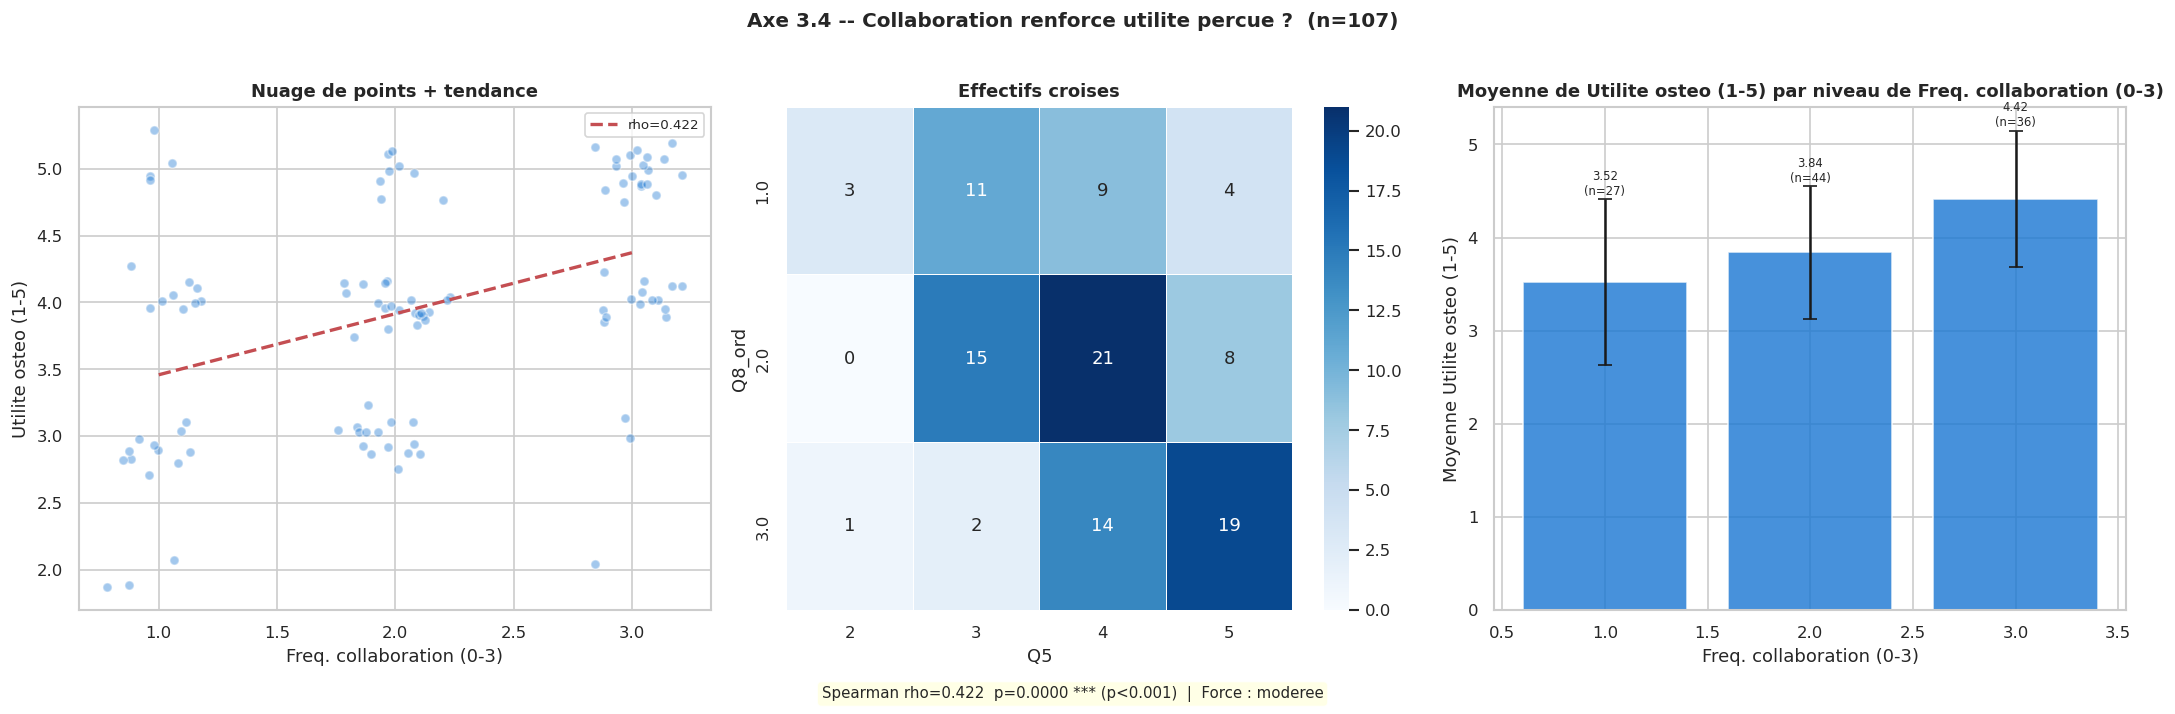

---


In [34]:
r = analyse('Q8_ord','Q5', "Axe 3.4 -- Collaboration renforce utilite percue ?", "Cercle vertueux collaboration -> representations ?")
if r: results.append(r)

---
## AXE 4 : LE SYNDROME DE LACOMME
### 4.1 Connaissances SdL

### Axe 4.1 -- Connaissances SdL vs osteopathie

*Connait-on mieux le syndrome ou le traitement ?*

**Connaissances SdL (1-5)** x **Connaissances osteo (1-5)** | n = 151 | Test : Q10(ord) x Q4(ord) -> Spearman

**Effectifs croises :**

Q4      1   2   3   4  5  Total
Q10                            
1       1   2   2   0  0      5
2      12  17   3   1  0     33
3       7  16  22   7  0     52
4       2  15  15  16  2     50
5       0   3   3   4  1     11
Total  22  53  45  28  3    151

**Pourcentages du total (%) :**

Q4     1     2     3     4    5
Q10                            
1    0.7   1.3   1.3   0.0  0.0
2    7.9  11.3   2.0   0.7  0.0
3    4.6  10.6  14.6   4.6  0.0
4    1.3   9.9   9.9  10.6  1.3
5    0.0   2.0   2.0   2.6  0.7

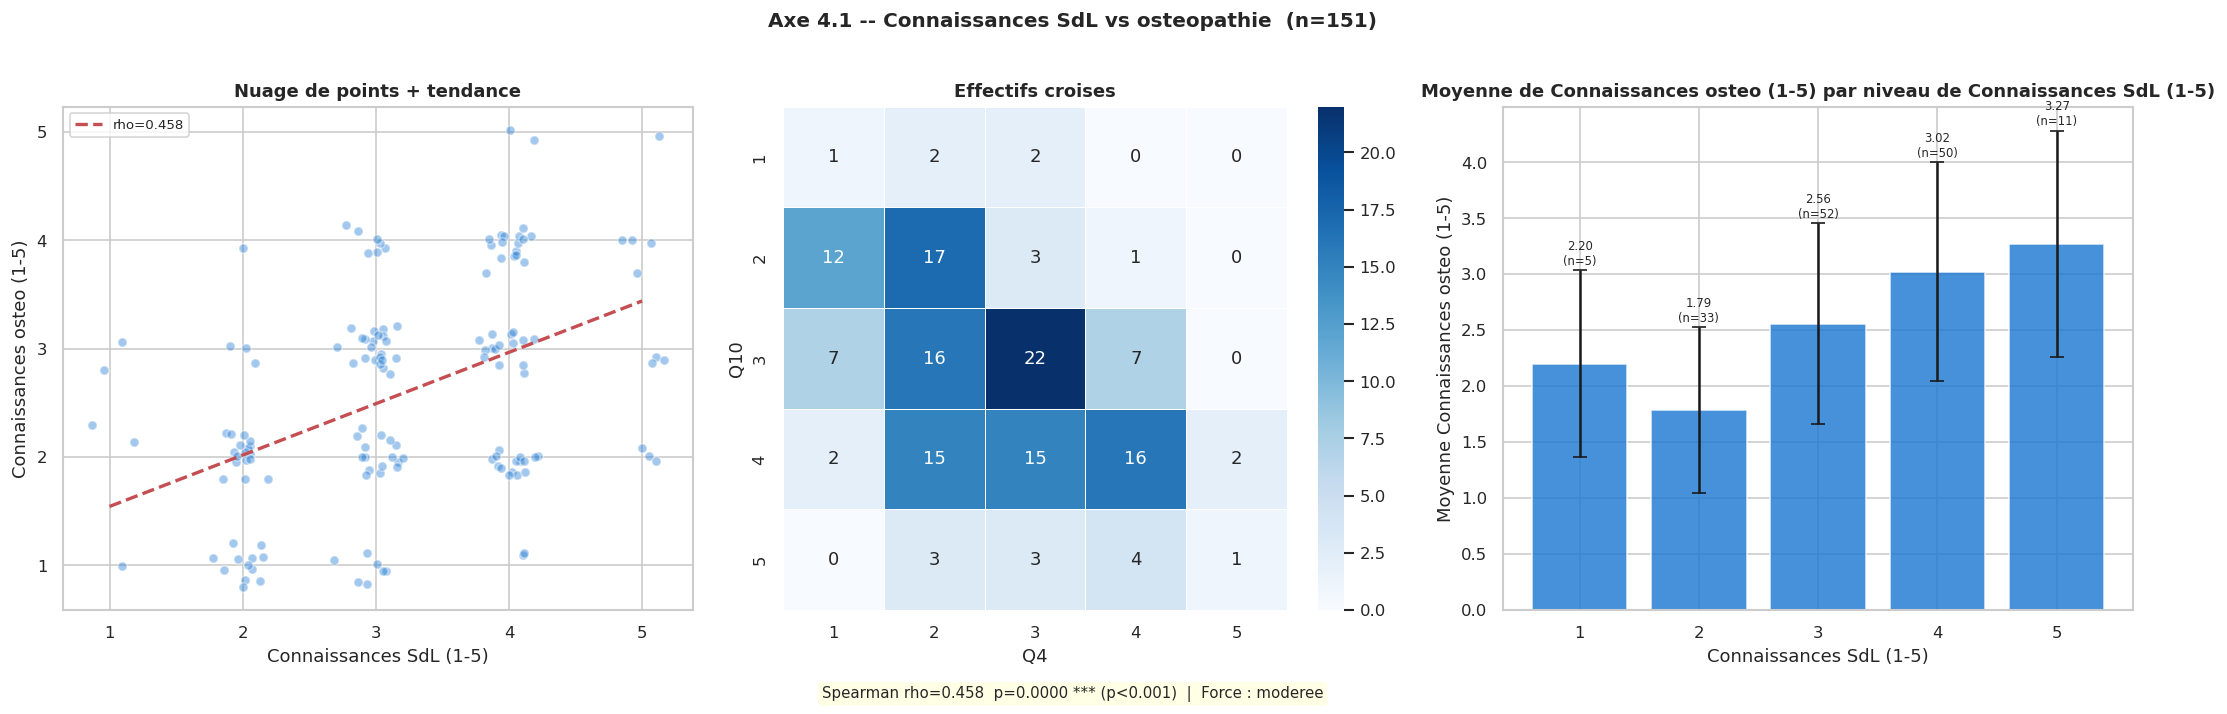

---


In [35]:
r = analyse('Q10','Q4', "Axe 4.1 -- Connaissances SdL vs osteopathie", "Connait-on mieux le syndrome ou le traitement ?")
if r: results.append(r)

### Axe 4.1 -- Connaissances SdL selon frequence

*Rencontrer souvent ameliore les connaissances ?*

**Connaissances SdL (1-5)** x **Frequence SdL** | n = 149 | Test : Q12(nom,5grp) x Q10(ord) -> Kruskal-Wallis H

**Effectifs observes :**

Q10                                           1   2   3   4   5  Total
Q12                                                                   
A chaque suivi                                0   0   0   1   0      1
Fréquemment (> ou = à 1 fois par semaine)     2   9  20  31   5     67
Jamais                                        0   2   1   0   0      3
Occasionnellement (> ou = à 1 fois par mois)  2  14  22  12   5     55
Rarement (> ou = à 1 fois tous les 3 mois)    0   7   9   6   1     23
Total                                         4  32  52  50  11    149

**Pourcentages en ligne (%) :**

Q10                                             1     2     3      4    5
Q12                                                                      
A chaque suivi                                0.0   0.0   0.0  100.0  0.0
Fréquemment (> ou = à 1 fois par semaine)     3.0  13.4  29.9   46.3  7.5
Jamais                                        0.0  66.7  33.3    0.0  0.0
Occasionnellement (> ou = à 1 fois par mois)  3.6  25.5  40.0   21.8  9.1
Rarement (> ou = à 1 fois tous les 3 mois)    0.0  30.4  39.1   26.1  4.3

**Statistiques par groupe :**

count  mean   std  min  25%  \
Q12                                                                         
A chaque suivi                                  1.0  4.00   NaN  4.0  4.0   
Fréquemment (> ou = à 1 fois par semaine)      67.0  3.42  0.92  1.0  3.0   
Jamais                                          3.0  2.33  0.58  2.0  2.0   
Occasionnellement (> ou = à 1 fois par mois)   55.0  3.07  1.00  1.0  2.0   
Rarement (> ou = à 1 fois tous les 3 mois)     23.0  3.04  0.88  2.0  2.0   

                                              50%  75%  max  
Q12                                                          
A chaque suivi                                4.0  4.0  4.0  
Fréquemment (> ou = à 1 fois par semaine)     4.0  4.0  5.0  
Jamais                                        2.0  2.5  3.0  
Occasionnellement (> ou = à 1 fois par mois)  3.0  4.0  5.0  
Rarement (> ou = à 1 fois tous les 3 mois)    3.0  4.0  5.0

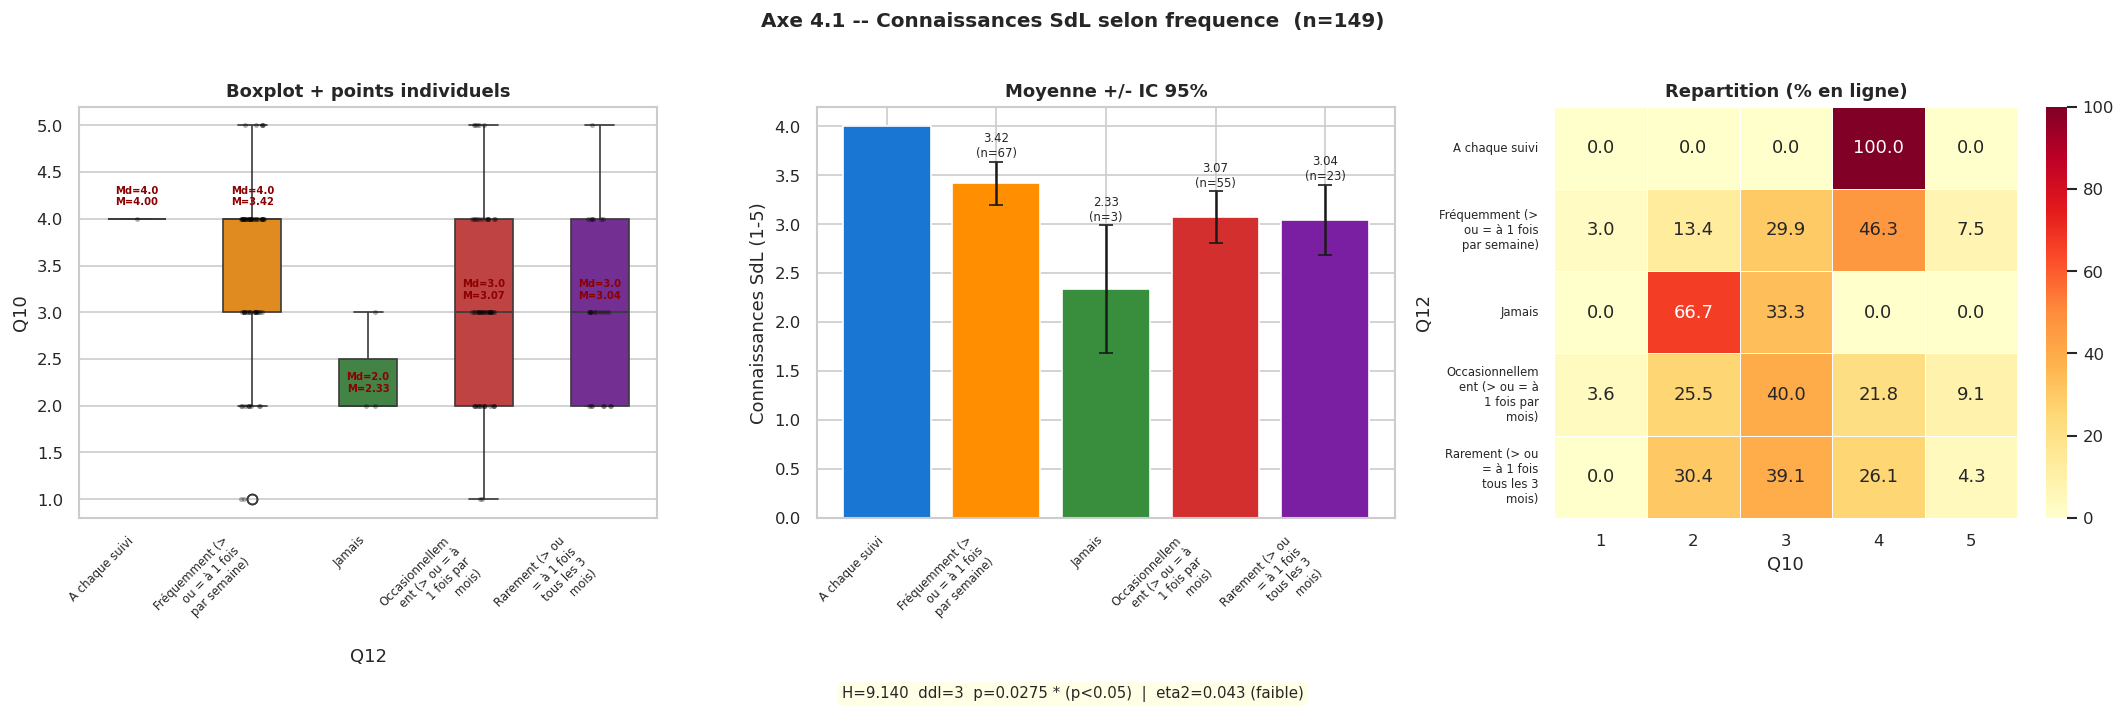

**Comparaisons post-hoc (Bonferroni) :**

Comp       U  p brut p Bonf.  \
0  Fréquemment (> ou = à 1 fois par semaine) vs J...   167.0  0.0416  0.2494   
1  Fréquemment (> ou = à 1 fois par semaine) vs O...  2249.5  0.0282  0.1691   
2  Fréquemment (> ou = à 1 fois par semaine) vs R...   963.0  0.0599  0.3595   
3  Jamais vs Occasionnellement (> ou = à 1 fois p...    45.0  0.1727  1.0000   
4  Jamais vs Rarement (> ou = à 1 fois tous les 3...    18.5  0.1874  1.0000   
5  Occasionnellement (> ou = à 1 fois par mois) v...   642.5  0.9129  1.0000   

  Sig.  
0  Non  
1  Non  
2  Non  
3  Non  
4  Non  
5  Non

---


In [36]:
r = analyse('Q10','Q12', "Axe 4.1 -- Connaissances SdL selon frequence", "Rencontrer souvent ameliore les connaissances ?")
if r: results.append(r)

### Axe 4.1 -- Connaissances SdL selon statut

*Le referentiel s'est-il ameliore ?*

**Connaissances SdL (1-5)** x **Statut** | n = 151 | Test : Q1(nom,2grp) x Q10(ord) -> Mann-Whitney U

**Effectifs observes :**

Q10                                 1   2   3   4   5  Total
Q1                                                          
Sage-femme diplômé(e)               2  14  32  32  10     90
Étudiant(e) sage-femme en 5e année  3  19  20  18   1     61
Total                               5  33  52  50  11    151

**Pourcentages en ligne (%) :**

Q10                                   1     2     3     4     5
Q1                                                             
Sage-femme diplômé(e)               2.2  15.6  35.6  35.6  11.1
Étudiant(e) sage-femme en 5e année  4.9  31.1  32.8  29.5   1.6

**Statistiques par groupe :**

count  mean   std  min  25%  50%  75%  max
Q1                                                                            
Sage-femme diplômé(e)                90.0  3.38  0.95  1.0  3.0  3.0  4.0  5.0
Étudiant(e) sage-femme en 5e année   61.0  2.92  0.94  1.0  2.0  3.0  4.0  5.0

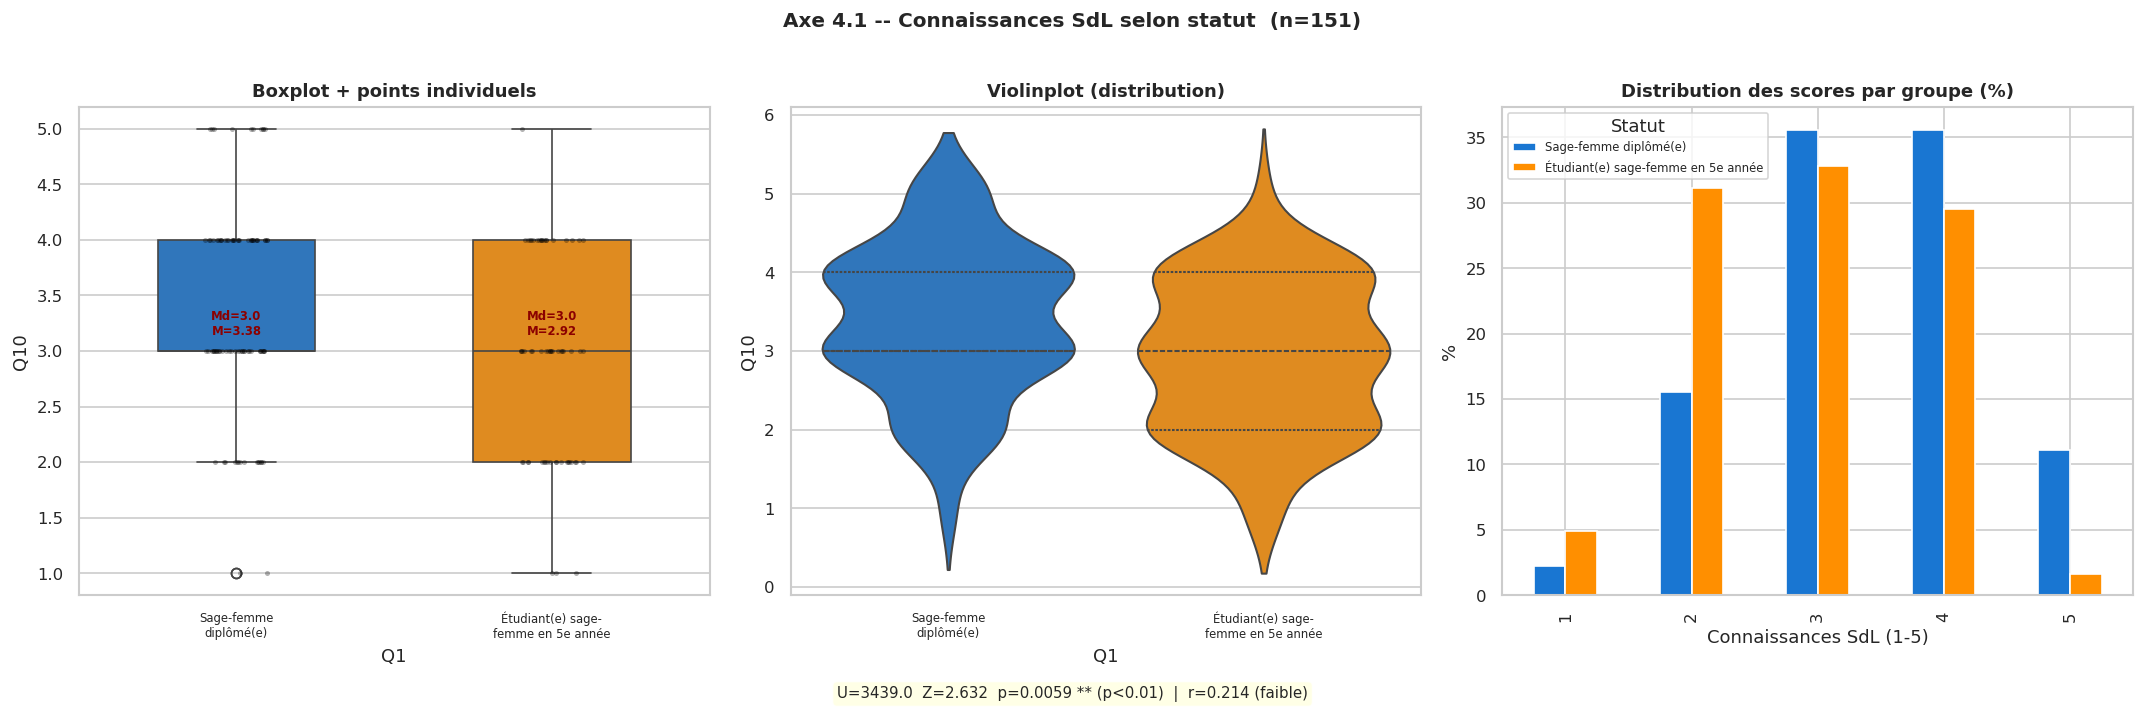

---


In [37]:
r = analyse('Q10','Q1', "Axe 4.1 -- Connaissances SdL selon statut", "Le referentiel s'est-il ameliore ?")
if r: results.append(r)

### 4.2 Retard diagnostic (H4)

### Axe 4.2 -- Retard selon connaissances SdL

*Celles qui connaissent mieux percoivent plus le retard ?*

**Retard diagnostic** x **Connaissances SdL (1-5)** | n = 151 | Test : Q13(nom,3grp) x Q10(ord) -> Kruskal-Wallis H

**Effectifs observes :**

Q10        1   2   3   4   5  Total
Q13                                
Non        1   3   5  18   6     33
Oui        3  21  28  18   5     75
Sans avis  1   9  19  14   0     43
Total      5  33  52  50  11    151

**Pourcentages en ligne (%) :**

Q10          1     2     3     4     5
Q13                                   
Non        3.0   9.1  15.2  54.5  18.2
Oui        4.0  28.0  37.3  24.0   6.7
Sans avis  2.3  20.9  44.2  32.6   0.0

**Statistiques par groupe :**

count  mean   std  min  25%  50%  75%  max
Q13                                                  
Non         33.0  3.76  0.97  1.0  3.0  4.0  4.0  5.0
Oui         75.0  3.01  0.98  1.0  2.0  3.0  4.0  5.0
Sans avis   43.0  3.07  0.80  1.0  3.0  3.0  4.0  4.0

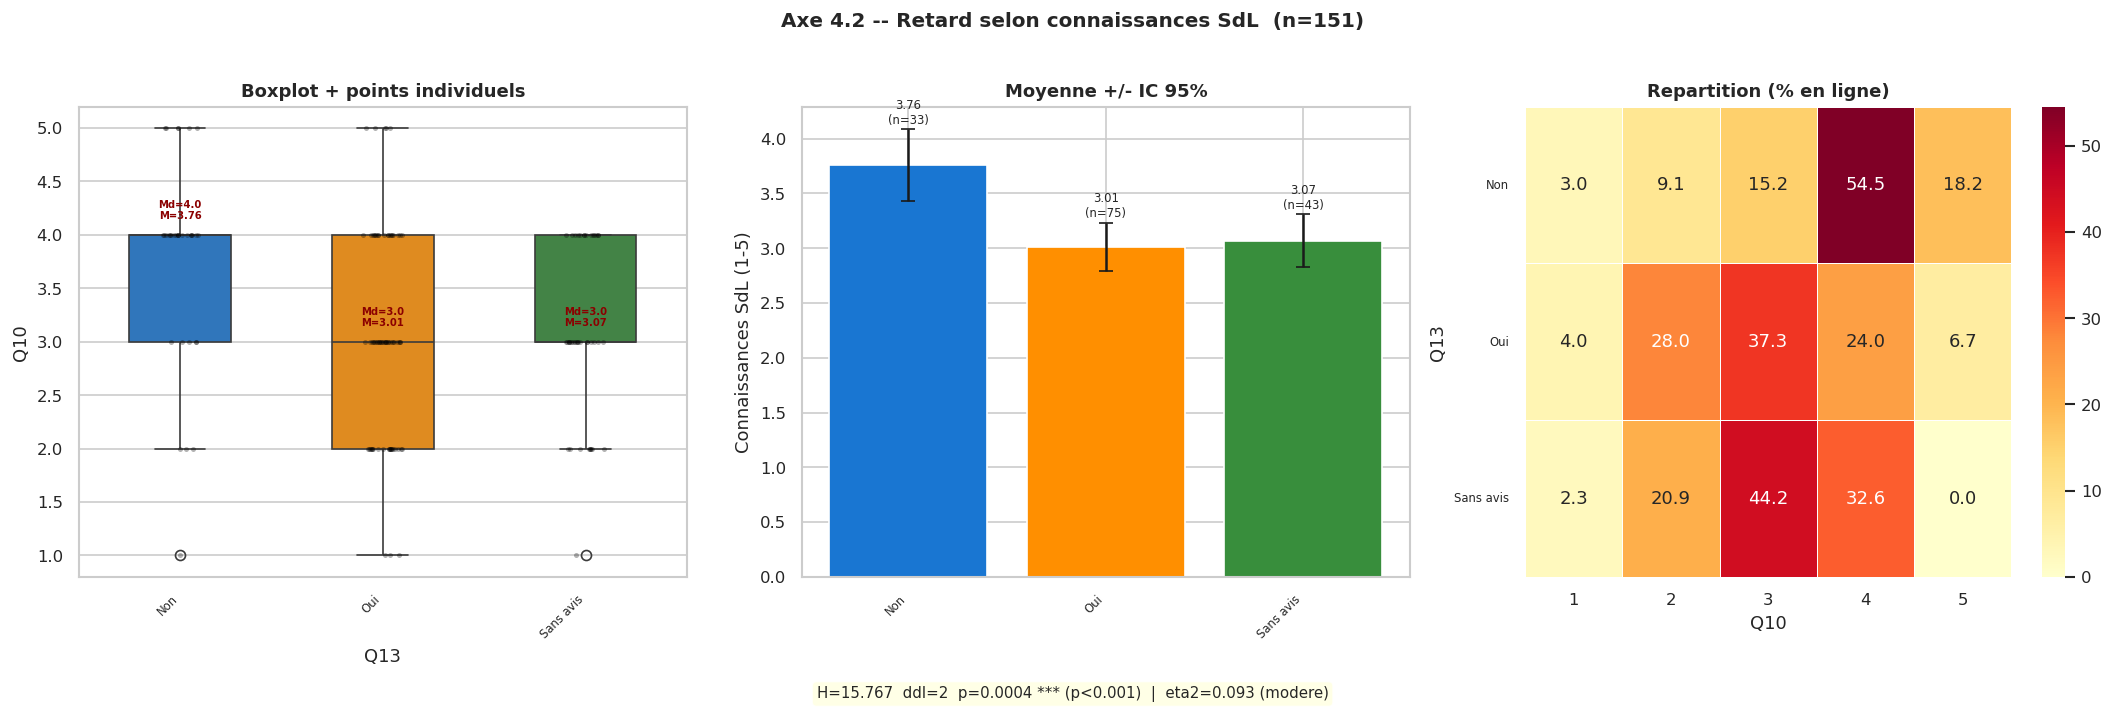

**Comparaisons post-hoc (Bonferroni) :**

Comp       U  p brut p Bonf. Sig.
0        Non vs Oui  1765.0  0.0003  0.0008  Oui
1  Non vs Sans avis  1020.5  0.0006  0.0017  Oui
2  Oui vs Sans avis  1526.0  0.6123  1.0000  Non

---


In [38]:
r = analyse('Q13','Q10', "Axe 4.2 -- Retard selon connaissances SdL", "Celles qui connaissent mieux percoivent plus le retard ?")
if r: results.append(r)

### Axe 4.2 -- Retard selon anciennete

*Causes differentes selon experience ?*

**Retard diagnostic** x **Anciennete** | n = 90 | Test : Q13(nom) x Q2(nom) -> Chi-deux

**Effectifs observes :**

Q2         2 à 5 ans  5 à 10 ans  Moins de 2 ans  Plus de 10 ans  Total
Q13                                                                    
Non                4           2               2              18     26
Oui                3           7               3              24     37
Sans avis          0           6               4              17     27
Total              7          15               9              59     90

**Pourcentages en colonne (%) :**

Q2         2 à 5 ans  5 à 10 ans  Moins de 2 ans  Plus de 10 ans
Q13                                                             
Non             57.1        13.3            22.2            30.5
Oui             42.9        46.7            33.3            40.7
Sans avis        0.0        40.0            44.4            28.8

**Pourcentages en ligne (%) :**

Q2         2 à 5 ans  5 à 10 ans  Moins de 2 ans  Plus de 10 ans
Q13                                                             
Non             15.4         7.7             7.7            69.2
Oui              8.1        18.9             8.1            64.9
Sans avis        0.0        22.2            14.8            63.0

**Effectifs theoriques :**

Q2         2 à 5 ans  5 à 10 ans  Moins de 2 ans  Plus de 10 ans
Q13                                                             
Non              2.0         4.3             2.6            17.0
Oui              2.9         6.2             3.7            24.3
Sans avis        2.1         4.5             2.7            17.7

**Attention : 67% des effectifs theoriques < 5.**

**Residus standardises (contributions au Chi2) :**

Q2         2 à 5 ans  5 à 10 ans  Moins de 2 ans  Plus de 10 ans
Q13                                                             
Non             1.39       -1.12           -0.37            0.23
Oui             0.07        0.34           -0.36           -0.05
Sans avis      -1.45        0.71            0.79           -0.17

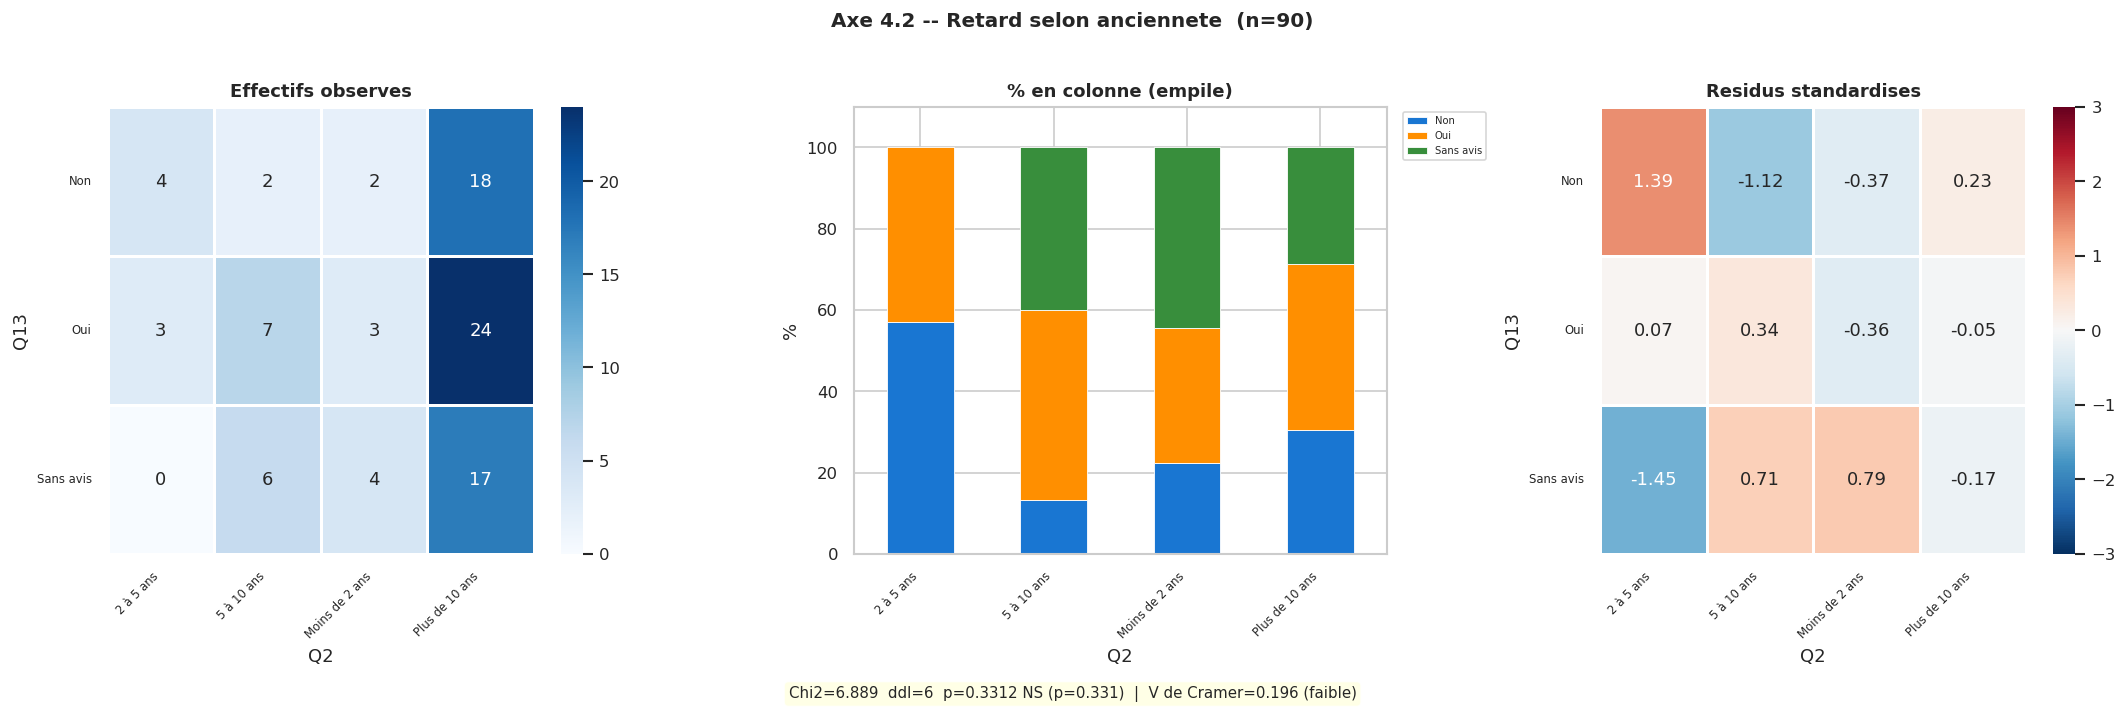

---


In [39]:
r = analyse('Q13','Q2', "Axe 4.2 -- Retard selon anciennete", "Causes differentes selon experience ?")
if r: results.append(r)

### Axe 4.2 -- Retard et moment orientation

*Percevoir retard influence orientation ?*

**Retard diagnostic** x **Moment orientation** | n = 144 | Test : Q13(nom) x Q17(nom) -> Chi-deux

**Effectifs observes :**

Q17        Dès les premiers symptômes  \
Q13                                     
Non                                18   
Oui                                50   
Sans avis                          29   
Total                              97   

Q17        En cas d’absence de réussite d’autres prises en charge  \
Q13                                                                 
Non                                                       13        
Oui                                                       16        
Sans avis                                                  7        
Total                                                     36        

Q17        En fin de grossesse  En post-partum  \
Q13                                              
Non                          1               0   
Oui                          5               0   
Sans avis                    3               1   
Total                        9               1   

Q17        Prise en charge prénatale et post-partum  Total  
Q13                                                         
Non                                               0     32  
Oui                                               1     72  
Sans avis                                         0     40  
Total                                             1    144

**Pourcentages en colonne (%) :**

Q17        Dès les premiers symptômes  \
Q13                                     
Non                              18.6   
Oui                              51.5   
Sans avis                        29.9   

Q17        En cas d’absence de réussite d’autres prises en charge  \
Q13                                                                 
Non                                                     36.1        
Oui                                                     44.4        
Sans avis                                               19.4        

Q17        En fin de grossesse  En post-partum  \
Q13                                              
Non                       11.1             0.0   
Oui                       55.6             0.0   
Sans avis                 33.3           100.0   

Q17        Prise en charge prénatale et post-partum  
Q13                                                  
Non                                             0.0  
Oui                                           100.0  
Sans avis                                       0.0

**Pourcentages en ligne (%) :**

Q17        Dès les premiers symptômes  \
Q13                                     
Non                              56.2   
Oui                              69.4   
Sans avis                        72.5   

Q17        En cas d’absence de réussite d’autres prises en charge  \
Q13                                                                 
Non                                                     40.6        
Oui                                                     22.2        
Sans avis                                               17.5        

Q17        En fin de grossesse  En post-partum  \
Q13                                              
Non                        3.1             0.0   
Oui                        6.9             0.0   
Sans avis                  7.5             2.5   

Q17        Prise en charge prénatale et post-partum  
Q13                                                  
Non                                             0.0  
Oui                                             1.4  
Sans avis                                       0.0

**Effectifs theoriques :**

Q17        Dès les premiers symptômes  \
Q13                                     
Non                              21.6   
Oui                              48.5   
Sans avis                        26.9   

Q17        En cas d’absence de réussite d’autres prises en charge  \
Q13                                                                 
Non                                                      8.0        
Oui                                                     18.0        
Sans avis                                               10.0        

Q17        En fin de grossesse  En post-partum  \
Q13                                              
Non                        2.0             0.2   
Oui                        4.5             0.5   
Sans avis                  2.5             0.3   

Q17        Prise en charge prénatale et post-partum  
Q13                                                  
Non                                             0.2  
Oui                                             0.5  
Sans avis                                       0.3

**Attention : 60% des effectifs theoriques < 5.**

**Residus standardises (contributions au Chi2) :**

Q17        Dès les premiers symptômes  \
Q13                                     
Non                             -0.77   
Oui                              0.22   
Sans avis                        0.40   

Q17        En cas d’absence de réussite d’autres prises en charge  \
Q13                                                                 
Non                                                     1.77        
Oui                                                    -0.47        
Sans avis                                              -0.95        

Q17        En fin de grossesse  En post-partum  \
Q13                                              
Non                      -0.71           -0.47   
Oui                       0.24           -0.71   
Sans avis                 0.32            1.37   

Q17        Prise en charge prénatale et post-partum  
Q13                                                  
Non                                           -0.47  
Oui                                            0.71  
Sans avis                                     -0.53

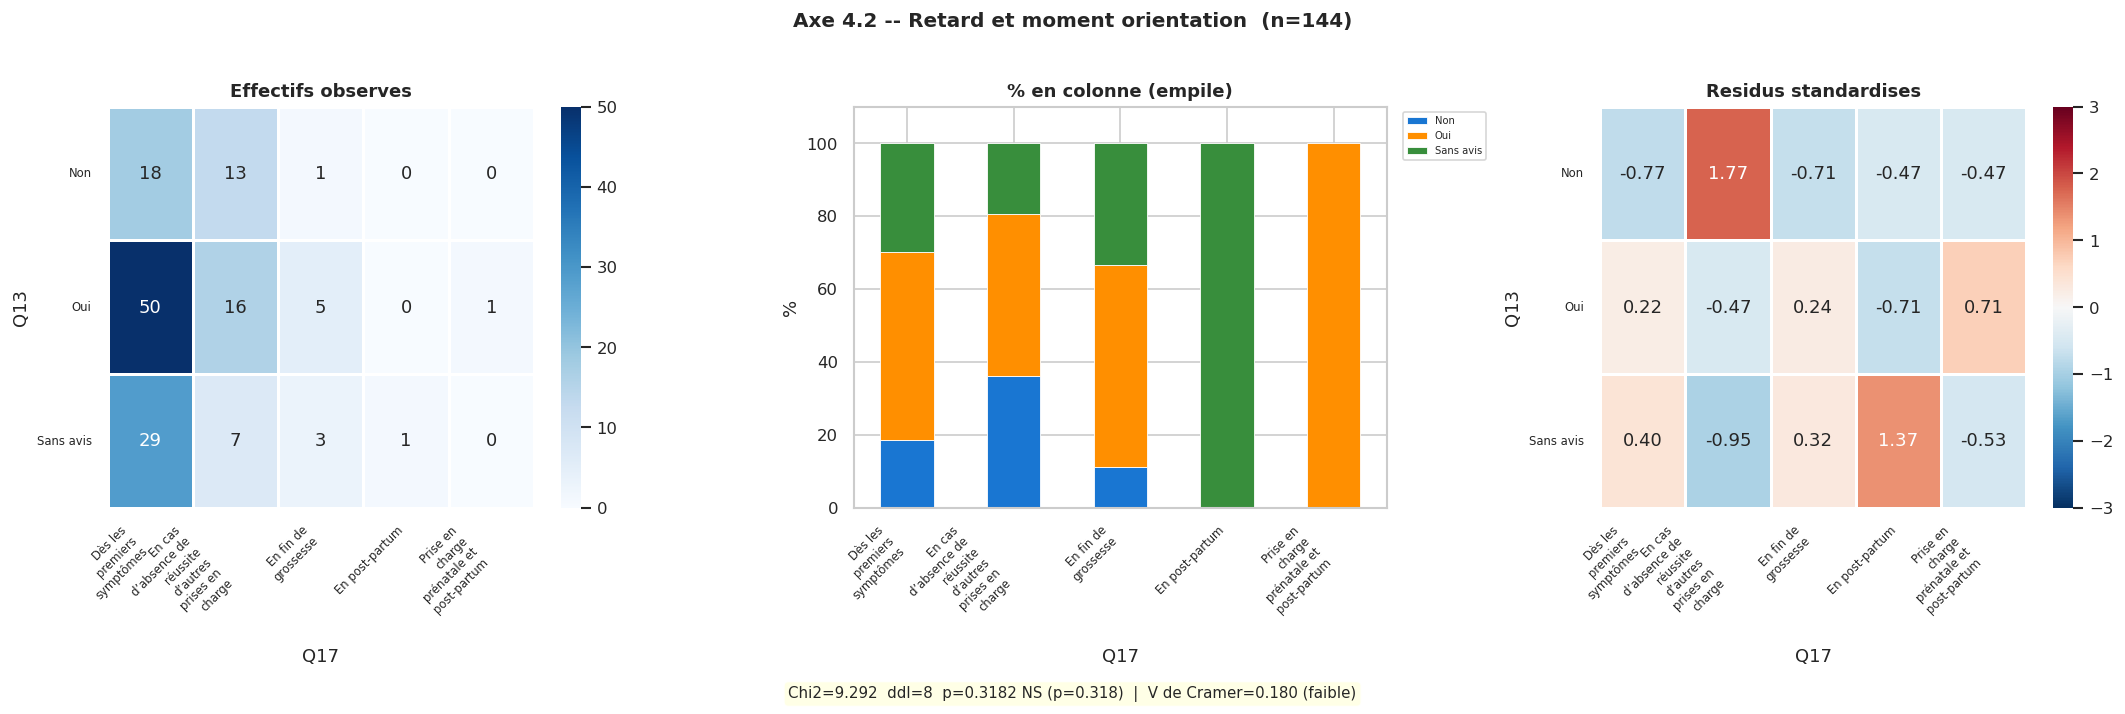

---


In [40]:
r = analyse('Q13','Q17', "Axe 4.2 -- Retard et moment orientation", "Percevoir retard influence orientation ?")
if r: results.append(r)

### 4.3 SdL comme cas d'ecole

### Axe 4.3 -- Rang osteo selon favorabilite

*Les favorables classent-elles mieux l'osteo ?*

**Rang osteo (1-6)** x **Favorabilite (1-5)** | n = 148 | Test : Q15_osteo_rank(ord) x Q16(ord) -> Spearman

**Effectifs croises :**

Q16             1  2   3   4   5  Total
Q15_osteo_rank                         
1.0             0  4   8  23  37     72
2.0             1  0   6  26  18     51
3.0             1  1   2  11   3     18
4.0             1  0   2   3   1      7
Total           3  5  18  63  59    148

**Pourcentages du total (%) :**

Q16               1    2    3     4     5
Q15_osteo_rank                           
1.0             0.0  2.7  5.4  15.5  25.0
2.0             0.7  0.0  4.1  17.6  12.2
3.0             0.7  0.7  1.4   7.4   2.0
4.0             0.7  0.0  1.4   2.0   0.7

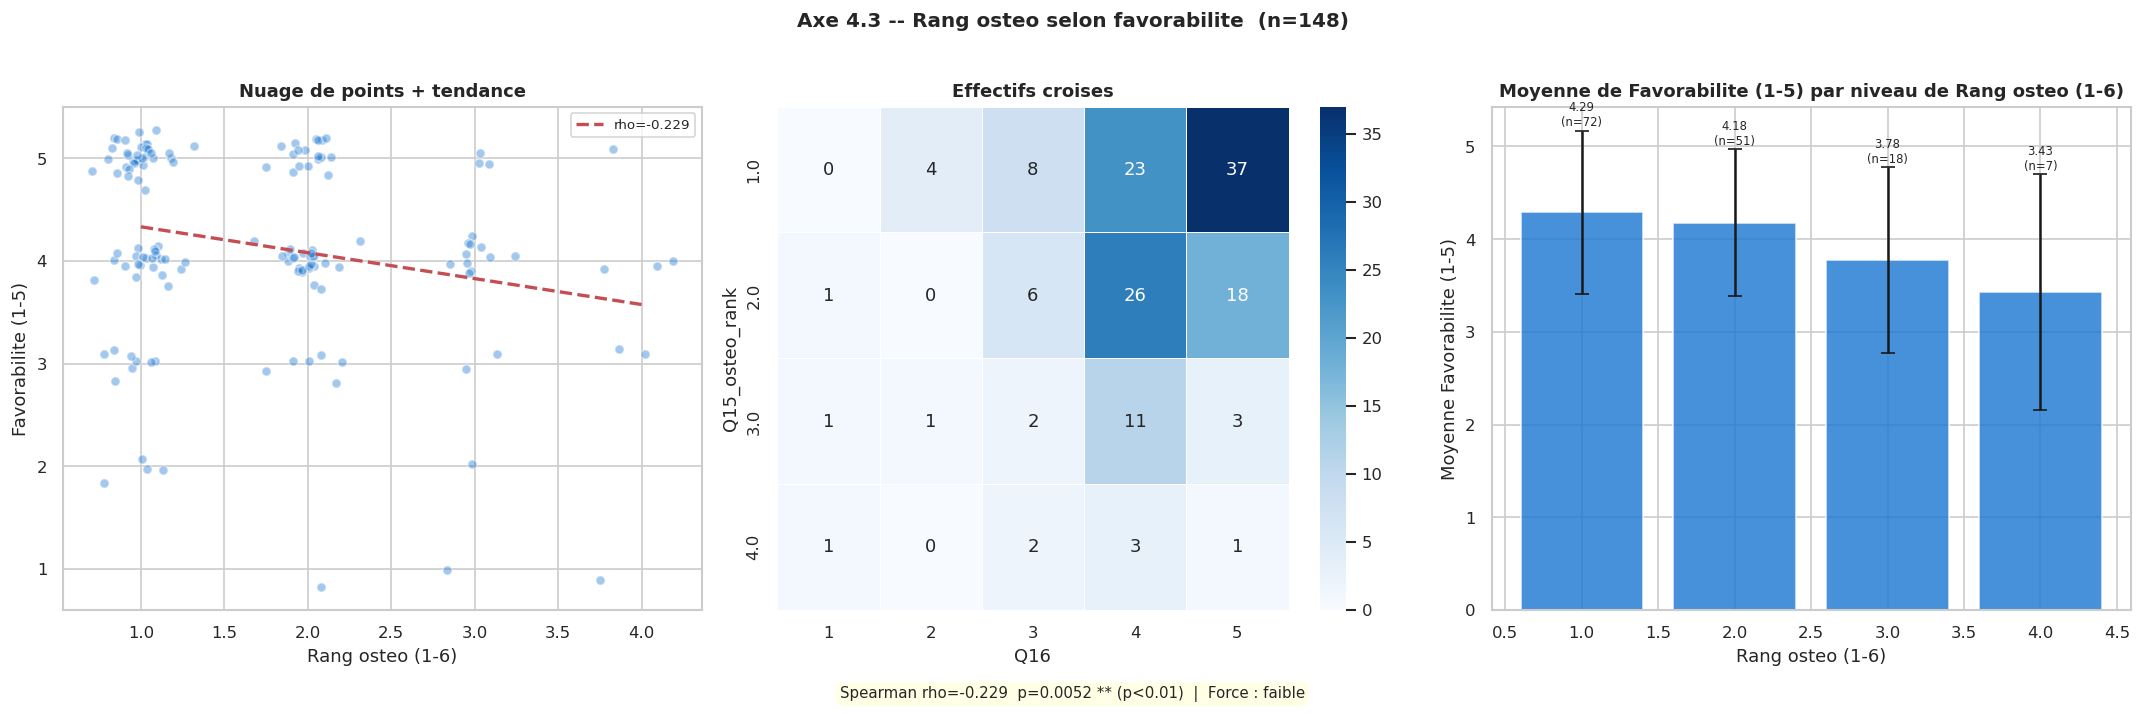

---


In [41]:
r = analyse('Q15_osteo_rank','Q16', "Axe 4.3 -- Rang osteo selon favorabilite", "Les favorables classent-elles mieux l'osteo ?")
if r: results.append(r)

### Axe 4.3 -- Rang osteo selon connaissances SdL

*Connaissances SdL influencent choix therapeutiques ?*

**Rang osteo (1-6)** x **Connaissances SdL (1-5)** | n = 148 | Test : Q15_osteo_rank(ord) x Q10(ord) -> Spearman

**Effectifs croises :**

Q10             1   2   3   4   5  Total
Q15_osteo_rank                          
1.0             2  15  23  27   5     72
2.0             2  11  18  15   5     51
3.0             1   5   6   5   1     18
4.0             0   1   3   3   0      7
Total           5  32  50  50  11    148

**Pourcentages du total (%) :**

Q10               1     2     3     4    5
Q15_osteo_rank                            
1.0             1.4  10.1  15.5  18.2  3.4
2.0             1.4   7.4  12.2  10.1  3.4
3.0             0.7   3.4   4.1   3.4  0.7
4.0             0.0   0.7   2.0   2.0  0.0

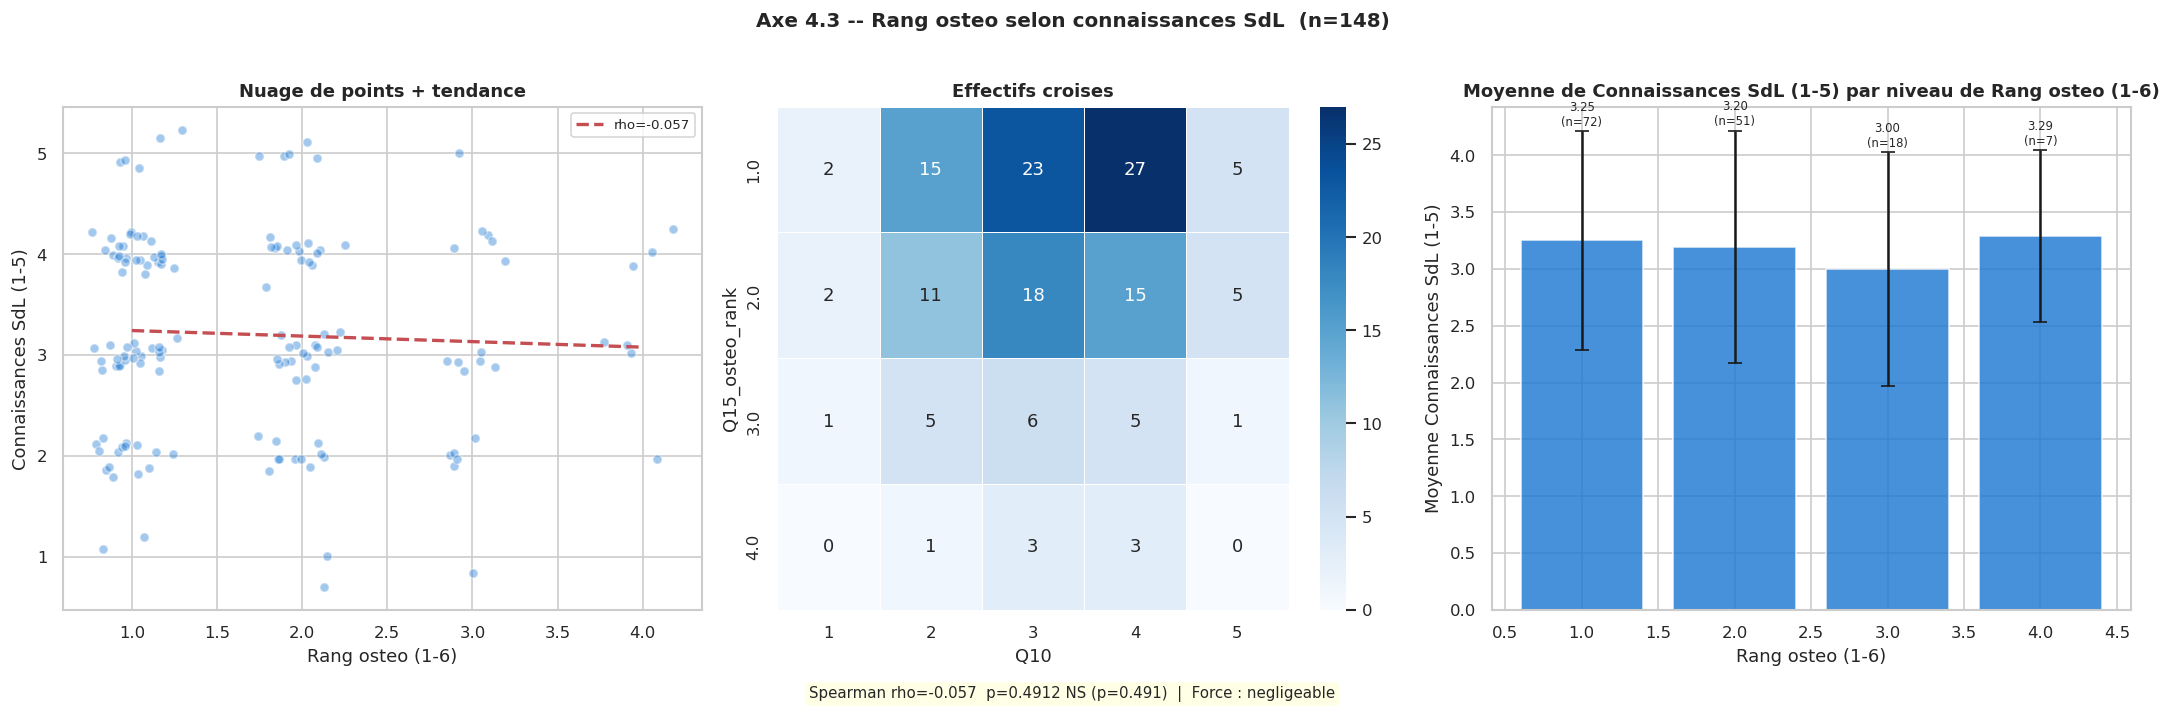

---


In [42]:
r = analyse('Q15_osteo_rank','Q10', "Axe 4.3 -- Rang osteo selon connaissances SdL", "Connaissances SdL influencent choix therapeutiques ?")
if r: results.append(r)

---
## AXE 5 : PERSPECTIVES
### 5.1 Volonte d'evolution

### Axe 5.1 -- Amelioration PEC selon collaboration

*Non-collaborantes reconnaissent l'interet ?*

**Amelioration PEC** x **Collaboration (Oui/Non)** | n = 151 | Test : Q23(nom) x Q8_bin(nom) -> Chi-deux

**Effectifs observes :**

Q8_bin     Non  Oui  Total
Q23                       
Non          4    1      5
Oui         38  101    139
Sans avis    2    5      7
Total       44  107    151

**Pourcentages en colonne (%) :**

Q8_bin      Non   Oui
Q23                  
Non         9.1   0.9
Oui        86.4  94.4
Sans avis   4.5   4.7

**Pourcentages en ligne (%) :**

Q8_bin      Non   Oui
Q23                  
Non        80.0  20.0
Oui        27.3  72.7
Sans avis  28.6  71.4

**Effectifs theoriques :**

Q8_bin      Non   Oui
Q23                  
Non         1.5   3.5
Oui        40.5  98.5
Sans avis   2.0   5.0

**Attention : 67% des effectifs theoriques < 5.**

**Residus standardises (contributions au Chi2) :**

Q8_bin      Non   Oui
Q23                  
Non        2.11 -1.35
Oui       -0.39  0.25
Sans avis -0.03  0.02

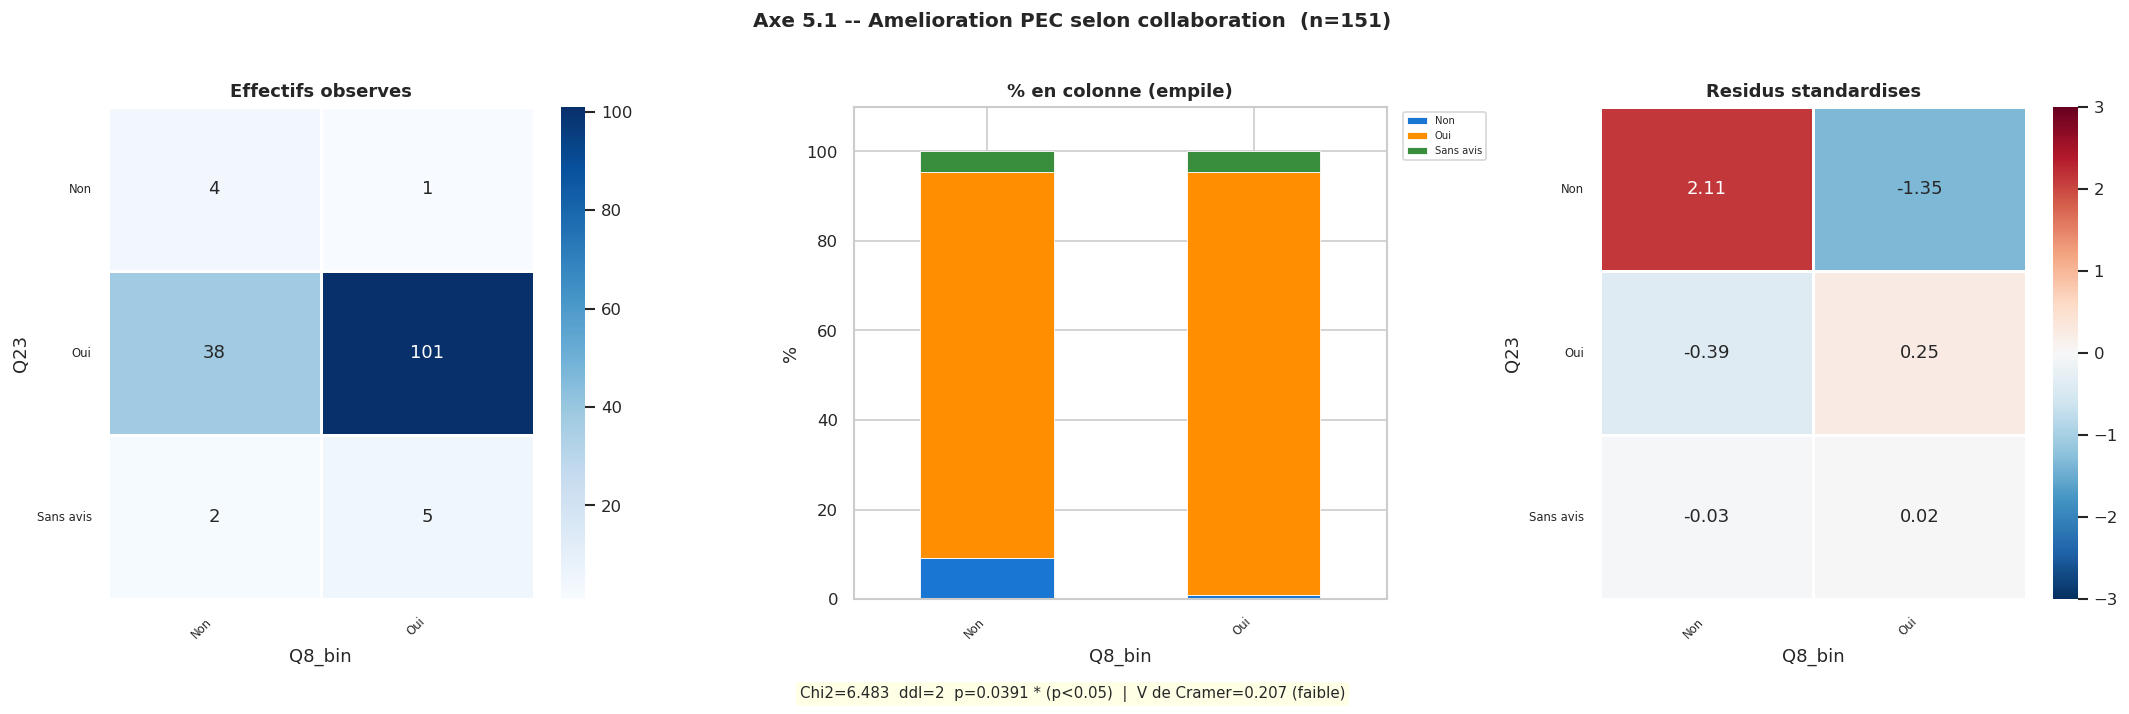

---


In [43]:
r = analyse('Q23','Q8_bin', "Axe 5.1 -- Amelioration PEC selon collaboration", "Non-collaborantes reconnaissent l'interet ?")
if r: results.append(r)

### Axe 5.1 -- Integration selon collaboration

*Non-collaborantes favorables a integration ?*

**Integration pluridisciplinaire** x **Collaboration (Oui/Non)** | n = 151 | Test : Q24(nom) x Q8_bin(nom) -> Chi-deux

**Effectifs observes :**

Q8_bin     Non  Oui  Total
Q24                       
Non          6    1      7
Oui         35  101    136
Sans avis    3    5      8
Total       44  107    151

**Pourcentages en colonne (%) :**

Q8_bin      Non   Oui
Q24                  
Non        13.6   0.9
Oui        79.5  94.4
Sans avis   6.8   4.7

**Pourcentages en ligne (%) :**

Q8_bin      Non   Oui
Q24                  
Non        85.7  14.3
Oui        25.7  74.3
Sans avis  37.5  62.5

**Effectifs theoriques :**

Q8_bin      Non   Oui
Q24                  
Non         2.0   5.0
Oui        39.6  96.4
Sans avis   2.3   5.7

**Attention : 50% des effectifs theoriques < 5.**

**Residus standardises (contributions au Chi2) :**

Q8_bin      Non   Oui
Q24                  
Non        2.77 -1.78
Oui       -0.74  0.47
Sans avis  0.44 -0.28

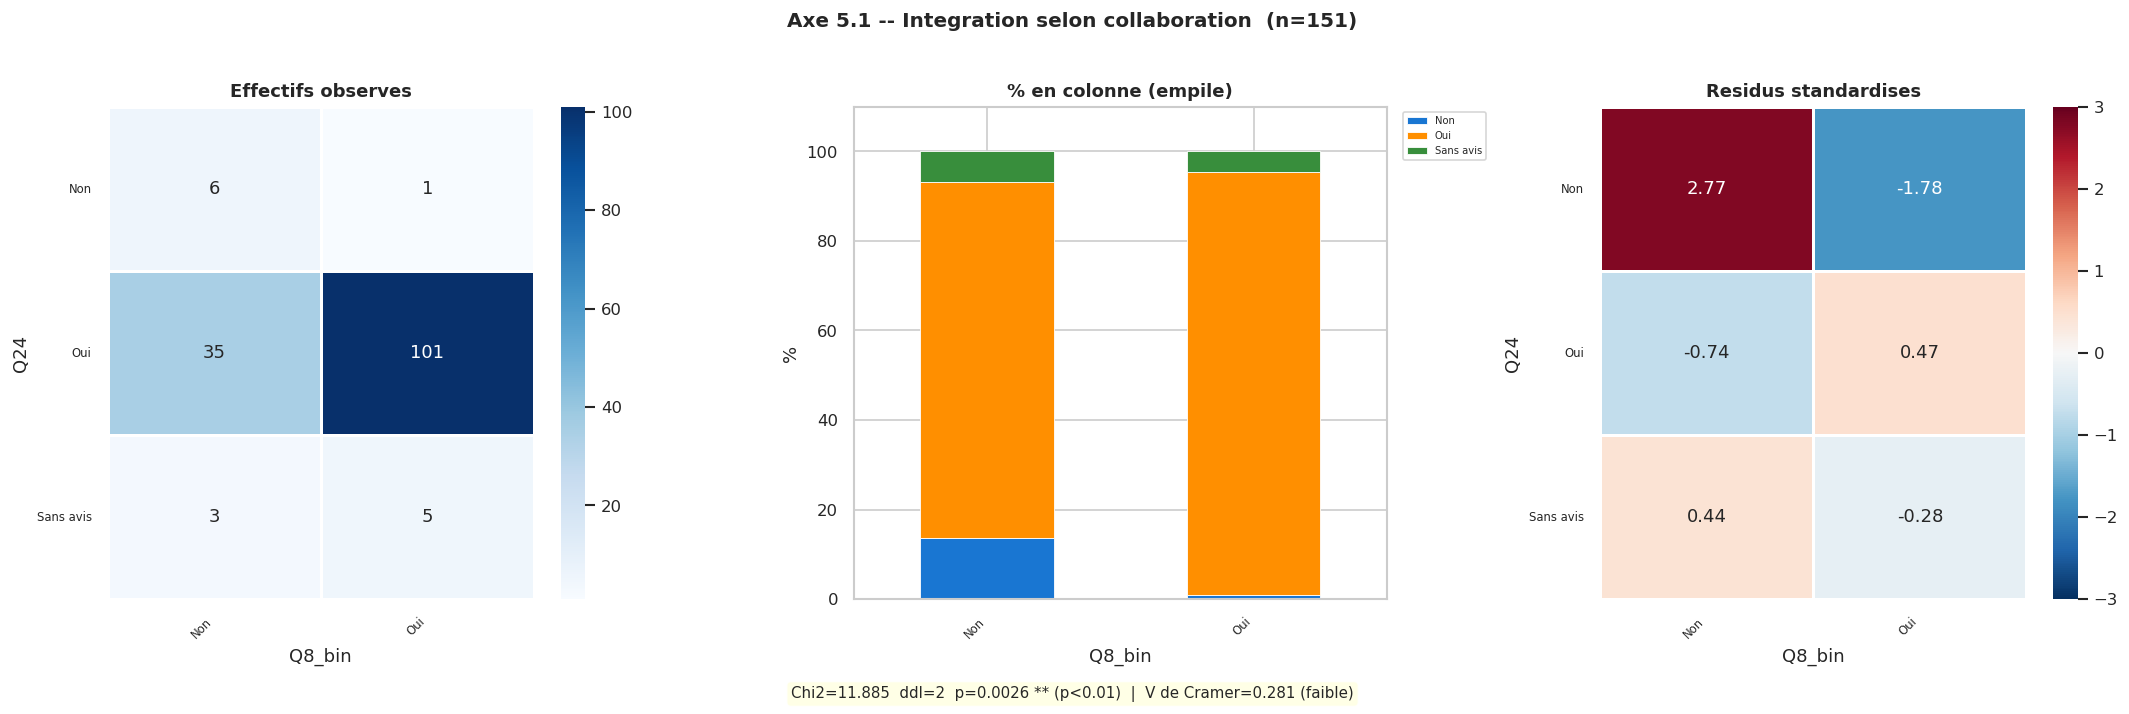

---


In [44]:
r = analyse('Q24','Q8_bin', "Axe 5.1 -- Integration selon collaboration", "Non-collaborantes favorables a integration ?")
if r: results.append(r)

### Axe 5.1 -- Coherence amelioration / integration

*Coherence entre les deux dimensions ?*

**Amelioration PEC** x **Integration pluridisciplinaire** | n = 151 | Test : Q23(nom) x Q24(nom) -> Chi-deux

**Effectifs observes :**

Q24        Non  Oui  Sans avis  Total
Q23                                  
Non          4    1          0      5
Oui          1  134          4    139
Sans avis    2    1          4      7
Total        7  136          8    151

**Pourcentages en colonne (%) :**

Q24         Non   Oui  Sans avis
Q23                             
Non        57.1   0.7        0.0
Oui        14.3  98.5       50.0
Sans avis  28.6   0.7       50.0

**Pourcentages en ligne (%) :**

Q24         Non   Oui  Sans avis
Q23                             
Non        80.0  20.0        0.0
Oui         0.7  96.4        2.9
Sans avis  28.6  14.3       57.1

**Effectifs theoriques :**

Q24        Non    Oui  Sans avis
Q23                             
Non        0.2    4.5        0.3
Oui        6.4  125.2        7.4
Sans avis  0.3    6.3        0.4

**Attention : 56% des effectifs theoriques < 5.**

**Residus standardises (contributions au Chi2) :**

Q24         Non   Oui  Sans avis
Q23                             
Non        7.83 -1.65      -0.51
Oui       -2.14  0.79      -1.24
Sans avis  2.94 -2.11       5.96

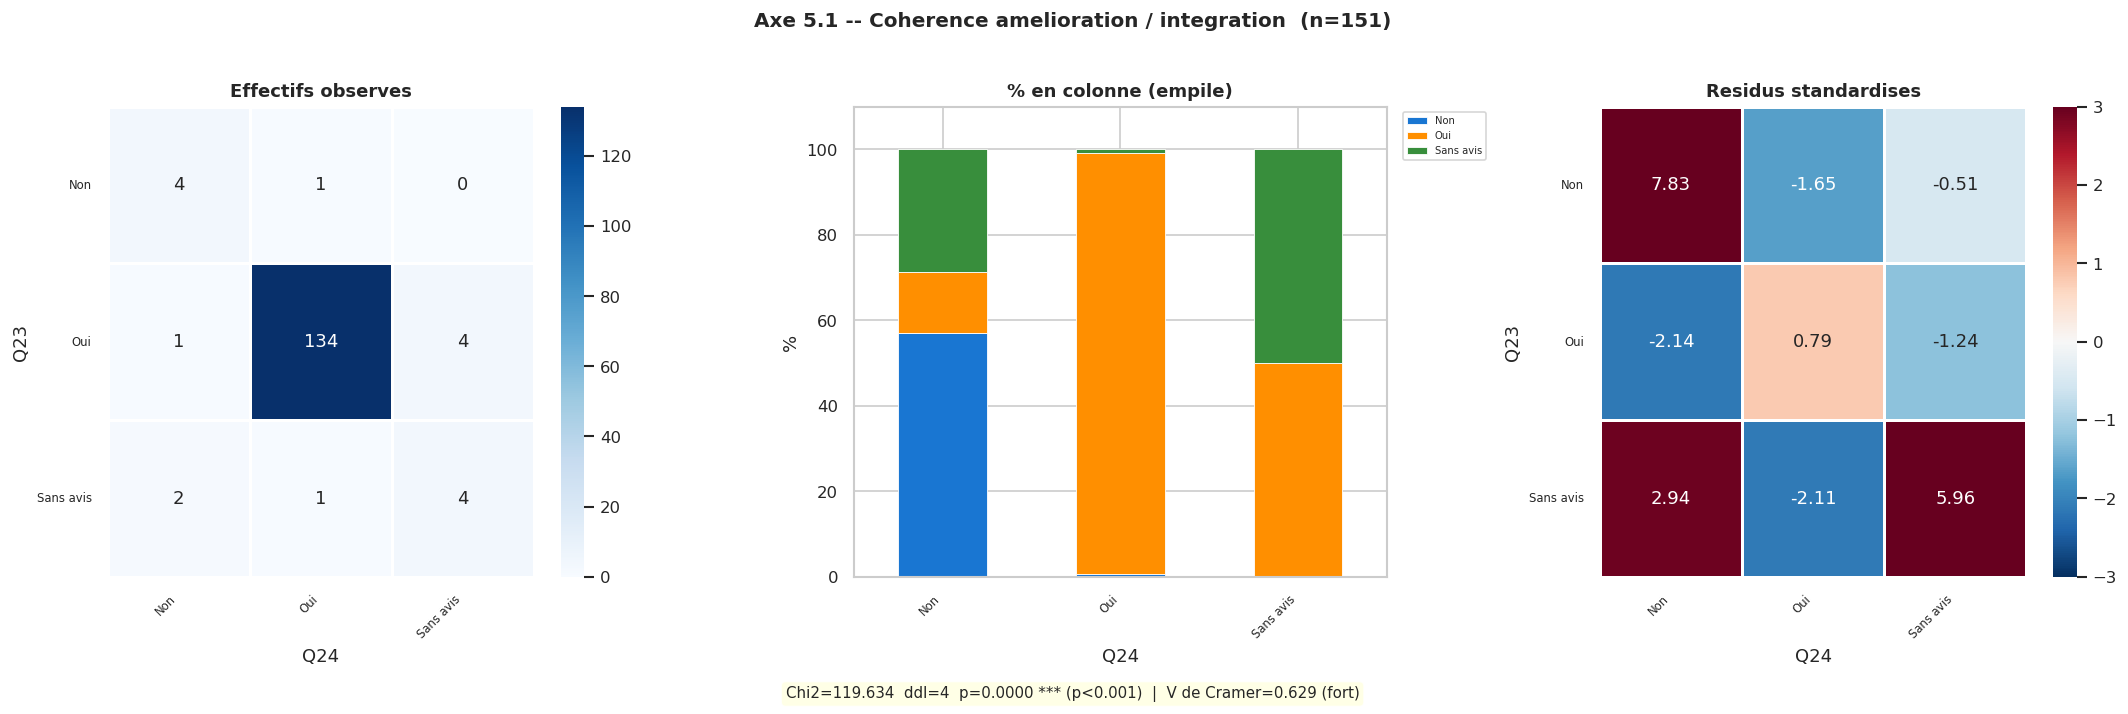

---


In [45]:
r = analyse('Q23','Q24', "Axe 5.1 -- Coherence amelioration / integration", "Coherence entre les deux dimensions ?")
if r: results.append(r)

### 5.2 Conditions necessaires

### Axe 5.2 -- Integration selon anciennete

*Priorites selon experience ?*

**Integration pluridisciplinaire** x **Anciennete** | n = 90 | Test : Q24(nom) x Q2(nom) -> Chi-deux

**Effectifs observes :**

Q2         2 à 5 ans  5 à 10 ans  Moins de 2 ans  Plus de 10 ans  Total
Q24                                                                    
Non                0           0               1               3      4
Oui                7          14               8              52     81
Sans avis          0           1               0               4      5
Total              7          15               9              59     90

**Pourcentages en colonne (%) :**

Q2         2 à 5 ans  5 à 10 ans  Moins de 2 ans  Plus de 10 ans
Q24                                                             
Non              0.0         0.0            11.1             5.1
Oui            100.0        93.3            88.9            88.1
Sans avis        0.0         6.7             0.0             6.8

**Pourcentages en ligne (%) :**

Q2         2 à 5 ans  5 à 10 ans  Moins de 2 ans  Plus de 10 ans
Q24                                                             
Non              0.0         0.0            25.0            75.0
Oui              8.6        17.3             9.9            64.2
Sans avis        0.0        20.0             0.0            80.0

**Effectifs theoriques :**

Q2         2 à 5 ans  5 à 10 ans  Moins de 2 ans  Plus de 10 ans
Q24                                                             
Non              0.3         0.7             0.4             2.6
Oui              6.3        13.5             8.1            53.1
Sans avis        0.4         0.8             0.5             3.3

**Attention : 67% des effectifs theoriques < 5.**

**Residus standardises (contributions au Chi2) :**

Q2         2 à 5 ans  5 à 10 ans  Moins de 2 ans  Plus de 10 ans
Q24                                                             
Non            -0.56       -0.82            0.95            0.23
Oui             0.28        0.14           -0.04           -0.15
Sans avis      -0.62        0.18           -0.71            0.40

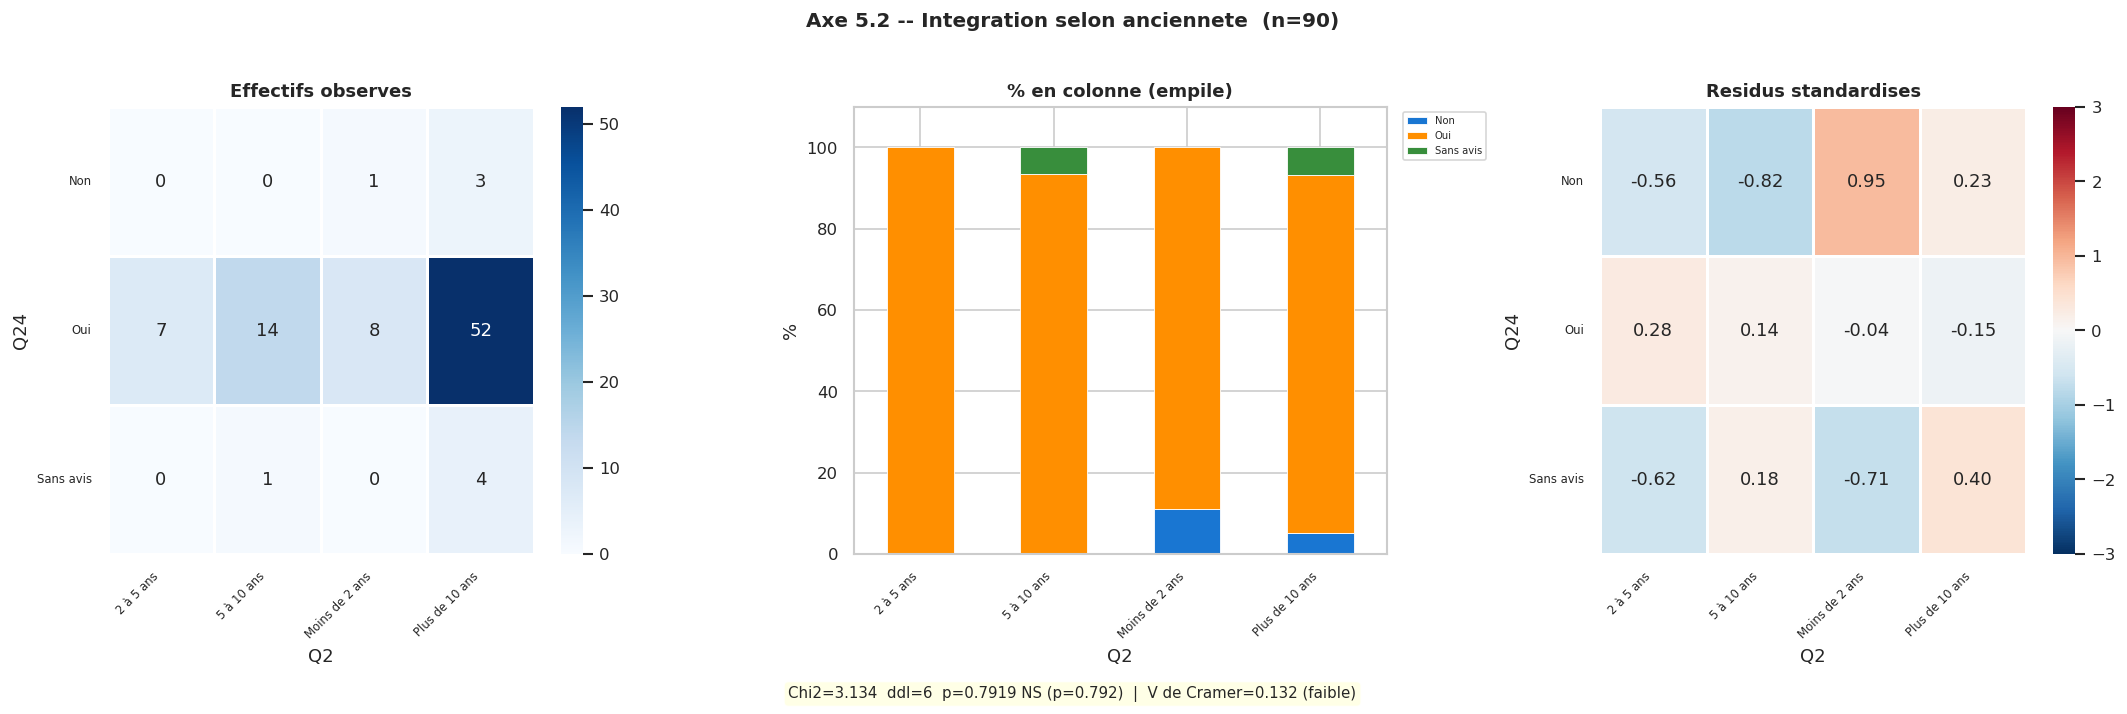

---


In [46]:
r = analyse('Q24','Q2', "Axe 5.2 -- Integration selon anciennete", "Priorites selon experience ?")
if r: results.append(r)

### Axe 5.2 -- Integration selon lieu

*Memes priorites liberal/hopital ?*

**Integration pluridisciplinaire** x **Lieu exercice** | n = 90 | Test : Q24(nom) x Q3(nom) -> Chi-deux

**Effectifs observes :**

Q3         Hospitalier  Libéral  Mixte  Total
Q24                                          
Non                  3        0      1      4
Oui                 49       30      2     81
Sans avis            5        0      0      5
Total               57       30      3     90

**Pourcentages en colonne (%) :**

Q3         Hospitalier  Libéral  Mixte
Q24                                   
Non                5.3      0.0   33.3
Oui               86.0    100.0   66.7
Sans avis          8.8      0.0    0.0

**Pourcentages en ligne (%) :**

Q3         Hospitalier  Libéral  Mixte
Q24                                   
Non               75.0      0.0   25.0
Oui               60.5     37.0    2.5
Sans avis        100.0      0.0    0.0

**Effectifs theoriques :**

Q3         Hospitalier  Libéral  Mixte
Q24                                   
Non                2.5      1.3    0.1
Oui               51.3     27.0    2.7
Sans avis          3.2      1.7    0.2

**Attention : 78% des effectifs theoriques < 5.**

**Residus standardises (contributions au Chi2) :**

Q3         Hospitalier  Libéral  Mixte
Q24                                   
Non               0.29    -1.15   2.37
Oui              -0.32     0.58  -0.43
Sans avis         1.03    -1.29  -0.41

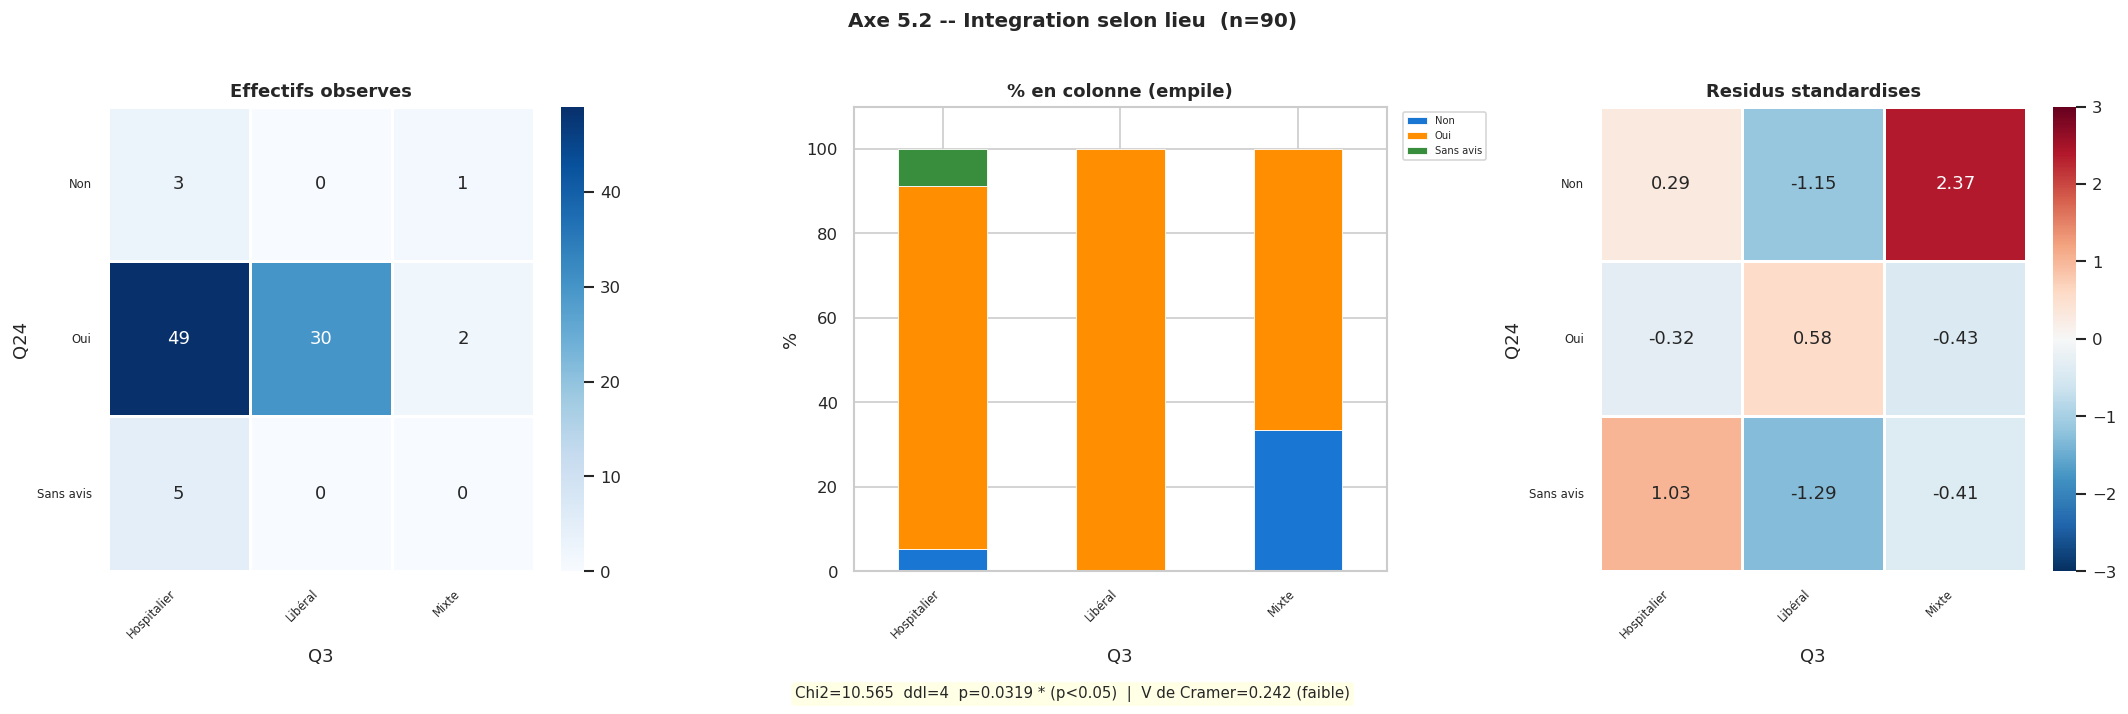

---


In [47]:
r = analyse('Q24','Q3', "Axe 5.2 -- Integration selon lieu", "Memes priorites liberal/hopital ?")
if r: results.append(r)

### Axe 5.2 -- Amelioration PEC selon statut

*Vision differente etudiants/diplomes ?*

**Amelioration PEC** x **Statut** | n = 151 | Test : Q23(nom) x Q1(nom) -> Chi-deux

**Effectifs observes :**

Q1         Sage-femme diplômé(e)  Étudiant(e) sage-femme en 5e année  Total
Q23                                                                        
Non                            2                                   3      5
Oui                           82                                  57    139
Sans avis                      6                                   1      7
Total                         90                                  61    151

**Pourcentages en colonne (%) :**

Q1         Sage-femme diplômé(e)  Étudiant(e) sage-femme en 5e année
Q23                                                                 
Non                          2.2                                 4.9
Oui                         91.1                                93.4
Sans avis                    6.7                                 1.6

**Pourcentages en ligne (%) :**

Q1         Sage-femme diplômé(e)  Étudiant(e) sage-femme en 5e année
Q23                                                                 
Non                         40.0                                60.0
Oui                         59.0                                41.0
Sans avis                   85.7                                14.3

**Effectifs theoriques :**

Q1         Sage-femme diplômé(e)  Étudiant(e) sage-femme en 5e année
Q23                                                                 
Non                          3.0                                 2.0
Oui                         82.8                                56.2
Sans avis                    4.2                                 2.8

**Attention : 67% des effectifs theoriques < 5.**

**Residus standardises (contributions au Chi2) :**

Q1         Sage-femme diplômé(e)  Étudiant(e) sage-femme en 5e année
Q23                                                                 
Non                        -0.57                                0.69
Oui                        -0.09                                0.11
Sans avis                   0.89                               -1.09

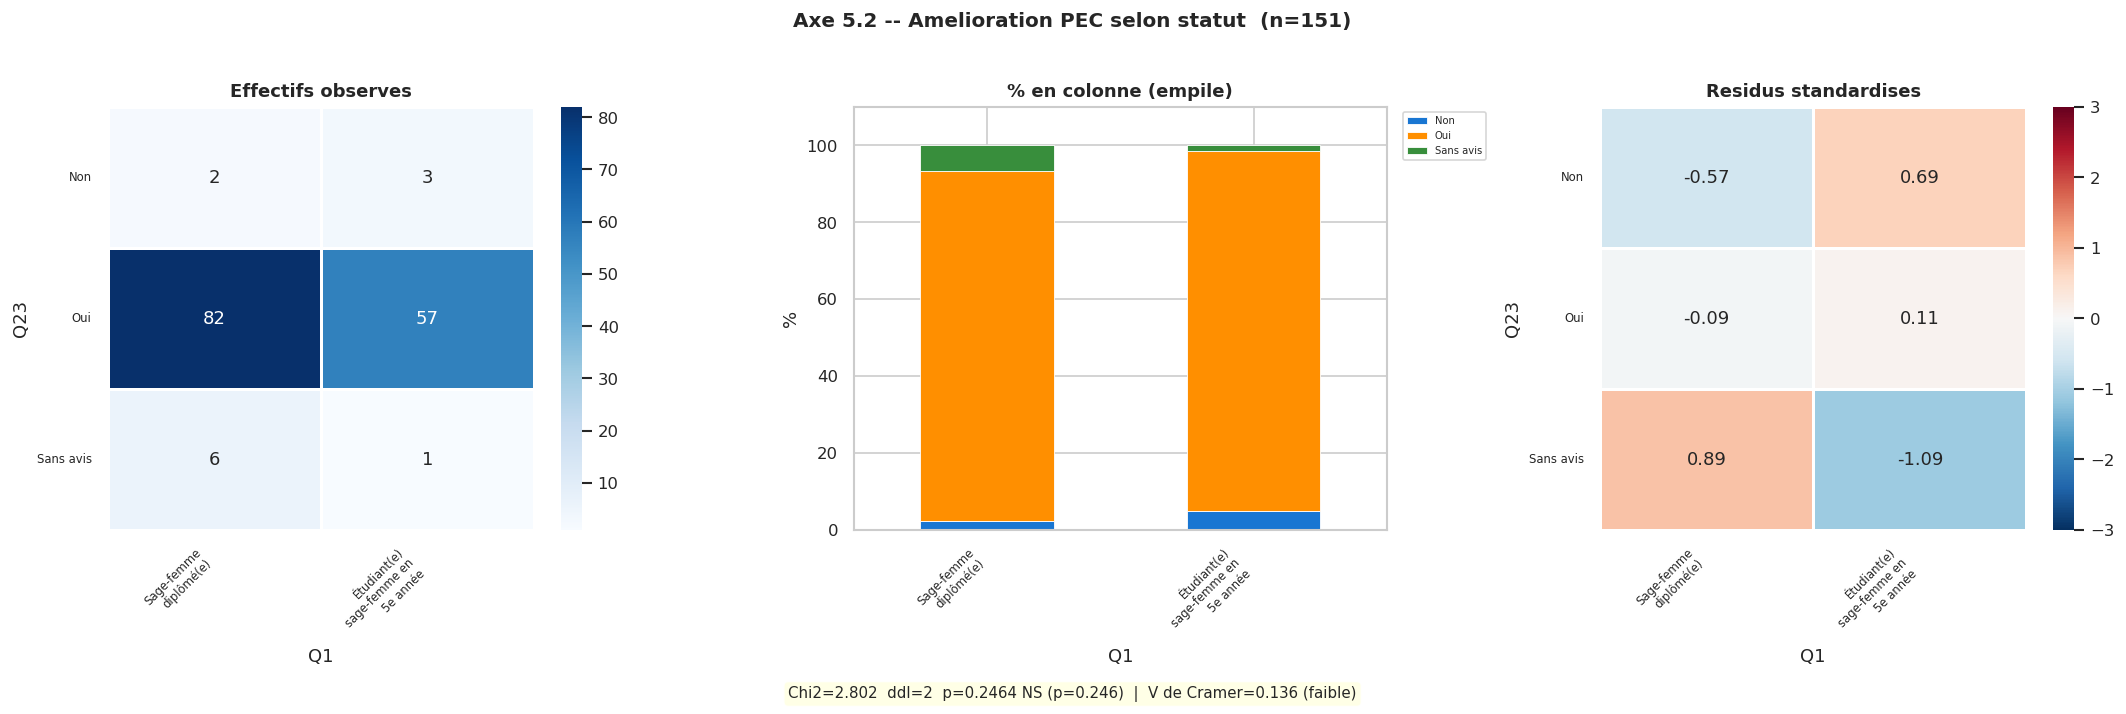

---


In [48]:
r = analyse('Q23','Q1', "Axe 5.2 -- Amelioration PEC selon statut", "Vision differente etudiants/diplomes ?")
if r: results.append(r)

---
## 6. Matrice de correlation (Spearman)

Matrice sur n = 148 observations


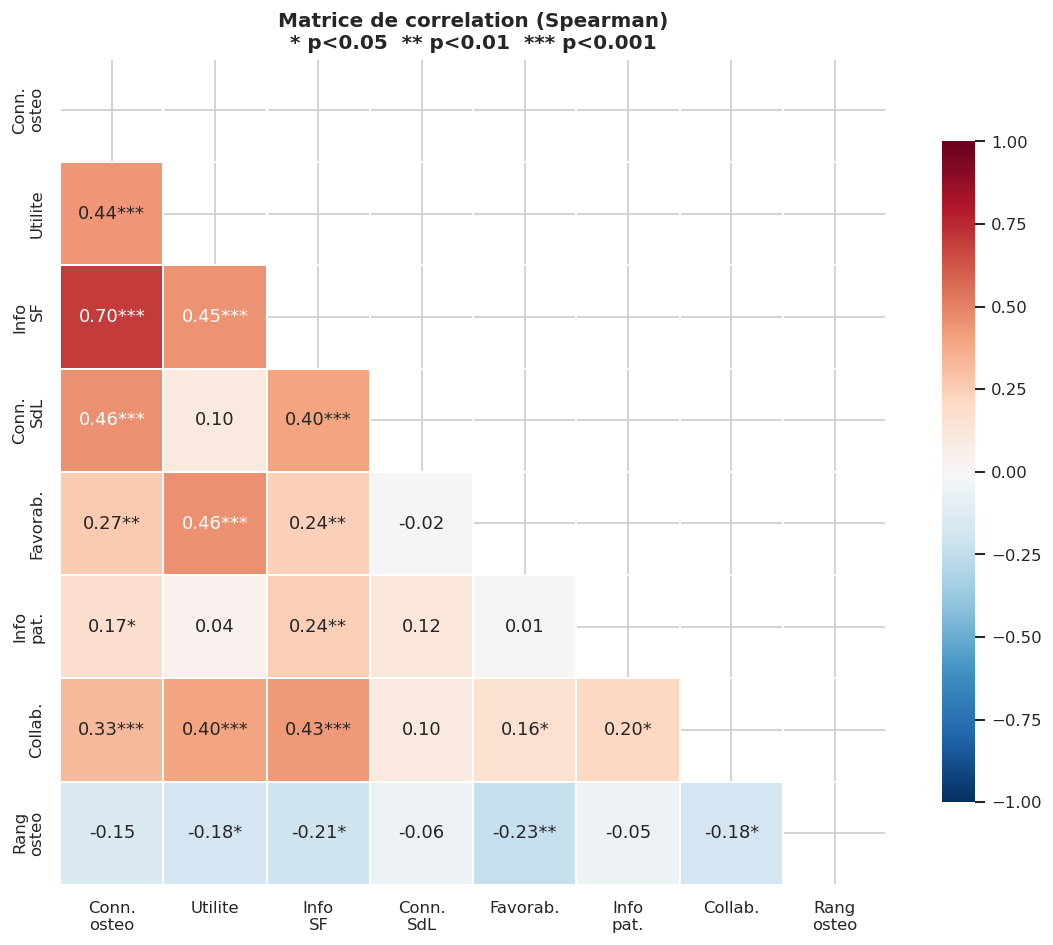


Correlations significatives :


Var1        Var2    rho       p       Force
0   Conn. osteo     Utilite  0.443  0.0000     moderee
1   Conn. osteo     Info SF  0.700  0.0000  tres forte
2   Conn. osteo   Conn. SdL  0.460  0.0000     moderee
3   Conn. osteo    Favorab.  0.265  0.0011      faible
4   Conn. osteo   Info pat.  0.165  0.0446      faible
5   Conn. osteo     Collab.  0.328  0.0000     moderee
6       Utilite     Info SF  0.448  0.0000     moderee
7       Utilite    Favorab.  0.459  0.0000     moderee
8       Utilite     Collab.  0.400  0.0000     moderee
9       Utilite  Rang osteo -0.182  0.0273      faible
10      Info SF   Conn. SdL  0.399  0.0000     moderee
11      Info SF    Favorab.  0.239  0.0034      faible
12      Info SF   Info pat.  0.243  0.0029      faible
13      Info SF     Collab.  0.430  0.0000     moderee
14      Info SF  Rang osteo -0.211  0.0102      faible
15     Favorab.     Collab.  0.163  0.0476      faible
16     Favorab.  Rang osteo -0.229  0.0052      faible
17    Info pat.     Collab.  0.203  0.0132      faible
18      Collab.  Rang osteo -0.182  0.0273      faible

In [49]:
nvars = ['Q4','Q5','Q6','Q10','Q16','Q18','Q8_ord','Q15_osteo_rank']
nlabs = ['Conn.\nosteo','Utilite','Info\nSF','Conn.\nSdL','Favorab.','Info\npat.','Collab.','Rang\nosteo']
ex = [v for v in nvars if v in df.columns]
el = [nlabs[nvars.index(v)] for v in ex]
cd = df[ex].dropna()
print(f"Matrice sur n = {len(cd)} observations")

nv = len(ex)
rho_m = np.zeros((nv,nv))
p_m = np.zeros((nv,nv))
for i in range(nv):
    for j in range(nv):
        if i==j: rho_m[i,j]=1.0
        else:
            r,p = spearmanr(cd[ex[i]], cd[ex[j]])
            rho_m[i,j]=r; p_m[i,j]=p

ann = []
for i in range(nv):
    row = []
    for j in range(nv):
        s = ''
        if i!=j:
            if p_m[i,j]<0.001: s='***'
            elif p_m[i,j]<0.01: s='**'
            elif p_m[i,j]<0.05: s='*'
        row.append(f'{rho_m[i,j]:.2f}{s}')
    ann.append(row)

rdf = pd.DataFrame(rho_m, index=el, columns=el)
adf = pd.DataFrame(ann, index=el, columns=el)
mask = np.triu(np.ones_like(rho_m, dtype=bool))

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(rdf, mask=mask, annot=adf, fmt='', cmap='RdBu_r', center=0, vmin=-1, vmax=1,
           square=True, linewidths=1, ax=ax, cbar_kws={'shrink':0.8})
ax.set_title('Matrice de correlation (Spearman)\n* p<0.05  ** p<0.01  *** p<0.001',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelations significatives :")
sc = []
for i in range(nv):
    for j in range(i+1,nv):
        if p_m[i,j] < 0.05:
            sc.append({'Var1':el[i].replace('\n',' '),'Var2':el[j].replace('\n',' '),
                       'rho':round(rho_m[i,j],3),'p':round(p_m[i,j],4),'Force':interp_rho(rho_m[i,j])})
display(pd.DataFrame(sc))

---
## 7. Analyse de profils

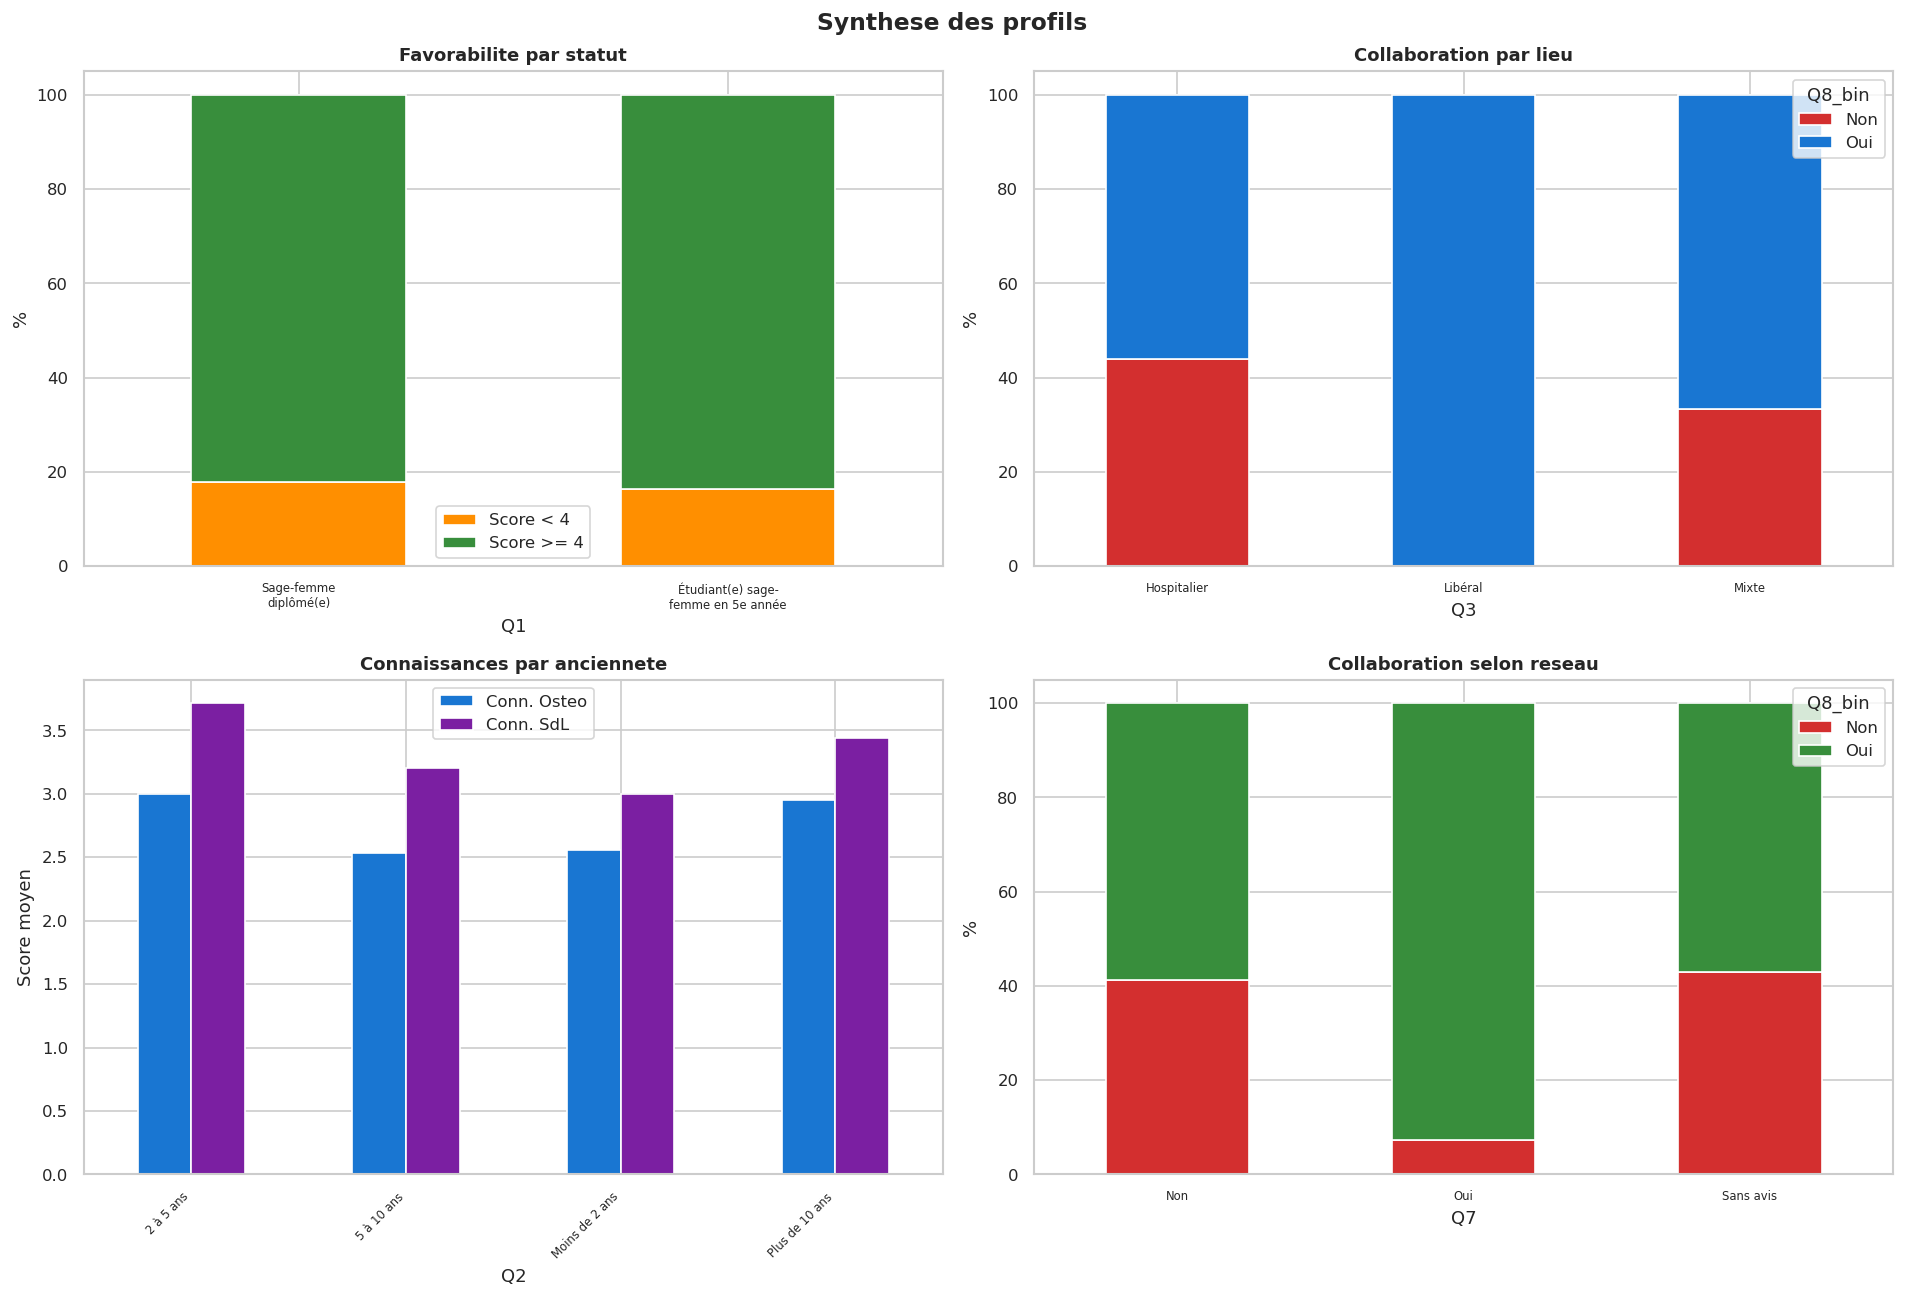

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(16, 11))
fig.suptitle('Synthese des profils', fontsize=14, fontweight='bold')

ct1 = pd.crosstab(df['Q1'], df['Q16']>=4)
ct1.columns = ['Score < 4','Score >= 4']
ct1p = ct1.div(ct1.sum(axis=1), axis=0)*100
ct1p.plot(kind='bar', stacked=True, ax=axes[0,0], color=[COLORS[1],COLORS[2]], edgecolor='white')
axes[0,0].set_title('Favorabilite par statut', fontweight='bold')
axes[0,0].set_ylabel('%'); axes[0,0].set_xticklabels(wl(ct1.index,20), rotation=0, fontsize=7)

ct2d = df[['Q3','Q8_bin']].dropna()
ct2 = pd.crosstab(ct2d['Q3'], ct2d['Q8_bin'])
ct2p = ct2.div(ct2.sum(axis=1), axis=0)*100
ct2p.plot(kind='bar', stacked=True, ax=axes[0,1], color=[COLORS[3],COLORS[0]], edgecolor='white')
axes[0,1].set_title('Collaboration par lieu', fontweight='bold')
axes[0,1].set_ylabel('%'); axes[0,1].set_xticklabels(wl(ct2.index,15), rotation=0, fontsize=7)

ad = df[['Q2','Q4','Q10']].dropna()
if ad['Q2'].nunique()>1:
    m = ad.groupby('Q2')[['Q4','Q10']].mean()
    m.columns = ['Conn. Osteo','Conn. SdL']
    m.plot(kind='bar', ax=axes[1,0], color=[COLORS[0],COLORS[4]], edgecolor='white')
    axes[1,0].set_title('Connaissances par anciennete', fontweight='bold')
    axes[1,0].set_ylabel('Score moyen'); axes[1,0].set_xticklabels(wl(m.index,14), rotation=45, ha='right', fontsize=7)

ct3d = df[['Q7','Q8_bin']].dropna()
ct3 = pd.crosstab(ct3d['Q7'], ct3d['Q8_bin'])
ct3p = ct3.div(ct3.sum(axis=1), axis=0)*100
ct3p.plot(kind='bar', stacked=True, ax=axes[1,1], color=[COLORS[3],COLORS[2]], edgecolor='white')
axes[1,1].set_title('Collaboration selon reseau', fontweight='bold')
axes[1,1].set_ylabel('%'); axes[1,1].set_xticklabels(wl(ct3.index,15), rotation=0, fontsize=7)

plt.tight_layout()
plt.show()

---
## 8. Synthese et validation des hypotheses

In [51]:
display(Markdown("### Tableau recapitulatif"))
rows = []
for r in results:
    if r is None: continue
    t = r['test']
    if t=='chi2': st=f"chi2={r.get('chi2',0):.3f}"; ef=f"V={r.get('V',0):.3f} ({interp_v(r.get('V',0))})"
    elif t=='spearman': st=f"rho={r.get('rho',0):.3f}"; ef=f"|rho|={abs(r.get('rho',0)):.3f} ({interp_rho(r.get('rho',0))})"
    elif t=='mw': st=f"U={r.get('U',0):.1f}"; ef=f"r={r.get('r',0):.3f}"
    elif t=='kw': st=f"H={r.get('H',0):.3f}"; ef=f"eta2={r.get('eta2',0):.3f}"
    else: st=""; ef=""
    p = r.get('p')
    rows.append({
        'Croisement':r['titre'][:55], 'n':r['n'],
        'Test':t.replace('chi2','Chi-deux').replace('mw','Mann-Whitney').replace('kw','Kruskal-Wallis').replace('spearman','Spearman'),
        'Stat':st, 'p':f'{p:.4f}' if p else 'N/A',
        'Sig':'Oui' if p and p<0.05 else 'Non', 'Effet':ef
    })
sdf = pd.DataFrame(rows)

def hl(row):
    if row['Sig']=='Oui':
        p=float(row['p'])
        if p<0.001: return ['background-color:#c8e6c9']*len(row)
        if p<0.01: return ['background-color:#dcedc8']*len(row)
        return ['background-color:#fff9c4']*len(row)
    return ['']*len(row)

display(sdf.style.apply(hl, axis=1).set_caption('Vert fonce=p<0.001 | Vert clair=p<0.01 | Jaune=p<0.05'))

tot=len(rows); sig=sum(1 for r in rows if r['Sig']=='Oui')
print(f"\nTotal : {tot} analyses | Significatifs : {sig} ({sig/tot*100:.1f}%) | NS : {tot-sig}")

### Tableau recapitulatif


Total : 40 analyses | Significatifs : 24 (60.0%) | NS : 16


In [52]:
display(Markdown("### Validation des hypotheses"))

print("H1 : SF favorables au recours osteo")
print(f"  Q16 moyenne={df['Q16'].mean():.2f}, mediane={df['Q16'].median():.0f}")
print(f"  % score >= 4 : {(df['Q16']>=4).mean()*100:.1f}%")
print(f"  --> H1 VALIDEE")
print()

print("H2 : Facteurs individuels influencent recommandation")
for r in results:
    if r and (r['var1'] in ['Q1','Q2','Q3'] or r['var2'] in ['Q1','Q2','Q3']):
        if r['var1'] in ['Q16','Q4','Q8_bin','Q5'] or r['var2'] in ['Q16','Q4','Q8_bin','Q5']:
            p=r.get('p',1)
            print(f"  {r['l1']} x {r['l2']} : p={p:.4f} {'SIGNIFICATIF' if p<0.05 else 'NS'}")
print()

print("H3 : Absence cadre reglementaire = frein majeur")
for r in results:
    if r and ('Q22' in [r['var1'],r['var2']]):
        p=r.get('p',1)
        print(f"  {r['l1']} x {r['l2']} : p={p:.4f} {'SIGNIFICATIF' if p<0.05 else 'NS'}")
print()

print("H4 : Retard diagnostic")
print(f"  % percevant retard : {(df['Q13']=='Oui').mean()*100:.1f}%")
for r in results:
    if r and ('Q13' in [r['var1'],r['var2']]):
        p=r.get('p',1)
        print(f"  {r['l1']} x {r['l2']} : p={p:.4f} {'SIGNIFICATIF' if p<0.05 else 'NS'}")
print()

print("H5 : Osteo percue comme complementaire pertinente")
print(f"  Q5 moyenne={df['Q5'].mean():.2f}, mediane={df['Q5'].median():.0f}")
print(f"  % score >= 4 : {(df['Q5']>=4).mean()*100:.1f}%")
print(f"  --> H5 VALIDEE")

### Validation des hypotheses

H1 : SF favorables au recours osteo
  Q16 moyenne=4.16, mediane=4
  % score >= 4 : 82.8%
  --> H1 VALIDEE

H2 : Facteurs individuels influencent recommandation
  Connaissances osteo (1-5) x Statut : p=0.0001 SIGNIFICATIF
  Connaissances osteo (1-5) x Anciennete : p=0.5049 NS
  Favorabilite (1-5) x Statut : p=0.2694 NS
  Favorabilite (1-5) x Anciennete : p=0.8646 NS
  Connaissances osteo (1-5) x Lieu exercice : p=0.1355 NS

H3 : Absence cadre reglementaire = frein majeur
  Influence reco officielles x Collaboration (Oui/Non) : p=0.8201 NS
  Influence reco officielles x Anciennete : p=0.1114 NS
  Influence reco officielles x Statut : p=0.0000 SIGNIFICATIF

H4 : Retard diagnostic
  % percevant retard : 49.7%
  Retard diagnostic x Lieu exercice : p=0.3195 NS
  Retard diagnostic x Connaissances SdL (1-5) : p=0.0004 SIGNIFICATIF
  Retard diagnostic x Anciennete : p=0.3312 NS
  Retard diagnostic x Moment orientation : p=0.3182 NS

H5 : Osteo percue comme complementaire pertinente
  Q5 moyenne